In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import mutual_info_classif
import unicodedata
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
from optuna.samplers import TPESampler
import optuna
import re
from fuzzywuzzy import process
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from catboost import Pool
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

c:\Users\Pc\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
c:\Users\Pc\anaconda3\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [280]:
test = pd.read_csv(r'c:\Users\Pc\Desktop\btk datathon\test_x.csv')

In [130]:
a = pd.read_csv(r'c:\Users\Pc\Desktop\btk datathon\test_x.csv')

In [240]:
def general_specs(df):
    print('*'*25,'SHAPE','*'*25)
    print(df.shape)
    print('*'*25,'INFO','*'*25)
    print(df.info())
    print('*'*25, 'NUMERICAL COLUMNS', '*'*25)
    display(describe(df, numerical = True))
    print('*'*25, 'CATEGORICAL COLUMNS','*'*25)
    display(describe(df, numerical = False))

def describe(df, numerical):
    if numerical:
        describe_df = df.describe()
        numerical_columns = describe_df.columns         
        df_numerical = df.loc[:,numerical_columns]
        describe_T = describe_df.T
        missing_values = pd.DataFrame(data = df_numerical.isnull().sum(), columns = ['Miss_values'])
        describe_T['Missing_values'] = missing_values
        skewness = pd.DataFrame(data = df_numerical.skew().T, columns = ['Skewness'])     
        kurtosis = pd.DataFrame(data = df_numerical.kurtosis().T, columns = ['Kurtosis'])
        return pd.concat([describe_T, skewness, kurtosis], axis = 1)
    else:
        describe_df = df.describe(exclude = np.number).T
        describe_df['Missing Values'] = df.loc[:,describe_df.index].isnull().sum()
        return describe_df

In [57]:
def categorical_examiner(df, col, colors_set = 0, hue = False, rotation = True, percentage = False):
    df = df.sort_values(by = col, ascending = False)
    unique_rows = df[col].nunique()
    if df[col].value_counts().shape[0] > 10:
        index = df[col].value_counts().head(10).index
        df[col] = df[df[col].isin(index)][col]
    colors = sns.color_palette(n_colors = unique_rows)
    f, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(12,6))
    if hue == False:
        sns.countplot(df, x = col, palette = colors, ax = ax)
        plt.suptitle(f'COL:{col} COUNT PLOT')
    else:
        sns.histplot(df, x = col, hue = hue, palette = colors, ax = ax, bins = 100)
        plt.suptitle(f'COL:{col} COUNT PLOT')       
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    
    # Yüzde değerlerini grafik üzerinde göstermek için
    count = df[col].value_counts(normalize=True) * 100  # Yüzdeleri alıyoruz
    categories = df[col].unique()  # Benzersiz kategorileri alıyoruz

    if percentage == True:
        for category in categories:
            value = count.get(category, 0)  # İlgili kategorinin yüzdesini alıyoruz
            position = list(df[col].unique()).index(category)  # Kategorinin pozisyonunu alıyoruz
            plt.text(position, value + 0.5, f'{value:.1f}%', ha='center', va='bottom')
    plt.tight_layout()
    return plt.show()

In [24]:
def numerical_examiner(df, col, log = False, bins = 100, inf = False):
    f, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (12,6))
    ax11, ax12 = ax[0][0], ax[0][1]      
    sns.histplot(df, x = col, bins = bins, ax = ax11)
    sns.boxplot(df, x = col, ax = ax12)
    ax11.set_title('Histogram')
    ax12.set_title('Boxplot')
    if log == True:
        temp = df.copy()
        temp[col] = np.log10(temp[col])
        temp[col] = np.log10(temp[col])
        ax21, ax22 = ax[1][0], ax[1][1]
        if inf == True:
            temp[col] = temp[col].replace([float(inf), float(-inf), np.nan, -np.nan], 0)
            sns.histplot(temp, x = col, bins = bins, ax = ax21)
            sns.boxplot(temp, x = col, ax = ax22)
        else:
            sns.histplot(temp, x = col, bins = bins, ax = ax21)
            sns.boxplot(temp, x = col, ax = ax22)
    plt.suptitle(f'Column:{col}, MIN:{df[col].min()}, MAX:{df[col].max()}')
    plt.tight_layout()
    return plt.show()

In [282]:
test.fillna('bilinmiyor', inplace = True)

def yazım_düzeltme(veri):
    if pd.isnull(veri):
        return None
    # 2. String kontrolü
    if not isinstance(veri, str):
        return veri
    küçük_harf = veri.lower()
    return küçük_harf
    
for columns in test.columns:
    test[columns]= test[columns].apply(lambda x: yazım_düzeltme(x))

def bosluk_temizleme(veri):
    if pd.isnull(veri):
        return None
    # 2. String kontrolü
    if not isinstance(veri, str):
        return veri
    boşluksuz = veri.strip()
    son_hali = veri.replace(r'\s+', ' ', regex=True)
    return son_hali

for columns in test.columns:
    test[columns]= test[columns].apply(lambda x: yazım_düzeltme(x))

def hata_temizleme(veri):
    if isinstance(veri, str):  # Sadece string veriler üzerinde işlem yap
        return re.sub(r'[^\w\s]', '', veri)  # Özel karakterleri temizle
    return veri  # String değilse olduğu gibi döndür

# Hariç tutulacak sütunların listesi
hariç_tutulan_sütunlar = [
    "Dogum Tarihi", "Dogum Yeri", "Universite Not Ortalamasi", "Ikametgah Sehri	","Lise Mezuniyet Notu","Lise Sehir", 
    "Baba Egitim Durumu", "Uye Oldugunuz Kulubun Ismi", 
    "Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?", 
    "Hangi STK'nin Uyesisiniz?"
]

# Belirtilen sütunlar dışında kalan tüm sütunlara hata_temizleme fonksiyonunu uygula
for column in test.columns:
    if column not in hariç_tutulan_sütunlar:
        test[column] = test[column].apply(lambda veri: hata_temizleme(veri))

def turkish_to_english(text):
    if isinstance(text, str):  # Sadece string textler üzerinde işlem yap
        translation_table = str.maketrans("çğıöşü", "cgiosu")  # ı -> i
        return text.translate(translation_table)
    return text  # String değilse olduğu gibi döndür

for column in test.columns:
    test[column] = test[column].apply(lambda x: turkish_to_english(x))

doğru_şehirler = ['adana', 'adiyaman', 'afyonkarahisar', 'agri', 'aksaray', 'amasya', 'ankara', 'antalya', 'ardahan', 'artvin', 'aydin', 'balikesir', 'bartin', 'batman', 'bayburt',
 'bilecik', 'bingol', 'bitlis', 'bolu', 'burdur', 'bursa', 'canakkale', 'cankiri', 'corum', 'denizli', 'diyarbakir', 'duzce', 'edirne', 'elazig', 'erzincan',
 'erzurum', 'eskisehir', 'gaziantep', 'giresun', 'gumushane', 'hakkari', 'hatay', 'igdir', 'isparta', 'istanbul', 'izmir', 'kahramanmaras', 'karabuk', 'karaman',
 'kars', 'kastamonu', 'kayseri', 'kirikkale', 'kirklareli', 'kirsehir', 'kilis', 'kocaeli', 'konya', 'kutahya', 'malatya', 'manisa', 'mardin', 'mersin', 'mugla', 'mus',
 'nevsehir', 'nigde', 'ordu', 'osmaniye', 'rize', 'sakarya', 'samsun', 'siirt', 'sinop', 'sivas', 'sanliurfa', 'sirnak', 'tekirdag', 'tokat', 'trabzon', 'tunceli', 'usak', 'van',
 'yalova', 'yozgat', 'zonguldak']


def sehir_duzelt(sehir, dogru_sehirler):
    # 1. NaN kontrolü
    if pd.isnull(sehir):
        return None
    
    # 2. String kontrolü
    if not isinstance(sehir, str):
        return sehir
    
    # 3. Şehri "/" işareti ile iki parçaya böl
    parcalar = sehir.split('/')
    
    # 4. İlk parçayı (şehir kısmı olduğunu varsayıyoruz) temizle
    sehir_temiz = parcalar[0].strip()
    
    # 5. İlk parçayı doğru şehir listesi ile karşılaştır
    en_yakin_sehir = process.extractOne(sehir_temiz, dogru_sehirler)[0]
    
    # 6. Eğer ilk parça doğru şehirlerden biriyle çok benzer değilse ikinci parçayı kontrol et
    if en_yakin_sehir not in dogru_sehirler and len(parcalar) > 1:
        ikinci_parca = parcalar[1].strip()
        en_yakin_sehir = process.extractOne(ikinci_parca, dogru_sehirler)[0]
    
    return en_yakin_sehir

# Şehir sütununu düzenle
test['Dogum Yeri'] = test['Dogum Yeri'].apply(lambda x: sehir_duzelt(x, doğru_şehirler))

test['Ikametgah Sehri'] = test['Ikametgah Sehri'].apply(lambda x: sehir_duzelt(x, doğru_şehirler))

test['Universite Kacinci Sinif'] = test['Universite Kacinci Sinif'].replace({'0':'hazirlik', 'tez':'yuksek lisans'})

test['Universite Not Ortalamasi'] = test['Universite Not Ortalamasi'].replace({'3.00 - 3.50' : '3.00-3.50',
                                                                                '3.50-3' : '3.00-3.50', '3.00 - 3.50' : '3.00-3.50',
                                                                                '2.50 - 3.00 ' : '2.50-3.00', '3.50 - 4.00' : '3.50-4.00',
                                                                                '2.00 - 2.50 ' : '2.00-2.50', '2.50 - 2.99' : '2.50-3.00',
                                                                                '3.00 - 3.49' : '3.00-3.50', '2.50 -3.00' : '2.50-3.00',
                                                                                '3.00 - 4.00' : '3.00-4.00', '1.80 - 2.49' : '2.00-2.50',
                                                                                '4-3.5' : '3.50-4.00', '1.00 - 2.50' : '1.00-2.50', '0 - 1.79' : '0-1.79',
                                                                                '4.0-3.5' : '3.50-4.00', '3.00-2.50' : '2.50-3.00', '2.50 - 3.00': '2.50-3.00',
                                                                                 '2.00 - 2.50' : '2.00-2.50', 'ORTALAMA BULUNMUYOR' : 'ortalama yok', 'Not ortalamasi yok' : 'ortalama yok',
                                                                                 'Ortalama bulunmuyor' : 'ortalama yok', '1.00-2.50' : '2.50 ve alti', '0-1.79' : '2.50 ve alti',
                                                                                 '3.00-3.50' : '3.00-4.00', '3.50-4.00' : '3.00-4.00', '2.00-2.50' : '2.50 ve alti', 'Hazirliğim' : 'ortalama yok', 'hazirligim' : 'ortalama yok',
                                                                                 'ortalama bulunmuyor' : 'ortalama yok', 'not ortalamasi yok' : 'ortalama yok'
                                                                                    })

test['Universite Not Ortalamasi'] = test['Universite Not Ortalamasi'].replace({
    '3.00-3.50' : '3.00-4.00', '3.50-4.00' : '3.00-4.00', '2.00,2.50' : '2.50 ve alti',
    '1.00-2.50' : '2.50 ve alti', '0-1.79' : '2.50 ve alti', '2.00-2.50' : '2.50 ve alti'})

test.loc[test['Lise Adi'].str.contains('acik', case=False, na=False), 'Lise Adi'] = 'acik ogretim'
test.loc[test['Lise Adi'].str.contains('ogretim', case=False, na=False), 'Lise Adi'] = 'acik ogretim'
test['Lise Adi'].replace({'' : 'bilinmiyor'}, inplace = True)

# Yeni sütunu oluştur ve koşullara göre değerleri atayın
test['Lise Adi Yeni'] = test.apply(
    lambda row: row['Lise Adi'] if row['Lise Adi'] != 'bilinmiyor' else (row['Lise Adi Diger'] if row['Lise Adi Diger'] != 'bilinmiyor' else 'bilinmiyor'),
    axis=1
)


ilçe_il = pd.read_csv(r'C:\Users\Pc\Downloads\ilce_sinirlari.csv')

def turkish_to_english(text):
    if isinstance(text, str):  # Sadece string textler üzerinde işlem yap
        text = text.lower()
        translation_table = str.maketrans("çğıöşü", "cgiosu")  # ı -> i
        return text.translate(translation_table)
    return text  # String değilse olduğu gibi döndür

for column in ilçe_il.columns:
    ilçe_il[column] = ilçe_il[column].apply(lambda x: turkish_to_english(x))

il_ilce_dict = ilçe_il.set_index('ILCE_ADI')['IL_ADI'].to_dict()

test['Lise Sehir'] = test['Lise Sehir'].map(il_ilce_dict).fillna(test['Lise Sehir'])

def normalize_string(s):
    return unicodedata.normalize('NFKD', s).encode('ASCII', 'ignore').decode('ASCII')

test['Lise Sehir'] = test['Lise Sehir'].apply(normalize_string).str.lower().str.strip()

test['Lise Turu'] = test['Lise Turu'].replace({'ozel' : 'ozel lise', 'ozel lisesi' : 'ozel lise', 'meslek' : 'meslek lisesi', 'duz lise' : 'devlet'})

test['Lise Mezuniyet Notu'] = test['Lise Mezuniyet Notu'].replace({
    '75 - 100' : '75-100', '84-70' : '75-100', '100-85' : '75-100',
    '4.00-3.50' : '75-100', '50 - 75' : '50-75', '3.00 - 4.00' : '75-100',
    '3.50-3.00' : '75-100', '3.50-3' : '75-100', '69-55' : '50-75', '3.00-2.50' : '75-100',
    '50 - 74' : '50-75', '2.50 ve alti' : '25-50', '2.50 ve altı' : '25-50', '54-45' : '25-50',
    '25 - 50': '25-50', 'not ortalamasi yok' : '25-50','Not ortalamasi yok' : '25-50',
    '44-0' : '25-50', '0 - 25' : '25-50', '25 - 49' : '25-50','0 - 24' : '25-50',
    'Not ortalaması yok' : '25-50'
}) 

test['Lise Mezuniyet Notu'] = test['Lise Mezuniyet Notu'].fillna('bilinmiyor')

# Temizleme fonksiyonu
def temizle_burs_bilgisi(x):
    if pd.isnull(x):
        return x
    if re.search(r'kyk|kredi', x):
        return 'kyk'
    return x

# Değişkeni güncelleme
test['Burs Aldigi Baska Kurum'] = test['Burs Aldigi Baska Kurum'].apply(temizle_burs_bilgisi)

test['Burs Aldigi Baska Kurum'] = test['Burs Aldigi Baska Kurum'].replace({'':'bilinmiyor', 'k' : 'kyk', 'ky' : 'kyk', 'devlet bursu' : 'devlet'})

test['Anne Egitim Durumu'] = test['Anne Egitim Durumu'].replace({'ilkokul mezunu' : 'ilkokul', 'ortaokul mezunu' : 'ortaokul', 'lise mezunu' : 'lise',
                                                                    'universite mezunu' : 'universite', 'yuksek lisans  doktora' : 'doktora',
                                                                    'yuksek lisans  doktara' : 'doktora', 'egitim yok' : 'egitimi yok'})

test['Anne Sektor'] = test['Anne Sektor'].replace({'0' : 'yok' , '' : 'yok'})

def normalize_string(s):
    return unicodedata.normalize('NFKD', s).encode('ASCII', 'ignore').decode('ASCII')

test['Baba Egitim Durumu'] = test['Baba Egitim Durumu'].apply(normalize_string).str.lower().str.strip()

test['Baba Egitim Durumu'] = test['Baba Egitim Durumu'].replace({'ilkokul mezunu' : 'ilkokul', 'ortaokul mezunu' : 'ortaokul', 'lise mezunu' : 'lise',
                                                                    'universite mezunu' : 'universite', 'yuksek lisans / doktora' : 'doktora',
                                                                    'yuksek lisans / doktara' : 'doktora', 'egitim yok' : 'egitimi yok', '0' : 'egitimi yok'})

test['Baba Sektor'] = test['Baba Sektor'].replace({'0' : 'yok' , '' : 'yok'})

def donustur_int64_veya_birak(veri):
    # Eğer veri eksik değilse ve veri zaten bir tam sayiysa veri olduğu gibi birakilir.
    if pd.isnull(veri) or isinstance(veri, int):
        return veri
    # Eğer veri tam sayi değilse ve dönüşebilir durumdaysa tam sayiya çevirilir.
    try:
        return int(veri)
    except (ValueError, TypeError):
        # Dönüşüm başarisiz olursa veri olduğu gibi birakilir.
        return veri

# Her bir hücreyi kontrol ederek uygun işlemi yapiyoruz
test['Kardes Sayisi'] = test['Kardes Sayisi'].apply(donustur_int64_veya_birak)

test['Kardes Sayisi'] = test['Kardes Sayisi'].replace({'kardes sayisi 1 ek bilgi aile hk anne vefat' : '1'})

test['Spor Dalindaki Rolunuz Nedir?'] = test['Spor Dalindaki Rolunuz Nedir?'].replace({'0' : 'yok', '' : 'yok', 'kaptan  lider' : 'kaptan' , 'liderkaptan' : 'kaptan'})

mapping  = {
    "kizilay": [
        "kizilay",
        "kizilay kan bagişi",
        "kizilay afad",
        "yeşilay kizilay",
        "kizil ay",
        "kizilay",
        "turk kizilayi",
        "kizil ay",
        "turk kizilay",
        "kizilay kan bagisi",
        "turk kizilayi",
        "turk kizilayi",
        "turk kizilay"
    ],
    "losev": [
        "losev",
        "losev vakfi",
        "losev ihh",
        "losevv",
        "losemili cocuklar dernegi"
    ],
    "tema": [
        "tema vakfi",
        "t.e.m.a",
        "tema dernegi",
        "tema agac dikim",
        "teema"
    ],
    "tog": [
        "tog vakfi",
        "toplum gonulluleri",
        "toplum gonulluleri vakfi",
        "toplum gonulluleri",
        "tog dernegi"
    ],
    "yeşilay": [
        "yesilay",
        "yeşilay dernegi",
        "yeşilay vakfi",
        "yesil ay",
        "genc yeşilay"
    ],
    "afad": [
        "afad başkanligi",
        "afad vakfi",
        "afaad",
        "afad dernegi",
        "afet ve acil yardim"
    ],
    "ihh": [
        "ihh",
        "ihh vakfi",
        "insani yardim ihh",
        "ihh insani yardim",
        "insan haklari ihh"
    ],
    "tugva": [
        "tugva vakfi",
        "tugva",
        "tugva dernegi",
        "turkiye genclik vakfi",
        "t3 vakfi"
    ],
    "aiesec": [
        "aiesec",
        "ai sec",
        "aiesec",
        "ai seck",
        "aysec"
    ],
    "tusev": [
        "tusev",
        "tusev vakfi",
        "tu se v",
        "turkiye sosyal vakfi",
        "tusevv"
    ],
    "tubitak": [
        "tubitak",
        "tubitak vakfi",
        "tubitak",
        "tubi tak",
        "tubi tak"
    ],
    "akut": [
        "akut dernegi",
        "akut vakfi",
        "akut kurtarma",
        "a kut",
        "akutt"
    ],
    "tegv": [
        "tegv vakfi",
        "tegv dernegi",
        "turkiye egitim gonulluleri",
        "egitim gonulluleri",
        "te gv"
    ],
    "cydd": [
        "cydd",
        "cagdaş yaşami destekleme dernegi",
        "cydd",
        "c ydd",
        "cagdaş yaşam dernegi"
    ],
    "tev": [
        "tev vakfi",
        "tev bursu",
        "t.e.v",
        "tev dernegi",
        "turkiye egitim vakfi",
        "turkiye egitim vakfi",
        "turkiye egitim vakfi",
        "turkiye egitim dernegi",
    ],
    "daruşşafaka": [
        "daruşşafaka",
        "daruşşafaka",
        "darusafaka",
        "daruş safaka",
        "daru şafaka"
    ],
    "greenpeace": [
        "greenpeace",
        "green peace",
        "grenpeace",
        "greenpeace dernegi",
        "greenpeac"
    ],
    "wwf": [
        "wwf",
        "w w f",
        "world wildlife fund",
        "dunya dogayi koruma vakfi",
        "wwf vakfi"
    ],
    "unicef": [
        "unicef",
        "unicef",
        "uni sef",
        "unicef vakfi",
        "uniseff"
    ]
}


def duzelt_veri(veri):
    if pd.isnull(veri) or isinstance(veri, int):
        return veri
    for dogru, yanlislar in mapping.items():
        for yanlis in yanlislar:
            if yanlis in veri:
                return dogru  # Eşleşen bir yanlış varsa doğru ile değiştir
    return veri  # Yanlış bulunmazsa orijinal veri döner

# Uygulayalım
test["Hangi STK'nin Uyesisiniz?"] = test["Hangi STK'nin Uyesisiniz?"].apply(duzelt_veri)

test["Hangi STK'nin Uyesisiniz?"] = test["Hangi STK'nin Uyesisiniz?"].replace({'-' : 'yok', '' : 'yok'})

# Temizleme fonksiyonu
def kategori_belirle(deger):
    if pd.isnull(deger):
        return deger
    deger = deger.strip()
    if deger == 'bilinmiyor':
        return 'bilinmiyor'
    if deger == '-':
        return 'deneyim yok'
    if deger == '':
        return 'deneyim yok'
    kelime_sayisi = len(deger.split())
    if kelime_sayisi > 6:
        return 'deneyim var'
    else:
        return 'deneyim yok'

# Uygulama
test['Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?'] = test['Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?'].apply(kategori_belirle)

test['Ingilizce Seviyeniz?'] = test['Ingilizce Seviyeniz?'].replace({'0' : 'yok'})

universite_tur_sozluk = {
    "istanbul universitesi": "devlet",
    "hacettepe universitesi": "devlet",
    "bogazici universitesi": "devlet",
    "odtu (orta dogu teknik universitesi)": "devlet",
    "ankara universitesi": "devlet",
    "istanbul teknik universitesi": "devlet",
    "ege universitesi": "devlet",
    "gazi universitesi": "devlet",
    "dokuz eylul universitesi": "devlet",
    "marmara universitesi": "devlet",
    "bilkent universitesi": "ozel",
    "yildiz teknik universitesi": "devlet",
    "suleyman demirel universitesi": "devlet",
    "kocaeli universitesi": "devlet",
    "selcuk universitesi": "devlet",
    "uludag universitesi": "devlet",
    "cukurova universitesi": "devlet",
    "karadeniz teknik universitesi": "devlet",
    "pamukkale universitesi": "devlet",
    "gaziantep universitesi": "devlet",
    "sakarya universitesi": "devlet",
    "akdeniz universitesi": "devlet",
    "ondokuz mayis universitesi": "devlet",
    "dicle universitesi": "devlet",
    "erciyes universitesi": "devlet",
    "firat universitesi": "devlet",
    "inonu universitesi": "devlet",
    "canakkale onsekiz mart universitesi": "devlet",
    "nevsehir haci bektas veli universitesi": "devlet",
    "trabzon universitesi": "devlet",
    "eskisehir osmangazi universitesi": "devlet",
    "mugla sitki kocman universitesi": "devlet",
    "ataturk universitesi": "devlet",
    "istanbul medipol universitesi": "ozel",
    "yalova universitesi": "devlet",
    "mehmet akif ersoy universitesi": "devlet",
    "mardin artuklu universitesi": "devlet",
    "aksaray universitesi": "devlet",
    "istanbul gelisim universitesi": "ozel",
    "isparta uygulamali bilimler universitesi": "devlet",
    "van yuzuncu yil universitesi": "devlet",
    "kirikkale universitesi": "devlet",
    "bilecik seyh edebali universitesi": "devlet",
    "usak universitesi": "devlet",
    "nigde omer halisdemir universitesi": "devlet",
    "bartin universitesi": "devlet",
    "siirt universitesi": "devlet",
    "kastamonu universitesi": "devlet",
    "balikesir universitesi": "devlet",
    "kilis 7 aralik universitesi": "devlet",
    "ordu universitesi": "devlet",
    "bayburt universitesi": "devlet",
    "hatay mustafa kemal universitesi": "devlet",
    "gumushane universitesi": "devlet",
    "bozok universitesi": "devlet",
    "adiyaman universitesi": "devlet",
    "sivas cumhuriyet universitesi": "devlet",
    "bitlis eren universitesi": "devlet",
    "istanbul sabahattin zaim universitesi": "ozel",
    "bogazici universitesi": "devlet",
    "anadolu universitesi": "devlet",
    "dokuz eylul universitesi": "devlet",
    "orta dogu teknik universitesi": "devlet",
    "trakya universitesi": "devlet",
    "karabuk universitesi": "devlet",
    "beykent universitesi": "ozel",
    "yeditepe universitesi": "ozel",
    "firat universitesi": "devlet",
    "dumlupinar universitesi": "devlet",
    "canakkale onsekiz mart universitesi": "devlet",
    "koc universitesi": "ozel",
    "ondokuz mayis universitesi": "devlet",
    "bahcesehir universitesi": "ozel",
    "istanbul aydin universitesi": "ozel",
    "mersin universitesi": "devlet",
    "istanbul bilgi universitesi": "ozel",
    "istanbul gelisim universitesi": "ozel",
    "adiyaman universitesi": "devlet",
    "abant izzet baysal universitesi": "devlet",
    "bingol universitesi": "devlet",
    "mugla sitki kocman universitesi": "devlet",
    "celal bayar universitesi": "devlet",
    "aydin adnan menderes universitesi": "devlet",
    "demiroglu bilim universitesi": "ozel",
    "hasan kalyoncu universitesi": "ozel",
    "tunceli universitesi": "devlet",
    "ardahan universitesi": "devlet",
    'istanbul okan universitesi' : 'ozel',
    'dogus universitesi' : 'ozel',
    'ozyegin universitesi' : 'ozel',
    'nisantasi universitesi' : 'ozel',
    'mef universitesi' : 'ozel',
    'sabanci universitesi' : 'ozel',
    'kadir has universitesi' : 'ozel'
}


def üni_tür(veri):
    if pd.isna(veri):  # Eğer veri NaN ise None dondür
        return 'bilinmiyor'
    for universite, tür in universite_tur_sozluk.items():
        if universite in veri:  # Veri üniversite adı içeriyorsa ili dondür (küçük harflerle kontrol)
            return tür
    return 'bilinmiyor'  # Eşleşme bulunmazsa 'bilinmiyor' dondür

# 'Ikametgah Sehri' None olan satırlar için 'Universite Adi' sütununu kullanarak ikametgah düzeltme işlemi
test.loc[test["Universite Turu"] == 'bilinmiyor', 'Universite Turu'] = test[test["Universite Turu"] == 'bilinmiyor']["Universite Adi"].apply(üni_tür)
    
# Yılı alma işlemi
test['Yil'] = test['Dogum Tarihi'].str.split('.').str[-1].str[:4]

test['Yil'] = test['Yil'].replace({'bilinmiyor' : 1996})

test['Yil'] = test['Yil'].astype('int64')

test['Basvuru Yili'] = test['Basvuru Yili'].astype('int64')

test['yaş'] = test['Basvuru Yili'] - test['Yil']

def yas_grubu(yas):
    if yas < 0:
        return 'bilinmiyor'
    elif 0 <= yas < 14:
        return 'cocuk'
    elif 14 <= yas <= 19:
        return 'ergen'
    elif 19 <= yas <= 24:
        return 'genc'
    elif 24 <= yas <= 30:
        return 'orta yasli'
    else:
        return 'deneyimli'

test['yaş_grubu'] = test['yaş'].apply(yas_grubu)

egitim_durumu_puanlama = {
    'bilinmiyor': 0,
    'egitimi yok': 1,
    'ilkokul': 2,
    'ortaokul': 3,
    'lise': 4,
    'universite': 5,
    'yuksek lisans': 6,
    'doktora': 7
}

test['Anne Egitim Durumu Puan'] = test['Anne Egitim Durumu'].map(egitim_durumu_puanlama)
test['Baba Egitim Durumu Puan'] = test['Baba Egitim Durumu'].map(egitim_durumu_puanlama)

test['Ortalama Egitim Puan'] = (test['Anne Egitim Durumu Puan'] + test['Baba Egitim Durumu Puan']) / 2

def classify_membership(row):
    if row['Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?'] == 'evet':
        if row['Aktif olarak bir STK üyesi misiniz?'] == 'evet':
            return 'girisimci ve sosyal'
        elif row['Aktif olarak bir STK üyesi misiniz?'] == 'hayir':
            return 'girisimci ama sosyal degil'
        elif row['Aktif olarak bir STK üyesi misiniz?'] == 'bilinmiyor':
            return 'girisimci ama sosyal degil'
    elif row['Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?'] == 'hayir':
        if row['Aktif olarak bir STK üyesi misiniz?'] == 'evet':
            return 'sosyal ama girisimci degil'
        elif row['Aktif olarak bir STK üyesi misiniz?'] == 'hayir':
            return 'sosyal degil ve girisimci degil'
        elif row['Aktif olarak bir STK üyesi misiniz?'] == 'bilinmiyor':
            return 'sosyal degil ve girisimci degil'
    return 'bilinmiyor'

test['girisimci_stk_etiket'] = test.apply(classify_membership, axis=1)

# Türkiye'deki ilk 10 büyük sehir
buyuk_sehirler = ['istanbul', 'ankara', 'izmir', 'bursa', 'antalya', 'adana', 'konya', 'eskisehir','eskisehir' 'kocaeli', 'mugla', 'mersin']

# Yeni sütunları olustur
test['dogum_ikametgah'] = (test['Dogum Yeri'] == test['Ikametgah Sehri']).astype(int)
test['buyuk_sehir'] = test['Ikametgah Sehri'].apply(lambda x: 1 if x in buyuk_sehirler else 0)

test.loc[test['Burslu ise Burs Yuzdesi'] == 'bilinmiyor', 'Burslu ise Burs Yuzdesi'] = 0.0

test['Burslu ise Burs Yuzdesi'] = test['Burslu ise Burs Yuzdesi'].astype('float64')

# Yüzdeyi sayıya dönüştürme ve koşullara göre dönüştürme
def burs_yuzdesi_donustur(yuzde):
    if isinstance(yuzde, str) and yuzde.startswith('%'):
        yuzde = float(yuzde.strip('%'))  # Yüzde işareti kaldır ve sayıya dönüştür
    elif isinstance(yuzde, (int, float)):  # Eğer sayısal değer ise, doğrudan kullan
        yuzde = float(yuzde)
    else:
        return None  # Format uyumsuz ise None döndür

    if yuzde == 0.0:
        return 0.0
    elif yuzde == 25.0:
        return 0.25
    elif yuzde == 50.0:
        return 0.50
    elif yuzde == 75.0:
        return 0.75
    elif yuzde == 100.0:
        return 1.0
    elif 0.0 < yuzde < 25.0:
        return 0.25
    elif 25.0 < yuzde < 50.0:
        return 0.50
    elif 50.0 < yuzde < 75.0:
        return 0.75
    elif 75.0 < yuzde < 100.0:
        return 1.0
    else:
        return yuzde  # Diğer durumlar için

# Yeni bir sütun oluştur ve dönüştürme fonksiyonunu uygula
test['Burs'] = test['Burslu ise Burs Yuzdesi'].apply(burs_yuzdesi_donustur)

# Fonksiyon: Satırda sayısal değeri bul, sadece sayıyı çıkar
def extract_numeric(row):
    # Düzenli ifadeyle (regex) satırdaki sayısal değerleri bul
    numbers = re.findall(r'\d+', row)
    if numbers:
        # Eğer sayısal bir değer bulunursa, birinci değeri döndür
        return numbers[0]
    else:
        # Sayısal değer yoksa satırı olduğu gibi döndür
        return row

# Apply fonksiyonu ile her satırı işleyin
test['Burs Miktarı Temiz'] = test['Baska Kurumdan Aldigi Burs Miktari'].apply(extract_numeric)

test['Burs Miktarı Temiz'].replace({'burs almiyor' : 0, '0' : 0, 'diger' : 600, 'yurt ve yemekhane bursu' : 510,  'daha onceden bu kurumdan bir burs almadim' : 0,
                                     'geri odemeli kyk bursu' : 425, 'yok' : 0, 'kyk bursu kadar' : 425, 'her sene belirlenen miktari' : 425, 'burs almiyorum' : 0,
                                     'spor genclik bakanligi' : 425, '.' : 0, 'cince dil bursu' : 500, 'almiyorum henuz' : 0, 'degisiyordu her sene' : 425, 'kyk' : 425,
                                     'bin türk lirasi' : 1000, 'yurt bursum var' : 300,'yurt bursu' : 300, 'yillik belirlenen kapsamli burs kadar' : 833, 'kyk' : 425,
                                     'nakit burs degil. yurt ücretim odeniyor.' : 350, 'Ücyüz lira' : 300, 'tam burslu oldugum icin yalniz egitim ücreti ek burs almiyorum' : 0,
                                     '300500' : 400, '' : 'bilinmiyor'
                                     },
                                     inplace=True)

tier1 = [
    "koc universitesi", "hacettepe universitesi", "orta dogu teknik universitesi",
    "yildiz teknik universitesi", "istanbul teknik universitesi", "istanbul universitesi",
    "sabanci universitesi", "gazi universitesi", "bogazici universitesi",
    "istanbul universitesi", "cerrahpasa", "istanbul universitesi-cerrahpasa", "ihsan dogramaci bilkent universitesi",
    "ihsan dogramaci bilkent"
]

tier2 = [
    "gebze teknik universitesi", "marmara universitesi", "ankara universitesi",
    "erciyes universitesi", "ataturk universitesi","ege universitesi",
    "dokuz eylul universitesi", "firat universitesi","cukurova universitesi"
]

tier3 = [
    "izmir yuksek teknoloji enstitusu", "karadeniz teknik universitesi", "selcuk universitesi",
    "akdeniz universitesi", "acibadem mehmet ali aydinlar universitesi", "19 mayis universitesi",
    "bursa uludag universitesi", "bezm-i alem vakif universitesi", "saglik bilimleri universitesi",
    "eskisehir osmangazi universitesi"
]

tier4 = [
    "sakarya universitesi", "inonu universitesi", "cankaya universitesi", "kocaeli universitesi",
    "izmir kâtip celebi universitesi", "suleyman demirel universitesi",
    "ankara yildirim beyazit universitesi", "istanbul medeniyet universitesi",
    "van 100. yil universitesi", "istanbul medipol universitesi"]

tier5 = [
    "gaziantep universitesi", "necmettin erbakan universitesi", "mersin universitesi", 
    "anadolu universitesi", "yeditepe universitesi", "bolu abant izzet baysal universitesi", 
    "eskisehir teknik universitesi", "pamukkale universitesi", 
    "tobb ekonomi ve teknoloji universitesi", "abdullah gul universitesi"
]

# Tier 6 üniversiteleri (küçük harfler ve Türkçe karakter dönüşümü)
tier6 = [
    "manisa celal bayar universitesi", "recep tayyip erdogan universitesi", "baskent universitesi", 
    "sivas cumhuriyet universitesi", "harran universitesi", "duzce universitesi", 
    "istinye universitesi", "mugla sitki kocman universitesi", 
    "aydin adnan menderes universitesi", "karabuk universitesi"
]

# Tier 7 üniversiteleri (küçük harfler ve Türkçe karakter dönüşümü)
tier7 = [
    "canakkale 18 mart universitesi", "konya teknik universitesi", "ozyegin universitesi", 
    "bahcesehir universitesi", "kadir has universitesi", "bingol universitesi", 
    "nigde omer halisdemir universitesi", "kahramanmaras sutcu imam universitesi", 
    "atilim universitesi", "afyon kocatepe universitesi"
]
# Tier 8 üniversiteleri
tier8 = [
    "tekirdag namik kemal universitesi", "karamanoglu mehmetbey universitesi", 
    "bursa teknik universitesi", "trakya universitesi", 
    "adana alparslan turkes bilim ve teknoloji universitesi", 
    "bartin universitesi", "aksaray universitesi", 
    "hasan kalyoncu universitesi", "kirikkale universitesi", "hitit universitesi"
]

# Tier 9 üniversiteleri
tier9 = [
    "kastamonu universitesi", "erzurum teknik universitesi", 
    "biruni universitesi", "tokat gaziosmanpasa universitesi", 
    "isparta uygulamali bilimler universitesi", "iskenderun teknik universitesi", 
    "ordu universitesi", "zonguldak bulent ecevit universitesi", 
    "yozgat bozok universitesi", "erzincan binali yildirim universitesi"
]

# Tier 10 üniversiteleri
tier10 = [
    "hatay mustafa kemal universitesi", "dicle universitesi", 
    "burdur mehmet akif ersoy universitesi", "balikesir universitesi", 
    "adiyaman universitesi", "cankiri karatekin universitesi", 
    "siirt universitesi", "izmir ekonomi universitesi", 
    "yasar universitesi", "kirsehir ahi evran universitesi"
]

def belirle_tier(universite):
    if universite in tier1:
        return 'tier1'
    elif universite in tier2:
        return 'tier2'
    elif universite in tier3:
        return 'tier3'
    elif universite in tier4:
        return 'tier4'
    elif universite in tier5:
        return 'tier5'
    elif universite in tier6:
        return 'tier6'
    elif universite in tier7:
        return 'tier7'
    elif universite in tier8:
        return 'tier8'
    elif universite in tier9:
        return 'tier9'
    elif universite in tier10:
        return 'tier10'
    else:
        return 'tier11'

test['Universite Rank'] = test['Universite Adi'].apply(belirle_tier)

ozel_universiteler = [
    "koc universitesi",
    "sabanci universitesi",
    "bilkent universitesi",
    "isletme universitesi",
    "bahcesehir universitesi",
    "kadir has universitesi",
    "yeditepe universitesi",
    "maltepe universitesi",
    "istanbul 29 mayis universitesi",
    "ozyegin universitesi"
]


def belirle_burs(row):
    universite_adi = row['Universite Adi']
    universite_turu = row['Universite Turu']
    burs_yuzdesi = row['Burslu ise Burs Yuzdesi']
    
    if universite_turu == 'devlet' or universite_turu == 'bilinmiyor':
        return 'diger'
    elif universite_turu == 'ozel':
        if universite_adi in ozel_universiteler:
            if burs_yuzdesi and burs_yuzdesi > 75:
                return 'elit'
            elif burs_yuzdesi and burs_yuzdesi <= 75:
                return 'iyi'
            else:
                return 'diger'
        else:
            if burs_yuzdesi and burs_yuzdesi > 75:
                return 'kotunun iyisi'
            else:
                return 'rezil'
    else:
        return 'diger'

test['uni_burs'] = test.apply(belirle_burs, axis=1)

def belirle_not_ort(row):
    universite_adi = row['Universite Adi']
    not_ortalama = row['Universite Not Ortalamasi']
    if universite_adi in tier1 and not_ortalama == '3.00-4.00':
        return 1
    else:
        return 0

test['üni_not_ort'] = test.apply(belirle_not_ort, axis=1)

elit_egitim_durumu = ['lise', 'universite', 'yuksek lisans', 'doktora']

def belirle_aile_egitim(row):
    anne_egitim = row['Anne Egitim Durumu']
    baba_egitim = row['Baba Egitim Durumu']
    if anne_egitim in elit_egitim_durumu and baba_egitim in elit_egitim_durumu:
        return 1
    else:
        return 0

test['Aile Egitim Durumu'] = test.apply(belirle_aile_egitim, axis=1)

baba_egitim_durumu = ['universite', 'yuksek lisans', 'doktora']

def belirle_baba_calismasi(row):
    baba_egitim = row['Baba Egitim Durumu']
    baba_calismasi = row['Baba Calisma Durumu']
    if baba_egitim in baba_egitim_durumu and baba_calismasi == 'emekli':
        return 1
    else:
        return 0

# Yeni sütunu ekleme ve değerleri belirleme
test['Baba_Calisma_Durumu'] = test.apply(belirle_baba_calismasi, axis=1)

# Evet/Hayır dönüşümü
def yes_no_to_binary(value):
    return 1 if value == 'evet' else 0

# İngilizce seviyesine göre dönüşüm
def english_level_to_binary(value):
    return 1 if value == 'ileri' else 0

# Genel girişimci değerlendirmeyi oluşturma
test['genel_girişimci_degerlendirme'] = (
    test['Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?'].apply(yes_no_to_binary) +
    test['Profesyonel Bir Spor Daliyla Mesgul musunuz?'].apply(yes_no_to_binary) +
    test['Aktif olarak bir STK üyesi misiniz?'].apply(yes_no_to_binary) +
    test['Stk Projesine Katildiniz Mi?'].apply(yes_no_to_binary) +
    test['Girisimcilikle Ilgili Deneyiminiz Var Mi?'].apply(yes_no_to_binary) +
    test['Ingilizce Biliyor musunuz?'].apply(yes_no_to_binary) +
    test['Ingilizce Seviyeniz?'].apply(english_level_to_binary)
)

test['Burs Miktarı Temiz'] = test['Burs Miktarı Temiz'].replace({'bilinmiyor' : 0, 'bin turk lirasi' : 1000, 'tam burslu oldugum icin yalniz egitim ucreti ek burs almiyorum' : 0,
                                                                   'ucyuz lira' : 300, 'nakit burs degil yurt ucretim odeniyor' : 250})
test['Burs Miktarı Temiz'] = test['Burs Miktarı Temiz'].astype('float64')

test.loc[test['Kardes Sayisi'] == 'bilinmiyor', 'Kardes Sayisi'] = 2

test['Kardes Sayisi'] = test['Kardes Sayisi'].astype('int64')

In [283]:
test['Kardes Sayisi'] = test['Kardes Sayisi'].apply(lambda x: 6 if x > 5 else x)

# Sözel kategorisi için
sozel_varyasyonlari = ['ts', 'turkcesosyal', 'sozel', 'sosyal', 'turkce sosyal', 'turkce  sosyal','sozel turkce  sosyal'
                       'muhasebe', 'cocuk gelisimi', 'dis ticaret', 'cocuk gelisimi ve egitimi']

# Bu varyasyonları kontrol edip 'sözel' olarak değiştirme
for varyasyon in sozel_varyasyonlari:
    test.loc[test['Lise Bolumu'].str.contains(varyasyon, case=False, na=False), 'Lise Bolumu'] = 'sozel'

# Sözel kategorisi için
sozel_varyasyonlari = ['mf', 'matematik fen', 'matematikfen', 'fen', 'fen matematik', 'matematik  fen','sayisal',
                       'fen  matematik', 'mfmatematikfen', 'matematikfen bilimleri', 'matematik fen sayisal', 'elektrik',
                       'bilgisayar', 'bilisim', 'makina', 'makine', 'grafik', 'dogalgaz', 'elektirk', 'web', 'fm', 'insaat', 'elektronik', 'veri']

# Bu varyasyonları kontrol edip 'sözel' olarak değiştirme
for varyasyon in sozel_varyasyonlari:
    test.loc[test['Lise Bolumu'].str.contains(varyasyon, case=False, na=False), 'Lise Bolumu'] = 'sayisal'

# Sözel kategorisi için
sozel_varyasyonlari = ['esit', 'turkce  matematik', 'turkce matematik', 'turkcematematik', 'tm', 'ea', 'turkcematemetik', 'yiyecek icecek hizmetleri',
                       'muhasebe ve finansman', 'muhasebe finansman', 'muhasebe']

# Bu varyasyonları kontrol edip 'sözel' olarak değiştirme
for varyasyon in sozel_varyasyonlari:
    test.loc[test['Lise Bolumu'].str.contains(varyasyon, case=False, na=False), 'Lise Bolumu'] = 'esit agirlik'

# Sözel kategorisi için
sozel_varyasyonlari = ['yabanci dil', 'dil alani', 'ingilizce', 'almanca', 'fransizca', 'dil']

# Bu varyasyonları kontrol edip 'sözel' olarak değiştirme
for varyasyon in sozel_varyasyonlari:
    test.loc[test['Lise Bolumu'].str.contains(varyasyon, case=False, na=False), 'Lise Bolumu'] = 'dil'

test['Lise Bolumu'] = test['Lise Bolumu'].replace({
    'yok' : 'bilinmiyor', '' : 'bilinmiyor', 'bolum yok' : 'bilinmiyor', 'alan yok': 'bilinmiyor'
})

value_counts = test['Lise Bolumu'].value_counts()
to_replace = value_counts[value_counts < 10].index
test['Lise Bolumu'] = test['Lise Bolumu'].replace(to_replace, 'diger')

test['Universite Not Ortalamasi'] = test['Universite Not Ortalamasi'].replace({'ortalama yok' : 'bilinmiyor'})

In [284]:
test.to_csv('15 eylül 15.53 test.csv', index = False)

In [294]:
column_groups = {
    'categorical_columns' : ["Cinsiyet", "Dogum Yeri", "Ikametgah Sehri", "Universite Adi", "Universite Turu",
                             "Burs Aliyor mu?", "Bölüm", "Universite Kacinci Sinif", "Universite Not Ortalamasi",
                             "Lise Adi Yeni", "Lise Sehir", "Lise Turu", "Baba_Calisma_Durumu", 
                             "Lise Bolumu", "Lise Mezuniyet Notu", "Baska Bir Kurumdan Burs Aliyor mu?", "Burs Aldigi Baska Kurum",
                             "Anne Egitim Durumu", "Anne Calisma Durumu", "Anne Sektor", "Baba Egitim Durumu", "Baba Calisma Durumu",
                             "Baba Sektor", "Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?",
                             "Profesyonel Bir Spor Daliyla Mesgul musunuz?", "Spor Dalindaki Rolunuz Nedir?", "Aktif olarak bir STK üyesi misiniz?",
                             "Hangi STK'nin Uyesisiniz?", "Stk Projesine Katildiniz Mi?", "Girisimcilikle Ilgili Deneyiminiz Var Mi?",
                             "Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?", "Ingilizce Biliyor musunuz?", "Ingilizce Seviyeniz?",
                             "yaş_grubu", "girisimci_stk_etiket", "uni_burs","Universite Rank"],
    'numerical_columns' : ['yaş', 'Anne Egitim Durumu Puan', 'Baba Egitim Durumu Puan', 'Burs','Burs Miktarı Temiz', 'dogum_ikametgah',
                           'buyuk_sehir','Kardes Sayisi', 'Ortalama Egitim Puan', 'üni_not_ort','Aile Egitim Durumu', 'genel_girişimci_degerlendirme'],
    'target'            : ['Degerlendirme Puani']
}

In [295]:
categorical_columns = ["Cinsiyet", "Dogum Yeri", "Ikametgah Sehri", "Universite Adi", "Universite Turu",
                             "Burs Aliyor mu?", "Bölüm", "Universite Kacinci Sinif", "Universite Not Ortalamasi",
                             "Lise Adi Yeni", "Lise Sehir", "Lise Turu", "Baba_Calisma_Durumu", 
                             "Lise Bolumu", "Lise Mezuniyet Notu", "Baska Bir Kurumdan Burs Aliyor mu?", "Burs Aldigi Baska Kurum",
                             "Anne Egitim Durumu", "Anne Calisma Durumu", "Anne Sektor", "Baba Egitim Durumu", "Baba Calisma Durumu",
                             "Baba Sektor", "Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?",
                             "Profesyonel Bir Spor Daliyla Mesgul musunuz?", "Spor Dalindaki Rolunuz Nedir?", "Aktif olarak bir STK üyesi misiniz?",
                             "Hangi STK'nin Uyesisiniz?", "Stk Projesine Katildiniz Mi?", "Girisimcilikle Ilgili Deneyiminiz Var Mi?",
                             "Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?", "Ingilizce Biliyor musunuz?", "Ingilizce Seviyeniz?",
                             "yaş_grubu", "girisimci_stk_etiket", "uni_burs","Universite Rank"]

numeric_columns = column_groups['numerical_columns']

In [296]:
training_columns = column_groups['categorical_columns'] + column_groups['numerical_columns']

In [230]:
test = pd.read_csv(r'C:\Users\Pc\Desktop\python çalışmaları\15 eylül 07.02 test.csv')
train = pd.read_csv(r'C:\Users\Pc\Desktop\btk\15 eylül 15.36 train.csv')

In [290]:
train = pd.read_csv(r'C:\Users\Pc\Desktop\btk\15 eylül 16.13 train.csv')

In [292]:
for columns in categorical_columns:
    train[columns] = train[columns].astype('str')
for columns in numeric_columns:
    train[columns] = train[columns].astype('int64')

In [293]:
for columns in categorical_columns:
    test[columns] = test[columns].astype('str')
for columns in numeric_columns:
    test[columns] = test[columns].astype('int64')

In [253]:
training_columns[:15]

['Cinsiyet',
 'Dogum Yeri',
 'Ikametgah Sehri',
 'Universite Adi',
 'Universite Turu',
 'Burs Aliyor mu?',
 'Bölüm',
 'Universite Kacinci Sinif',
 'Universite Not Ortalamasi',
 'Lise Adi Yeni',
 'Lise Sehir',
 'Lise Turu',
 'Baba_Calisma_Durumu',
 'Lise Bolumu',
 'Lise Mezuniyet Notu']

In [298]:
params = {'iterations': 1336,
 'learning_rate': 0.06268646156028766,
 'depth': 7,
 'l2_leaf_reg': 1.5357100803648207,
 'bagging_temperature': 0.8749385252661529,
 'random_strength': 7.538878114425933}

Processing for column: Cinsiyet in training and test sets


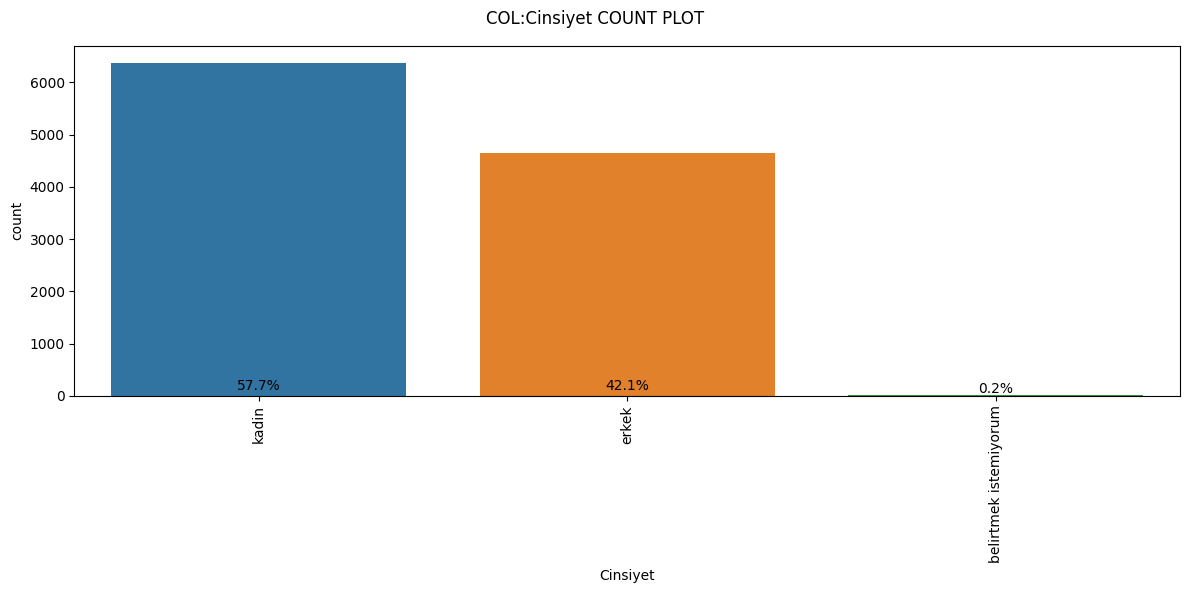

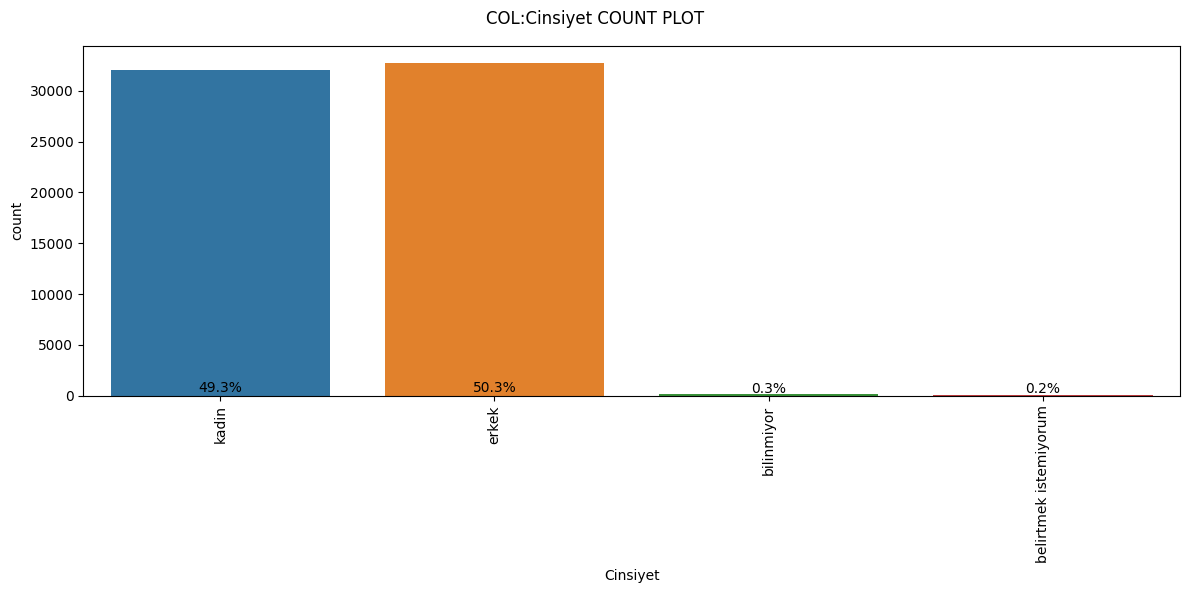

Processing for column: Dogum Yeri in training and test sets


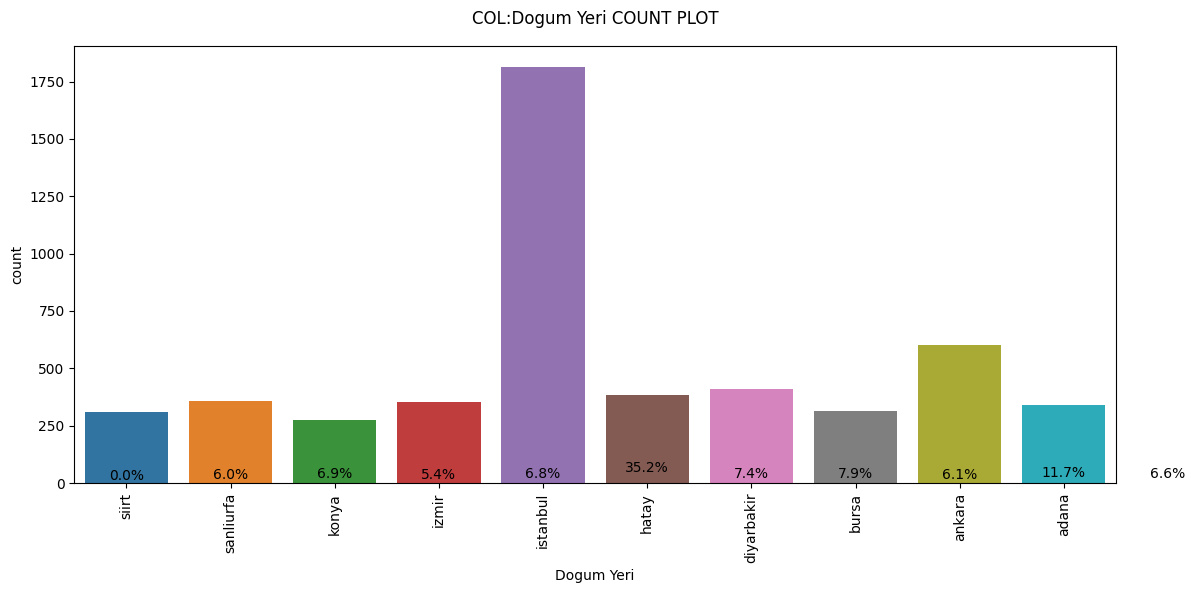

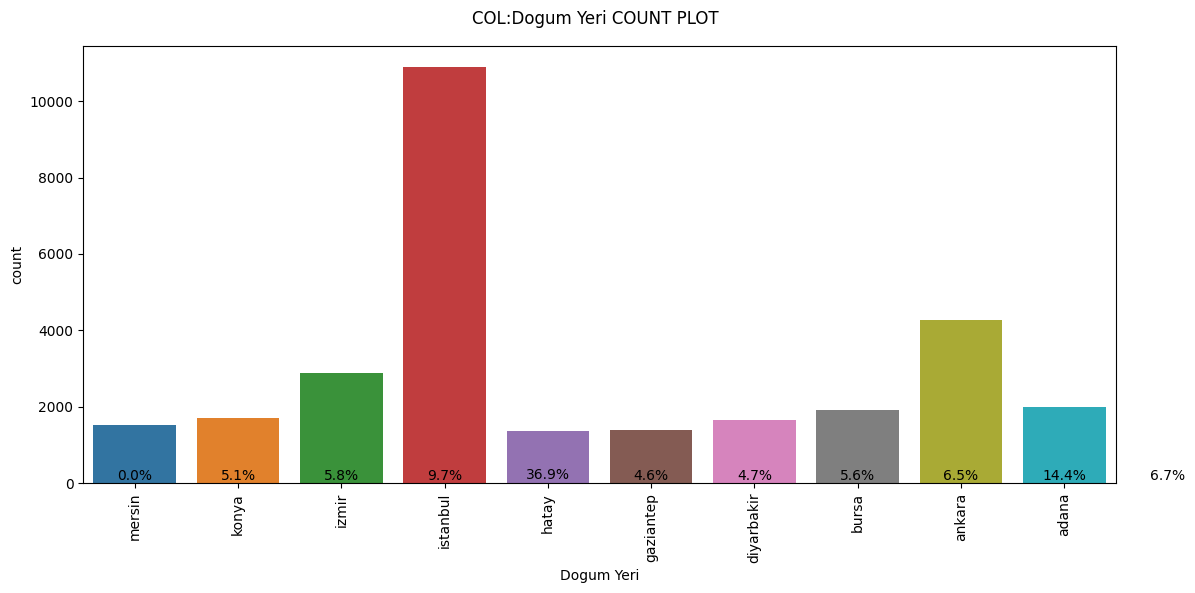

Processing for column: Ikametgah Sehri in training and test sets


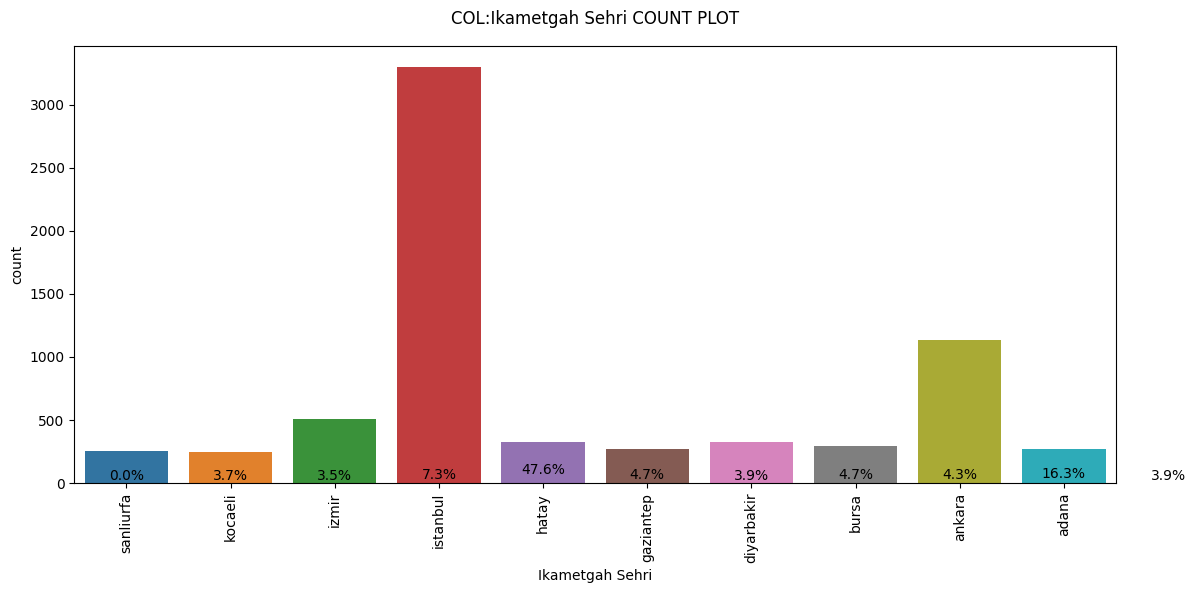

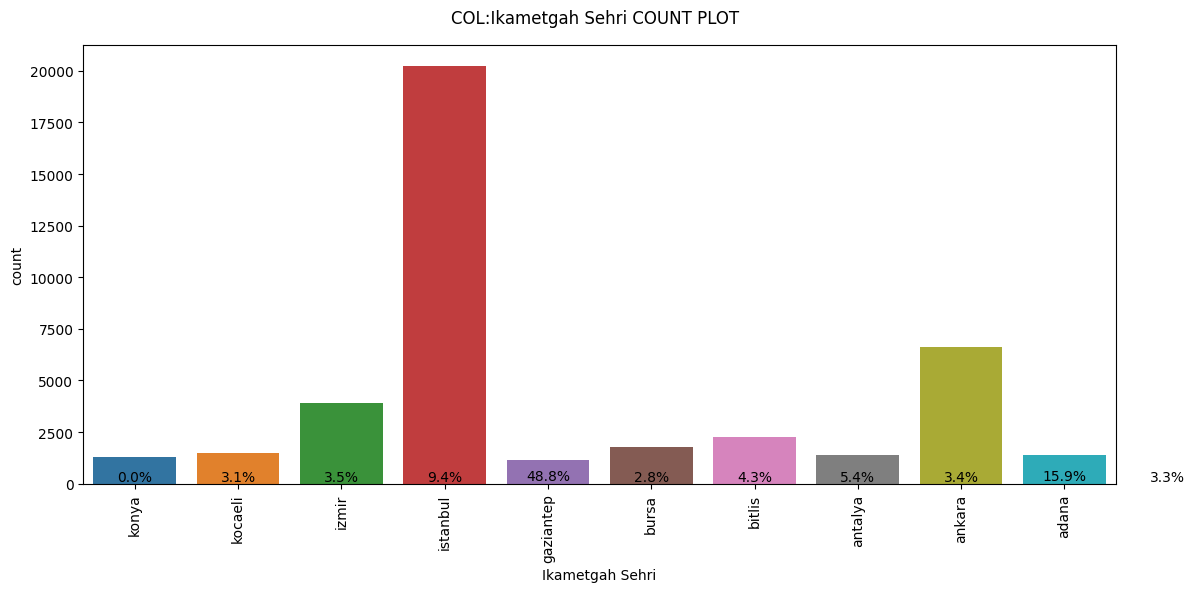

Processing for column: Universite Adi in training and test sets


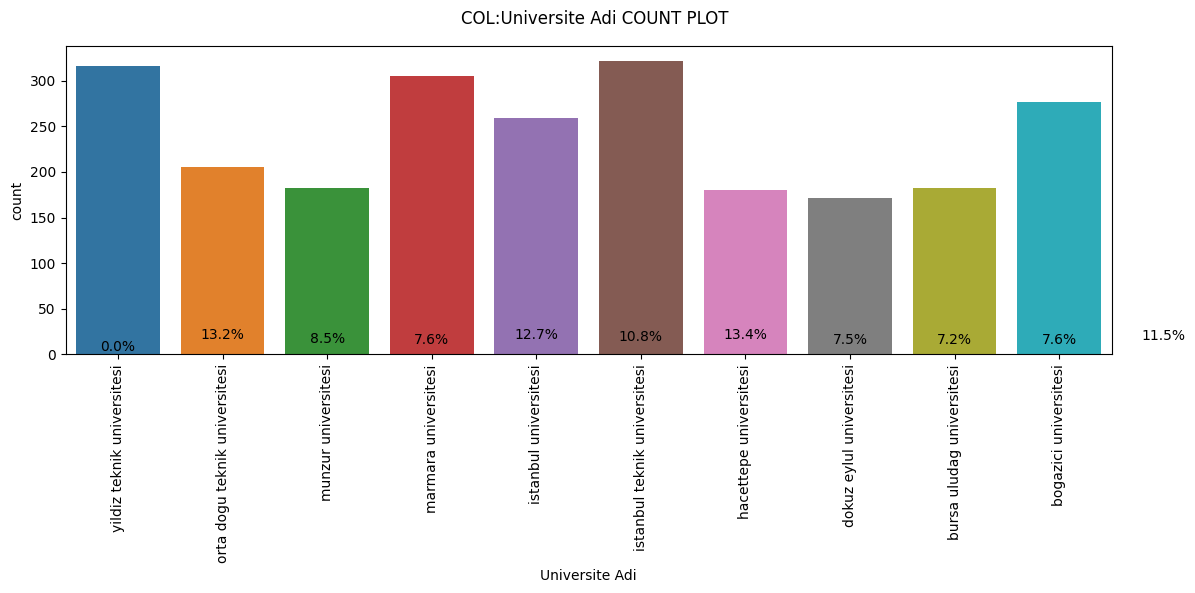

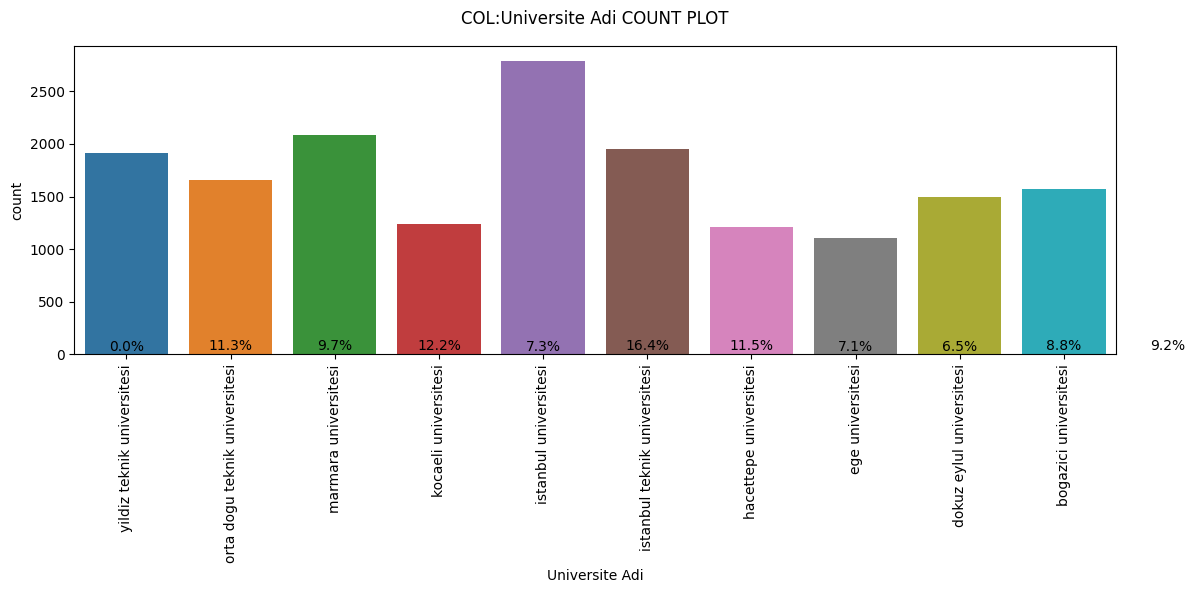

Processing for column: Universite Turu in training and test sets


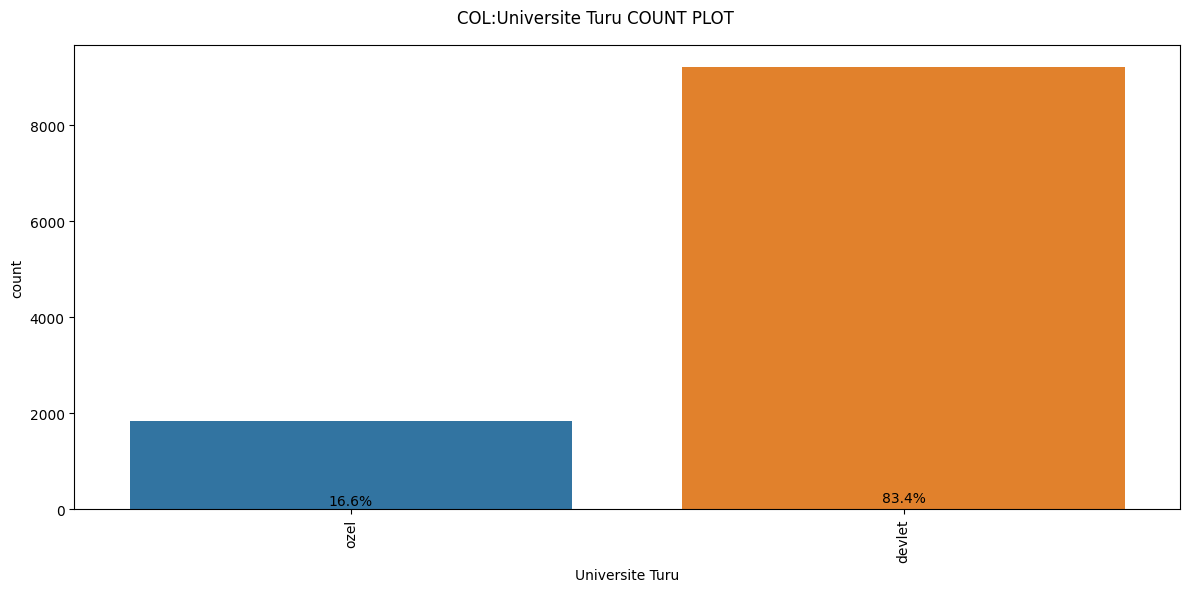

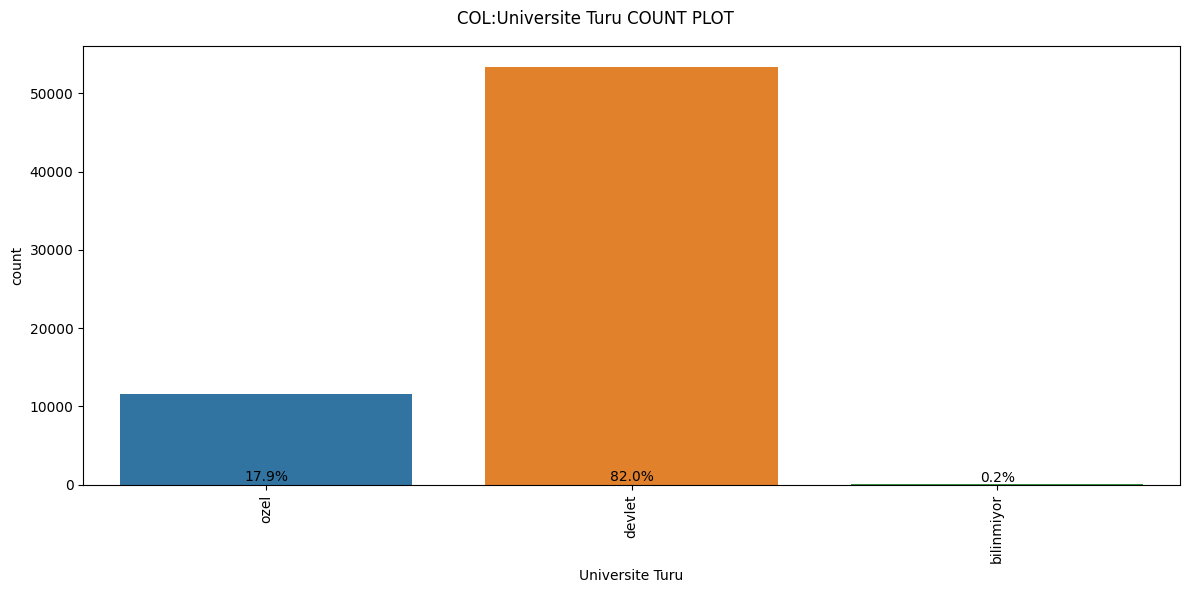

Processing for column: Burs Aliyor mu? in training and test sets


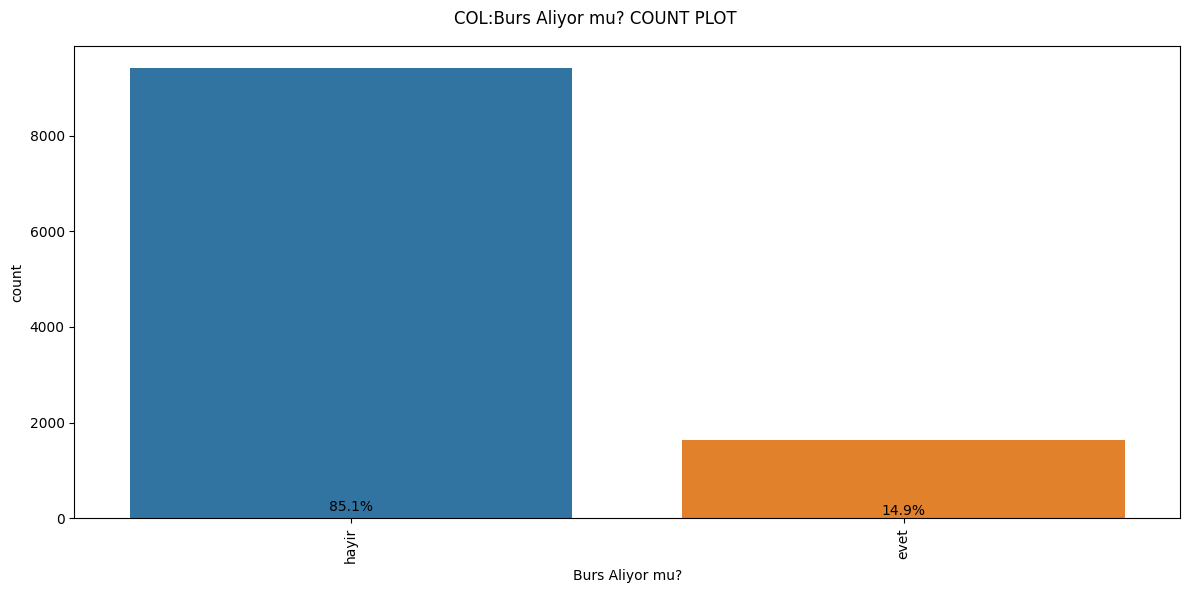

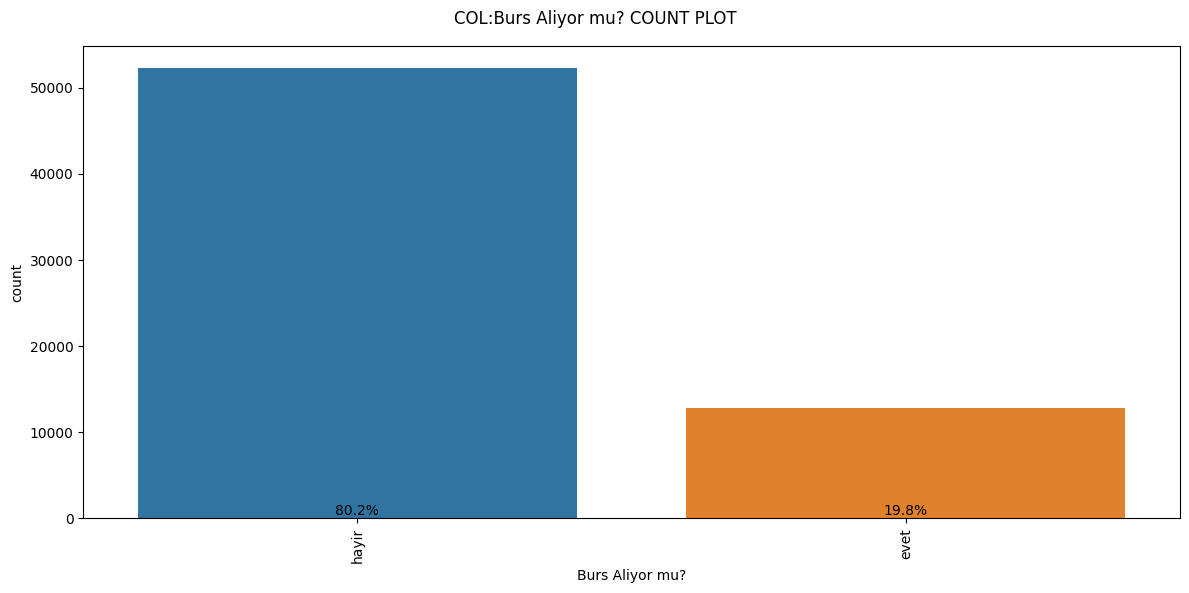

Processing for column: Bölüm in training and test sets


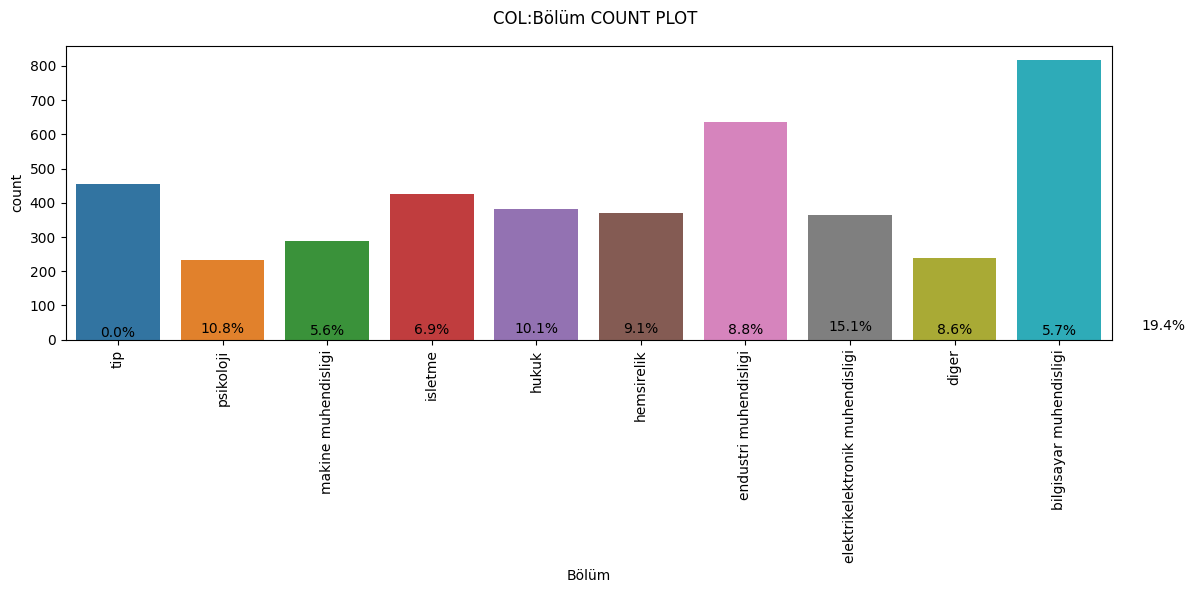

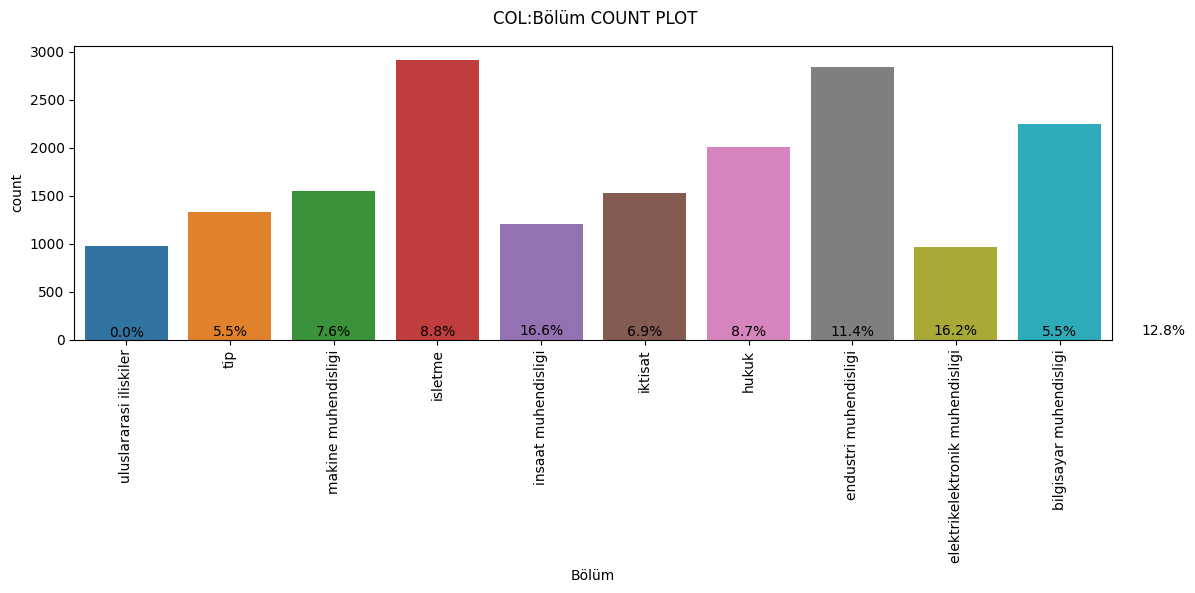

Processing for column: Universite Kacinci Sinif in training and test sets


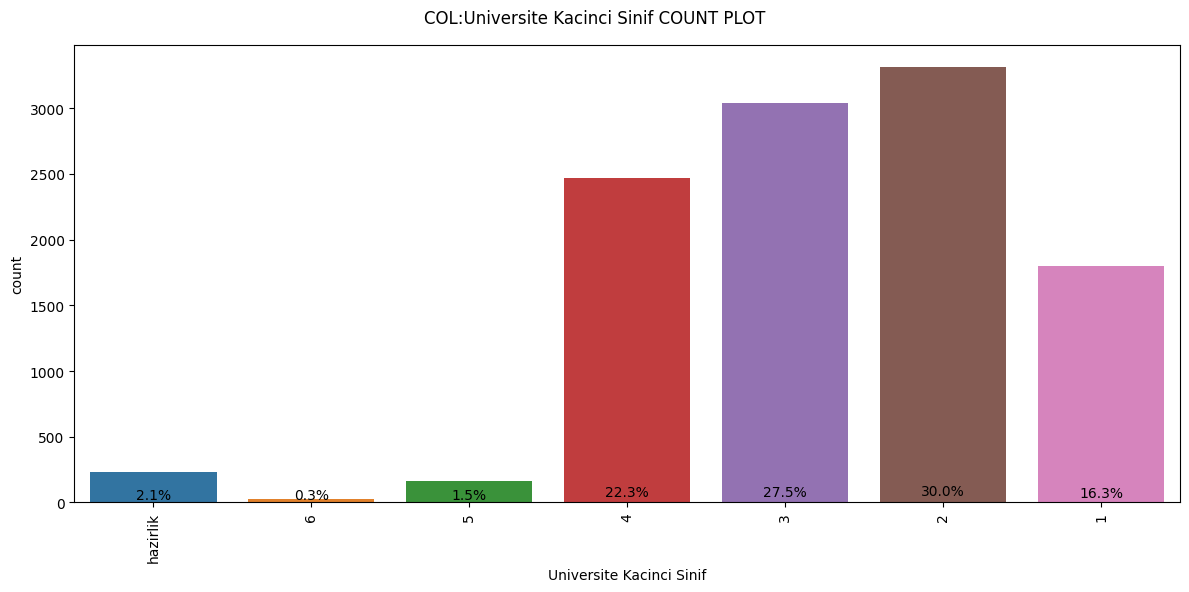

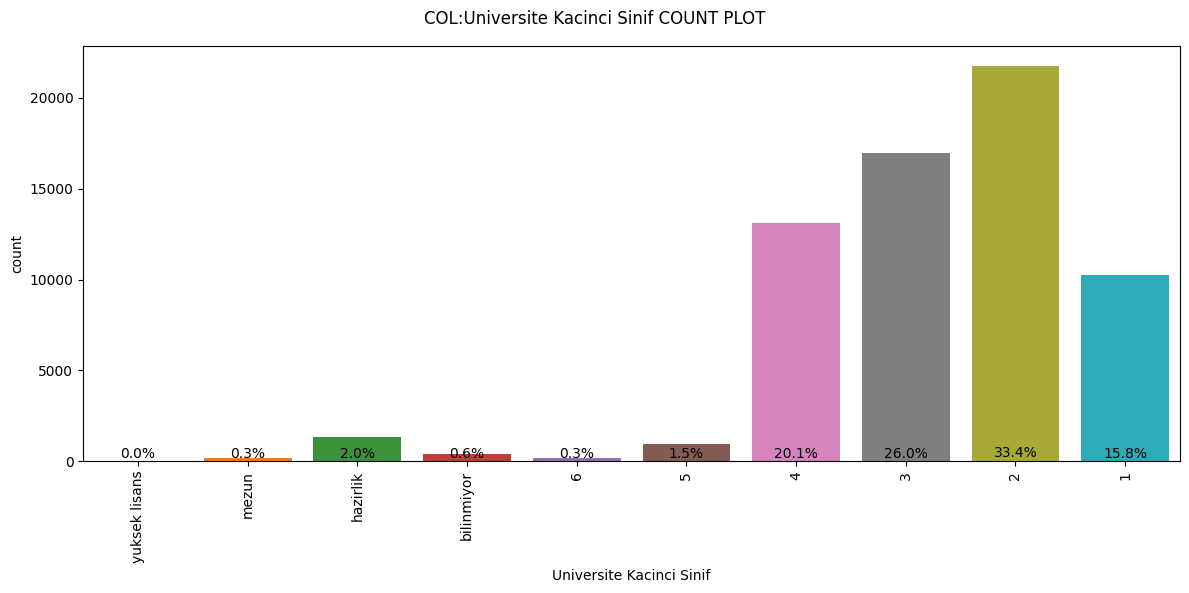

Processing for column: Universite Not Ortalamasi in training and test sets


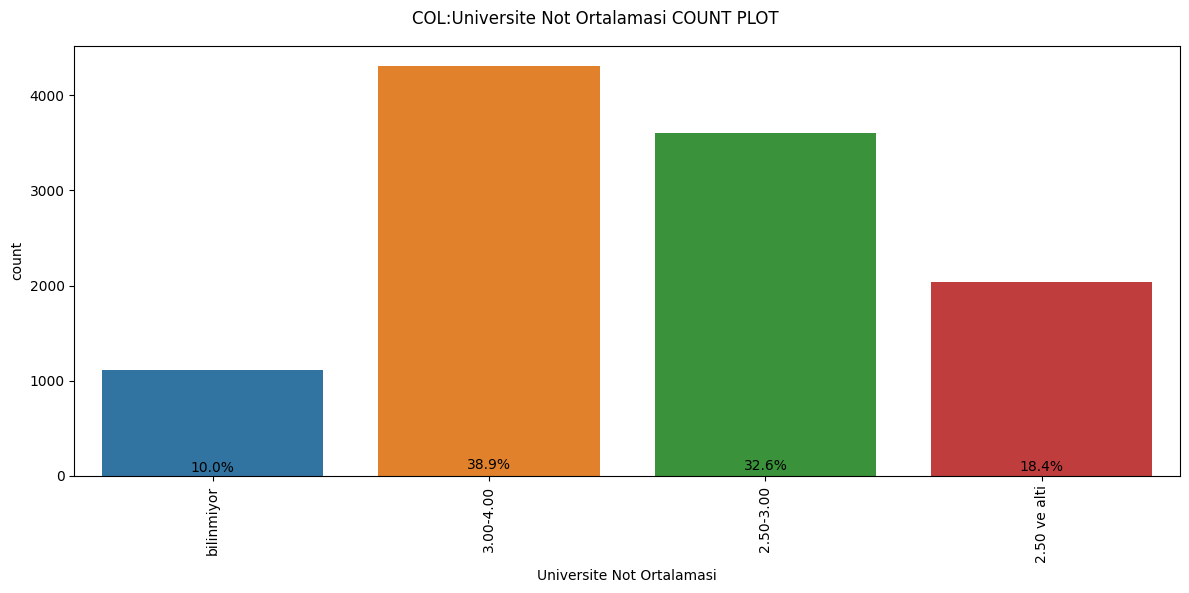

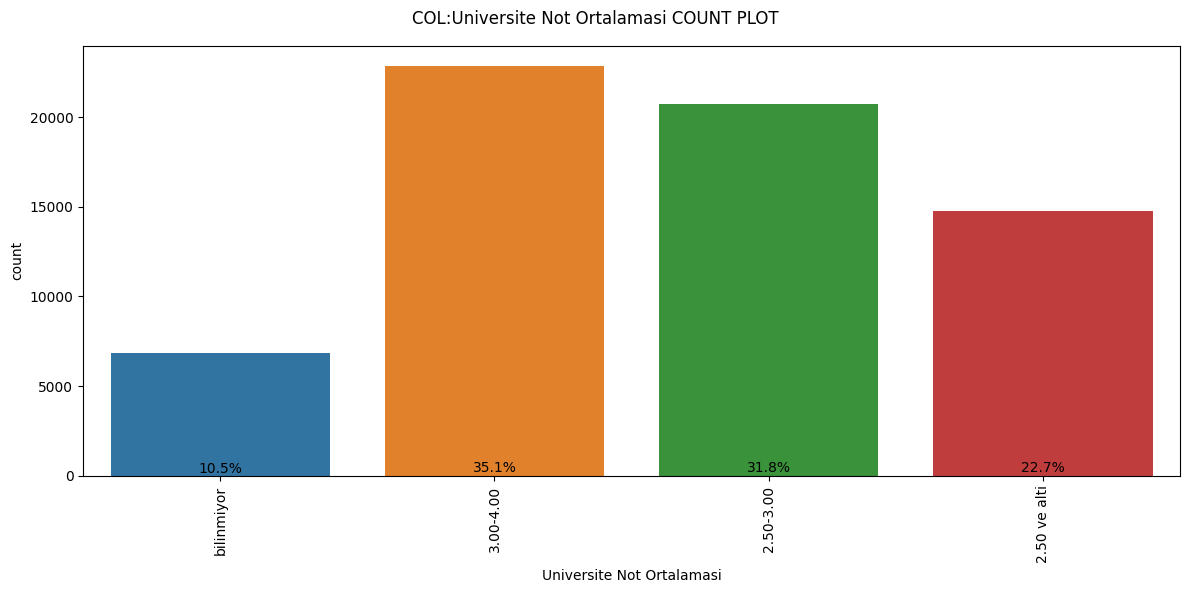

Processing for column: Lise Adi Yeni in training and test sets


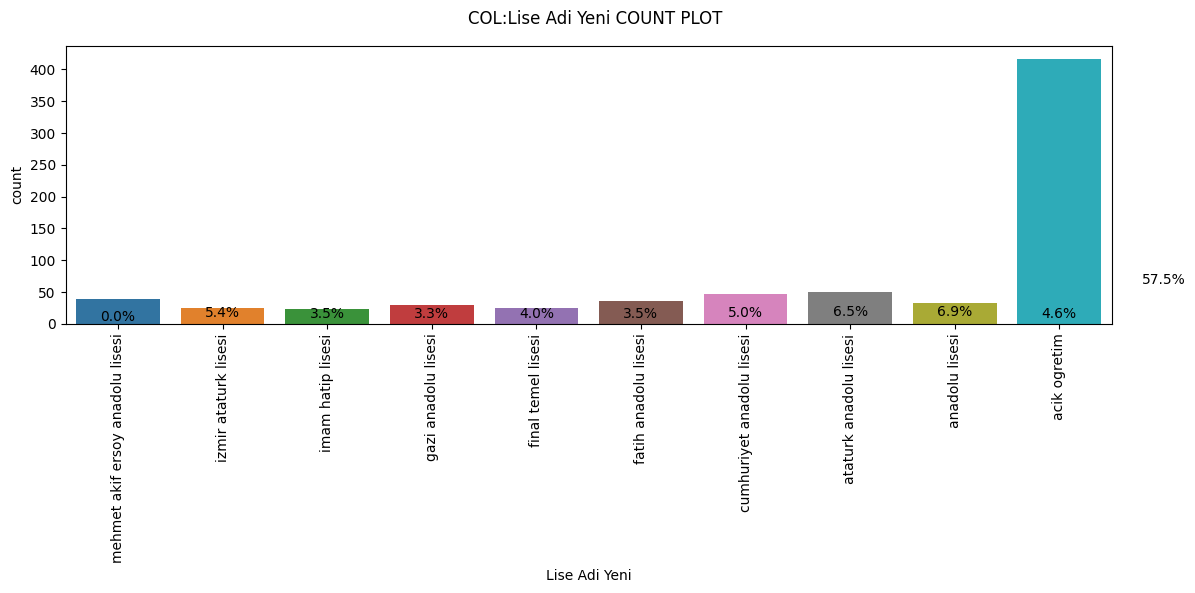

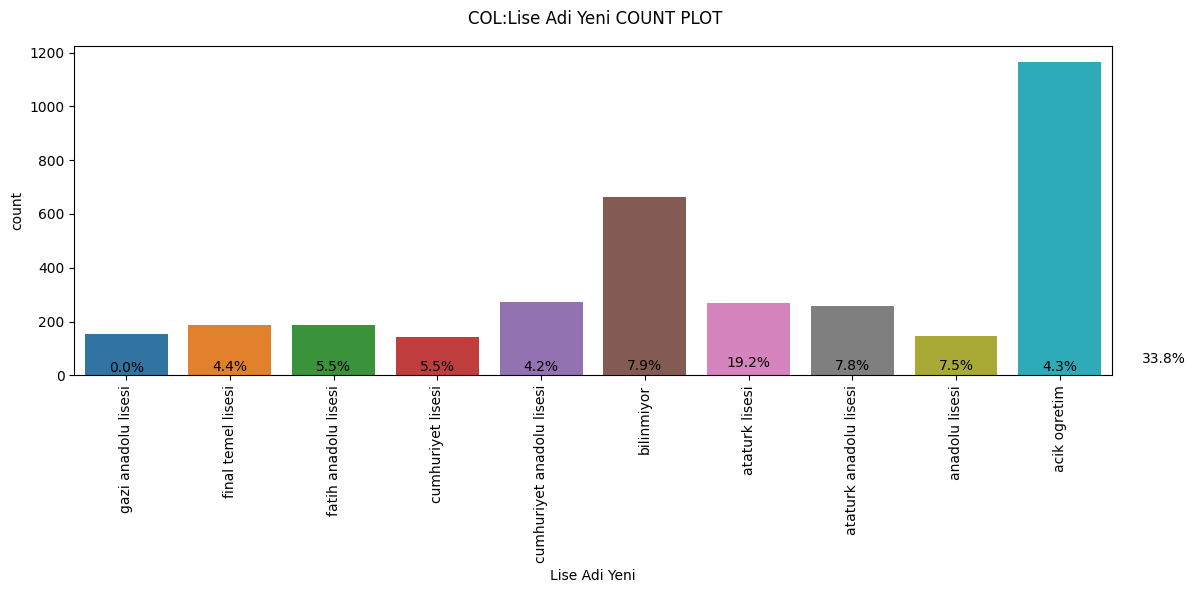

Processing for column: Lise Sehir in training and test sets


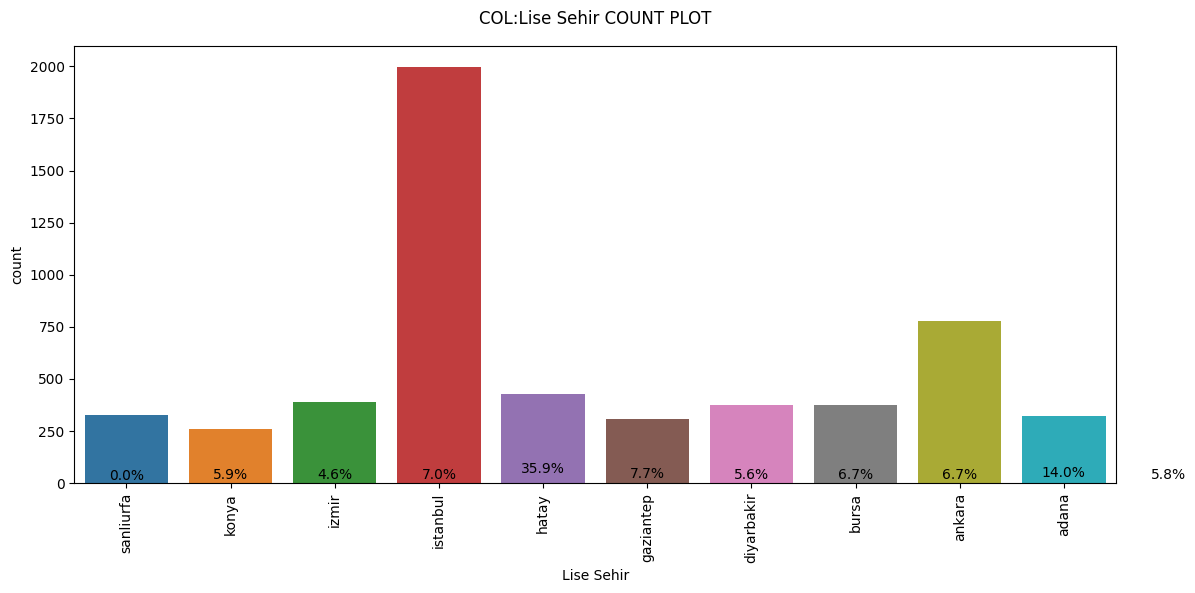

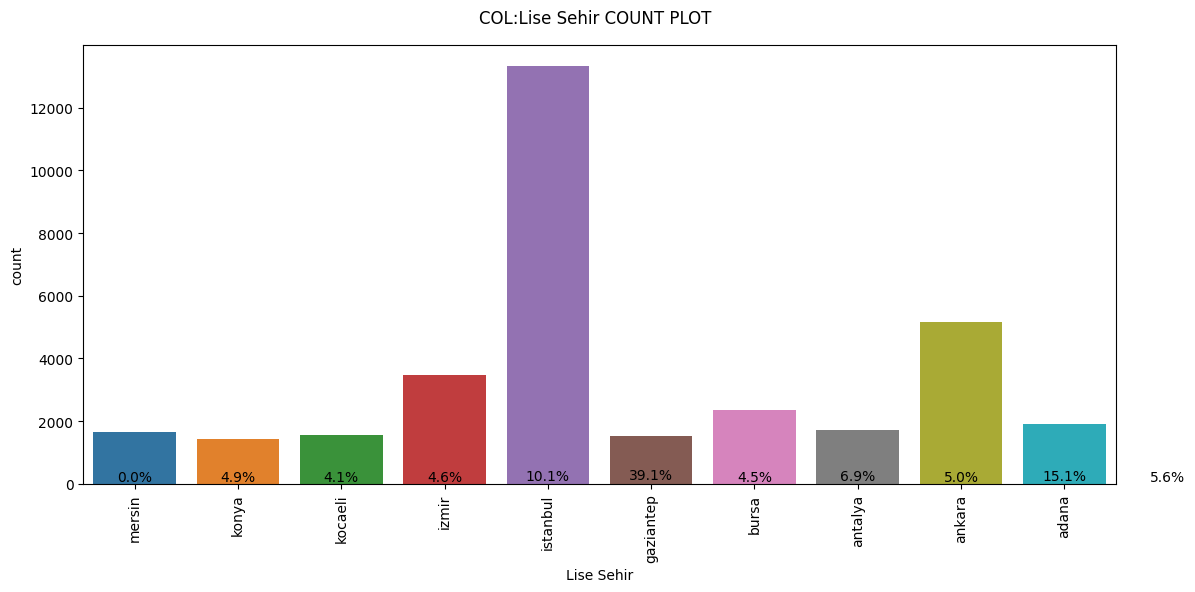

Processing for column: Lise Turu in training and test sets


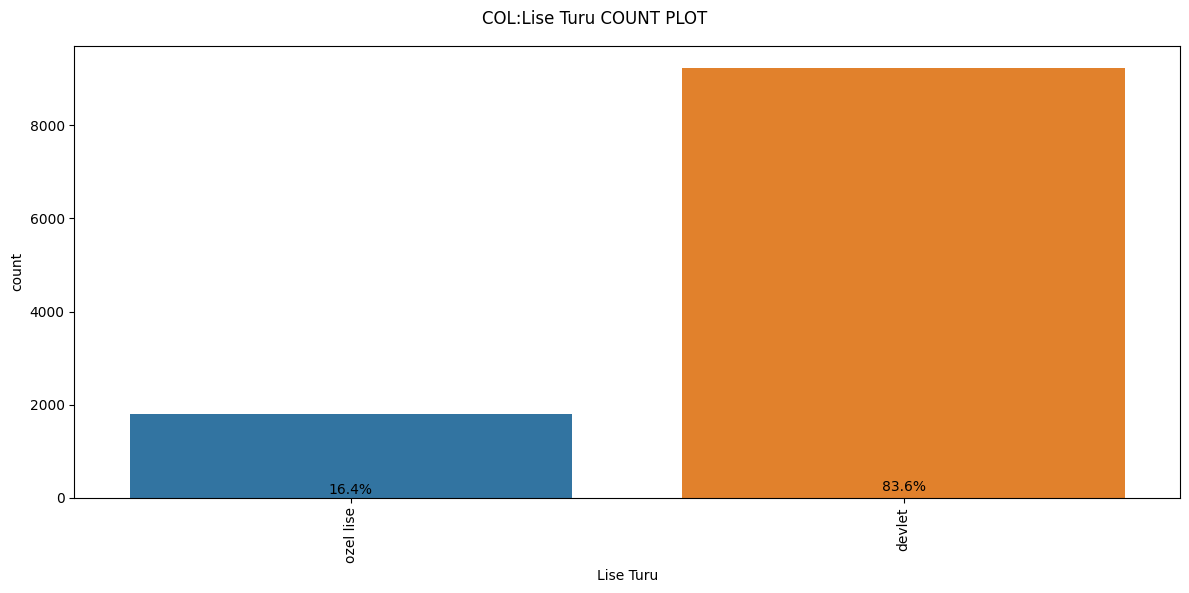

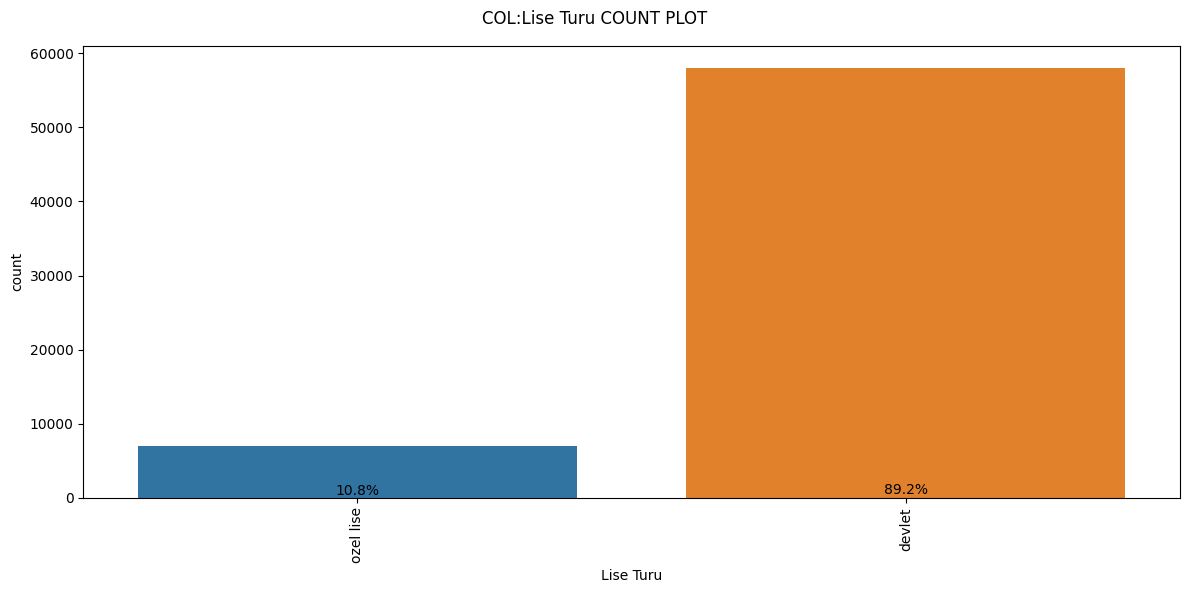

Processing for column: Baba_Calisma_Durumu in training and test sets


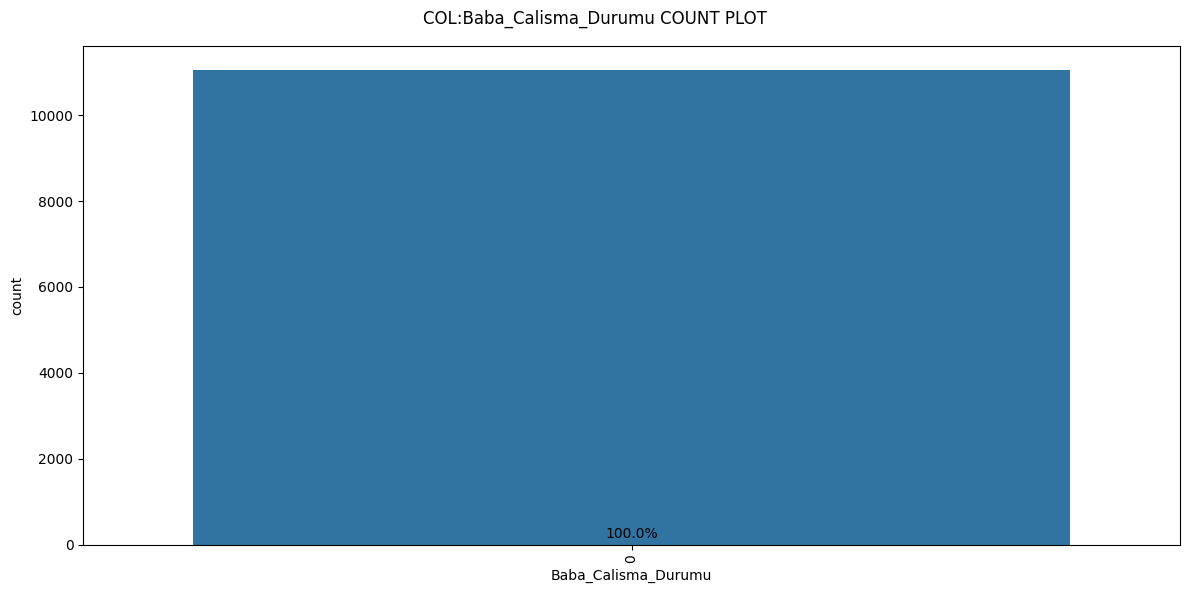

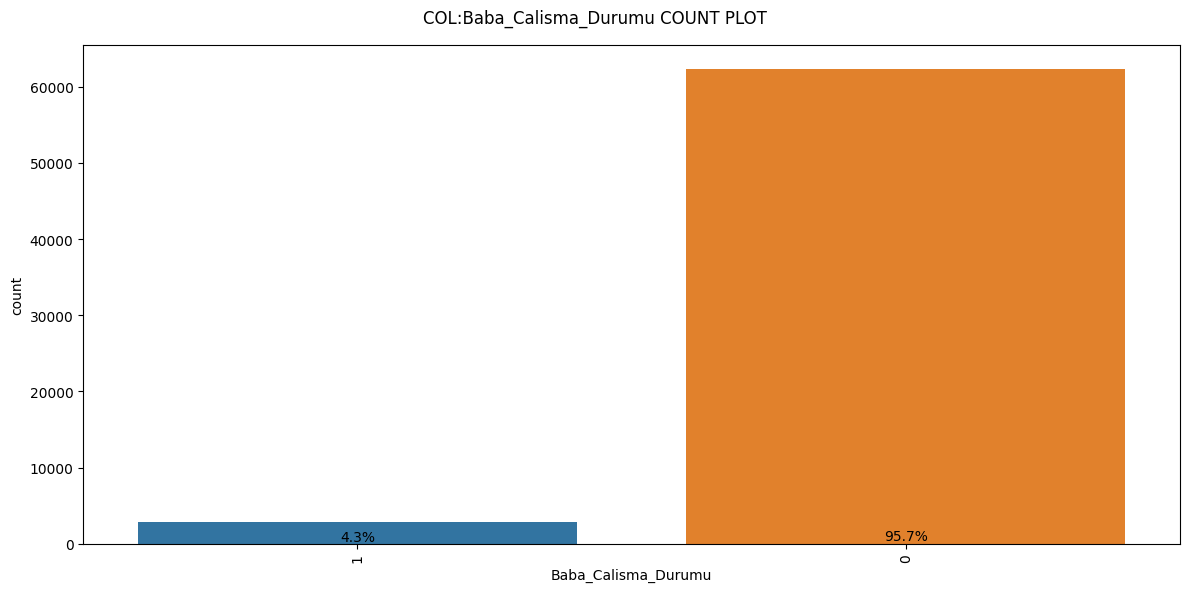

Processing for column: Lise Bolumu in training and test sets


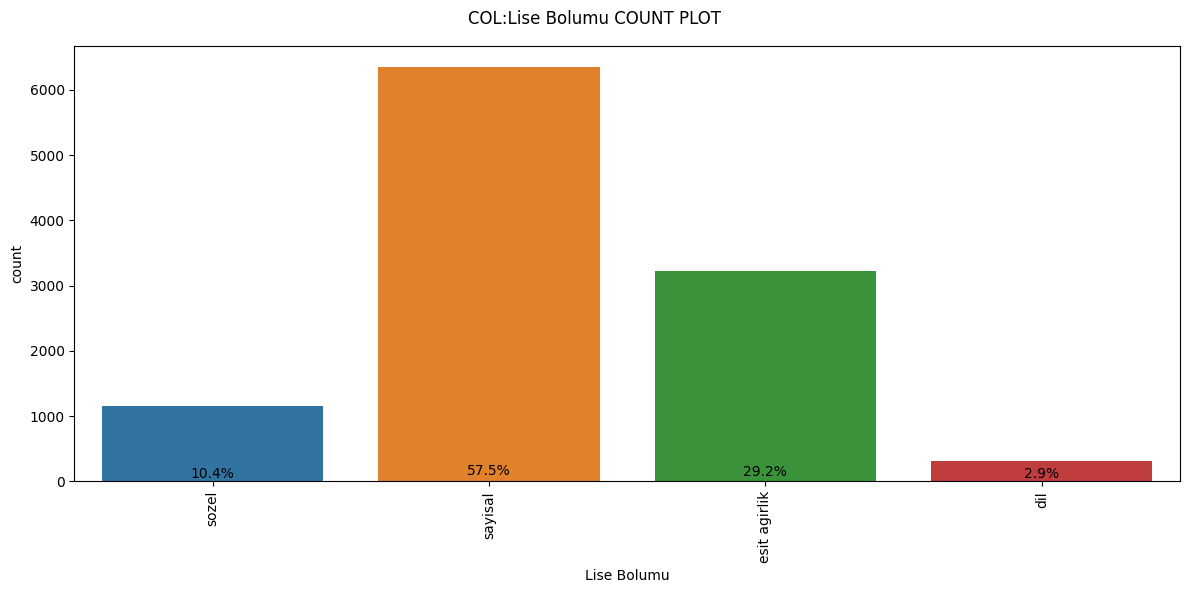

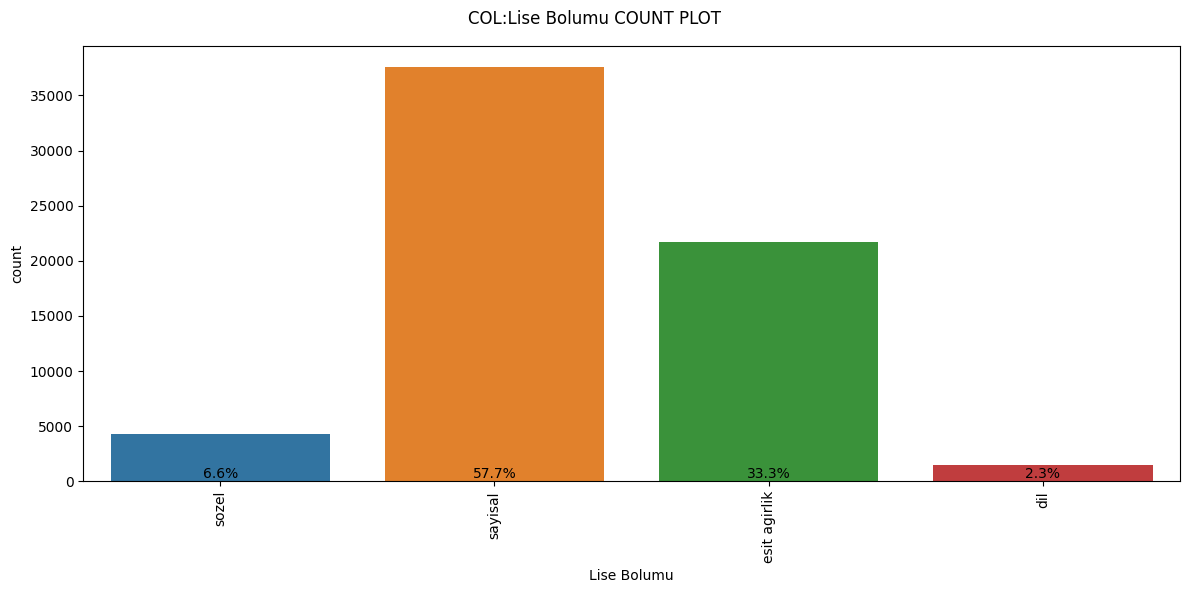

Processing for column: Lise Mezuniyet Notu in training and test sets


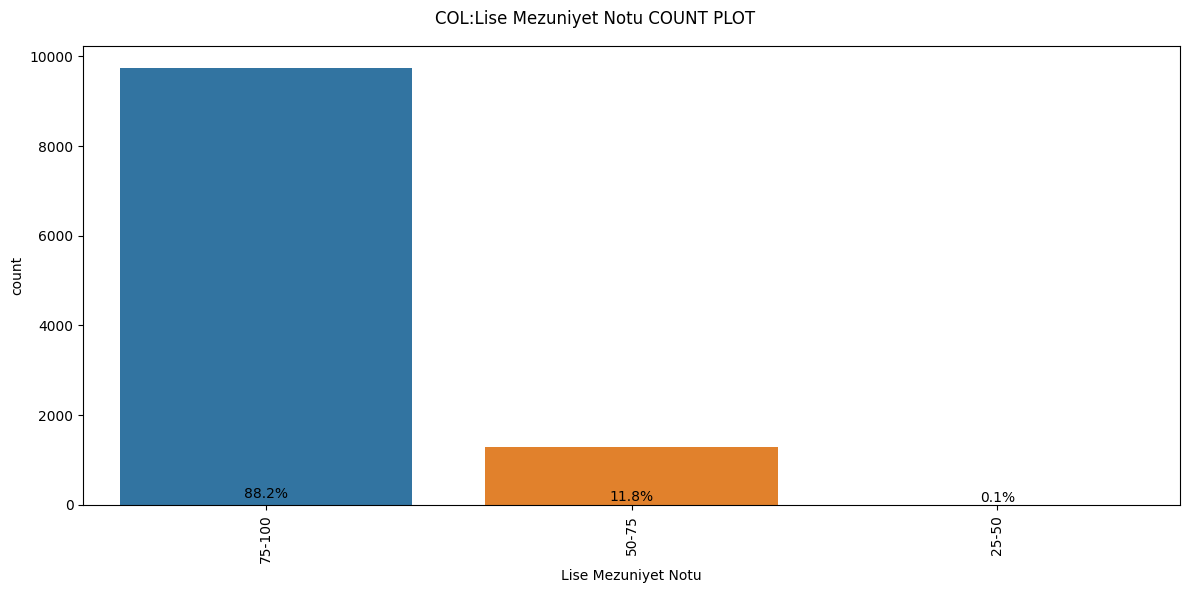

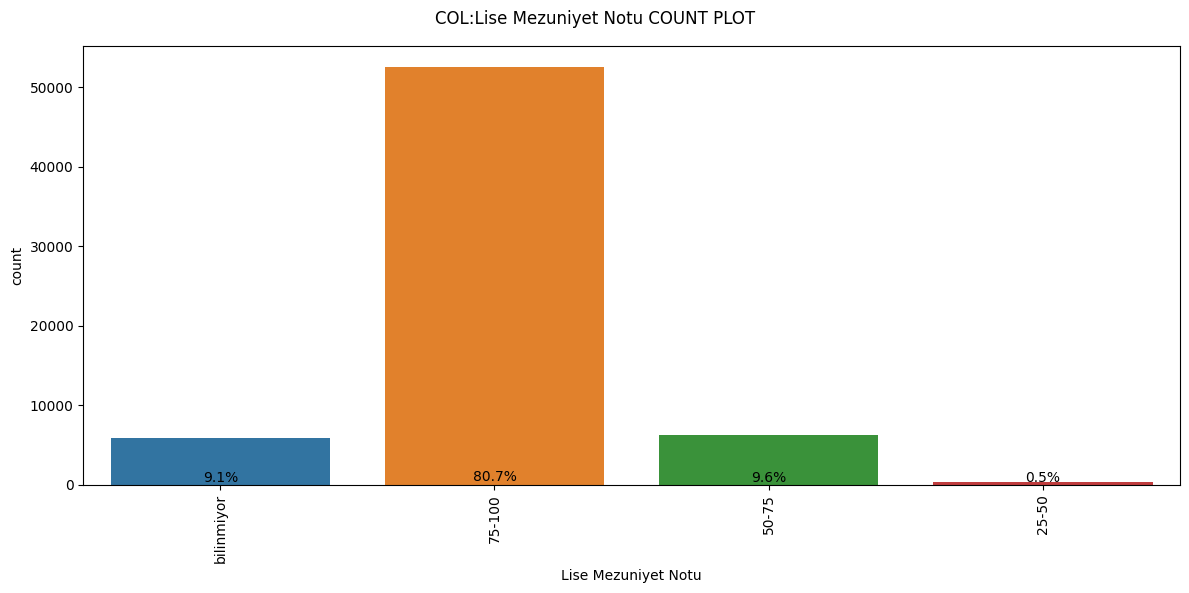

Processing for column: Baska Bir Kurumdan Burs Aliyor mu? in training and test sets


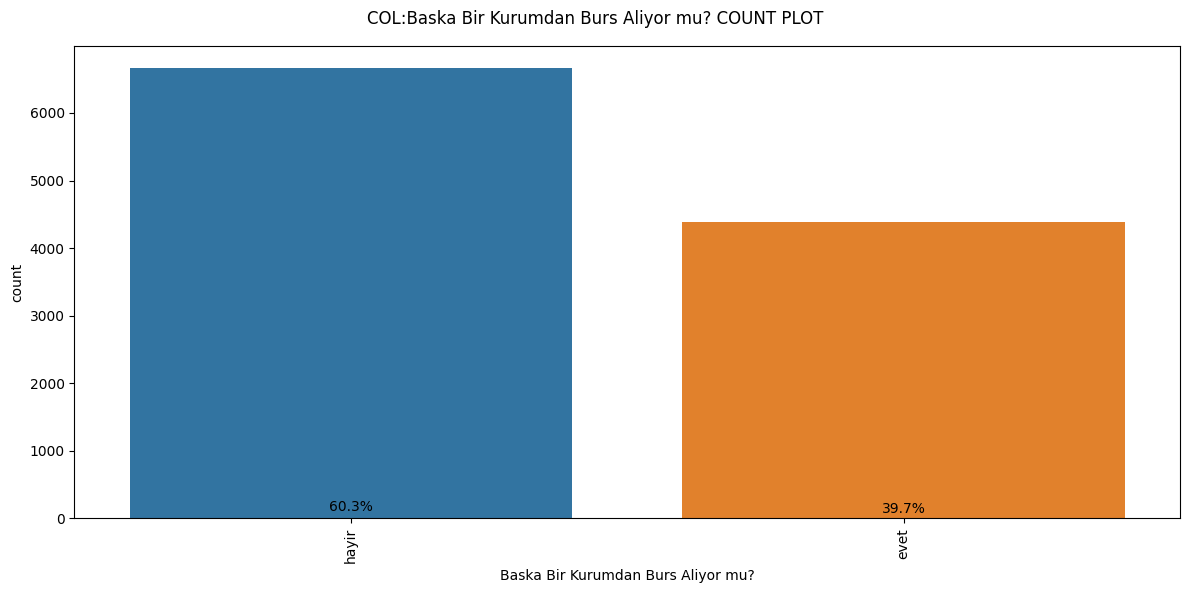

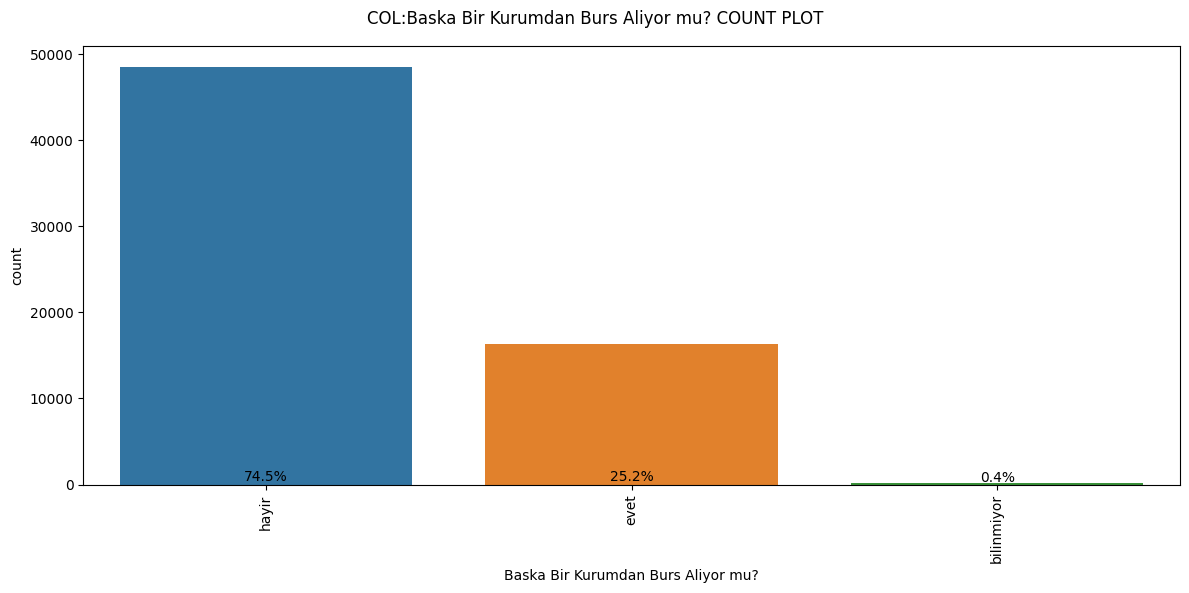

Processing for column: Burs Aldigi Baska Kurum in training and test sets


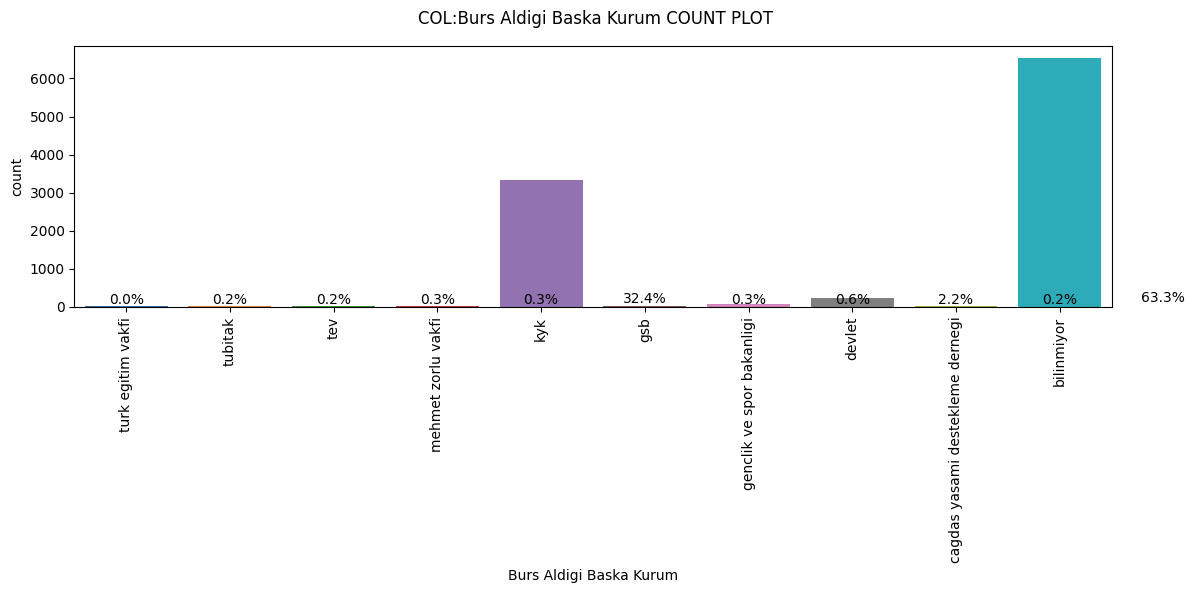

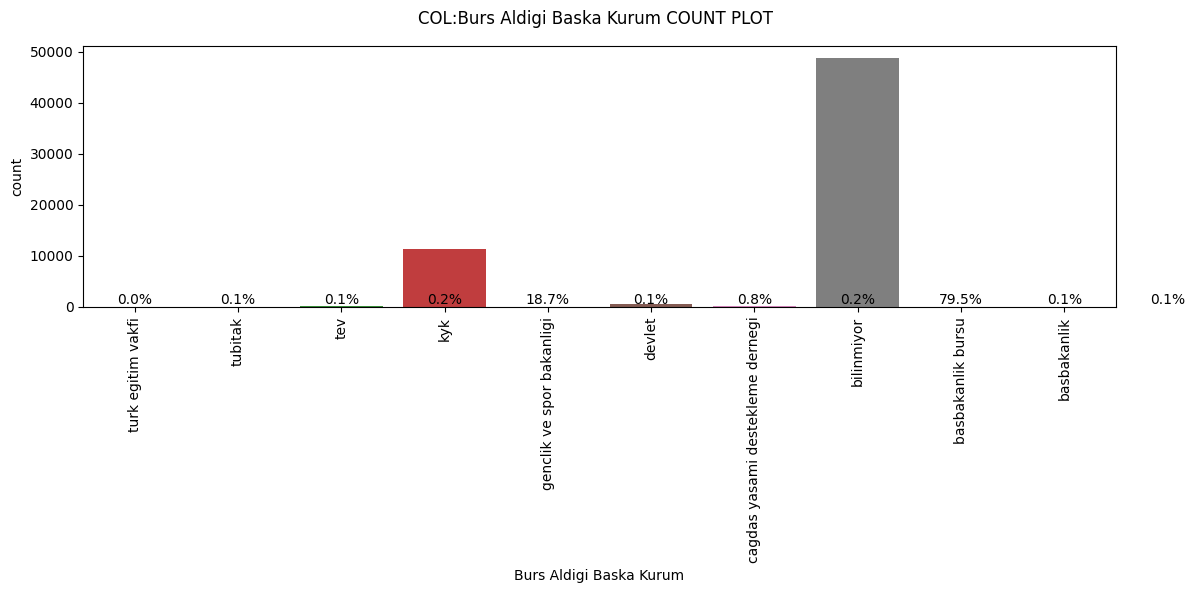

Processing for column: Anne Egitim Durumu in training and test sets


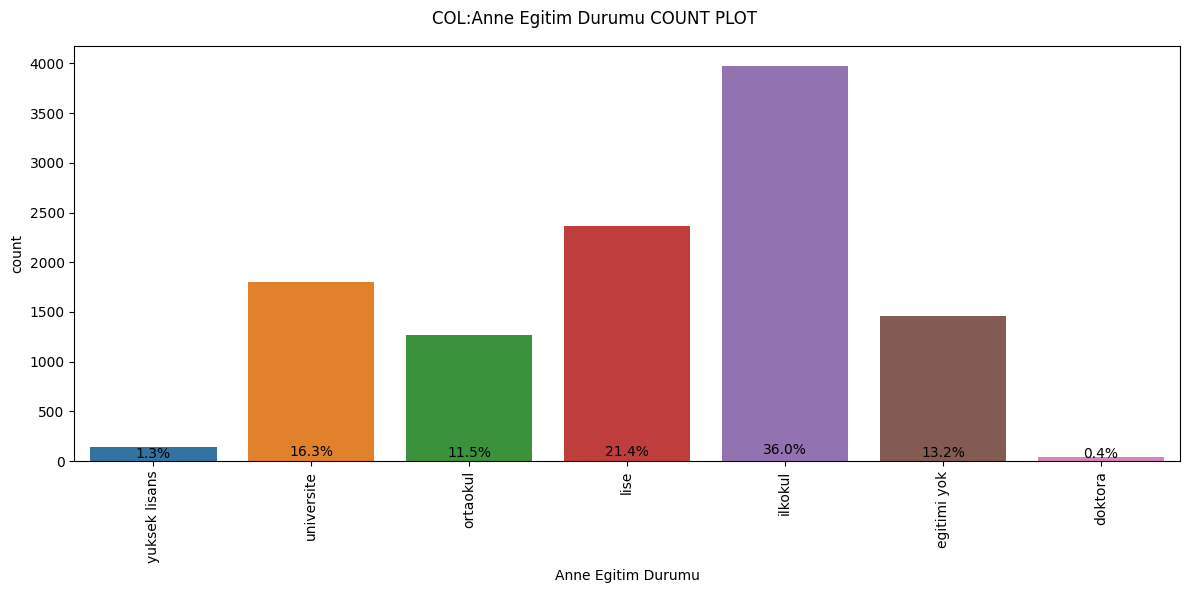

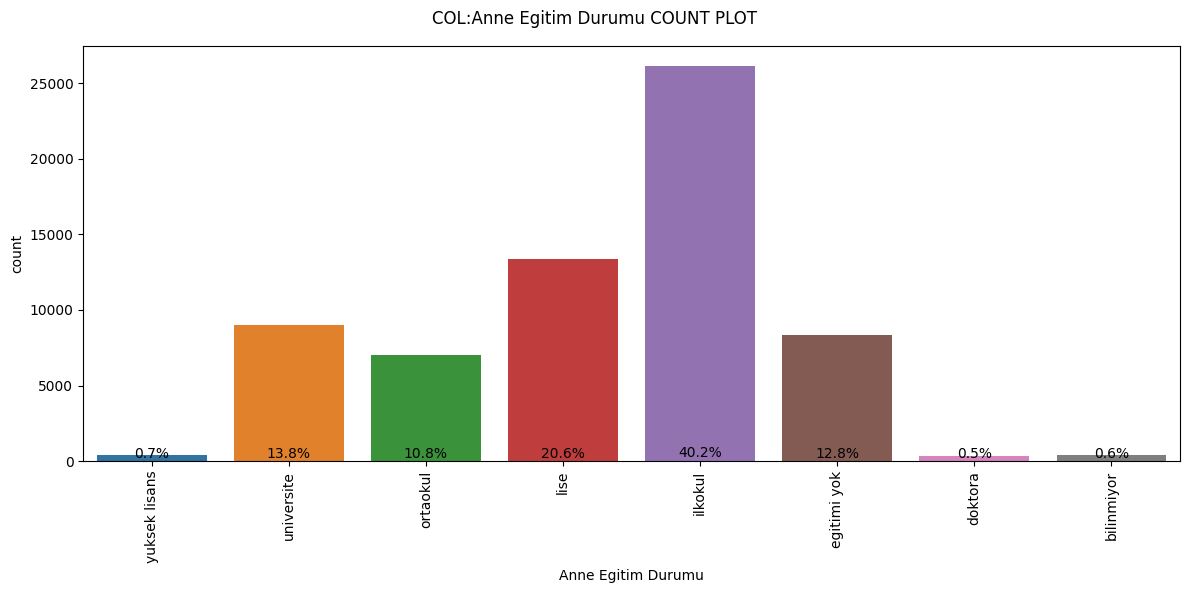

Processing for column: Anne Calisma Durumu in training and test sets


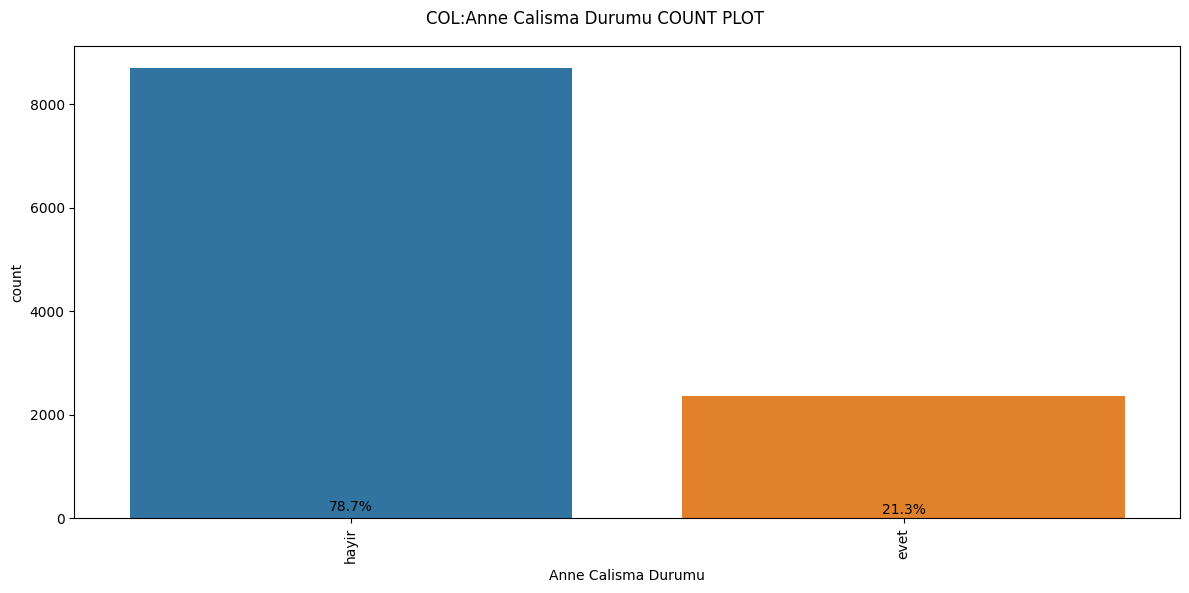

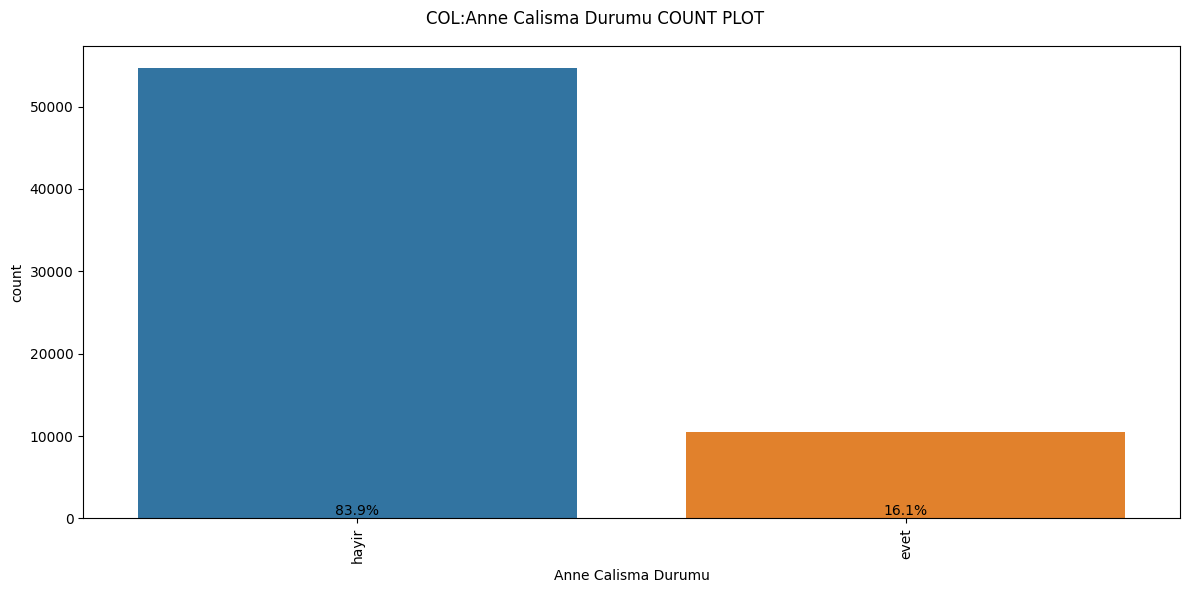

Processing for column: Anne Sektor in training and test sets


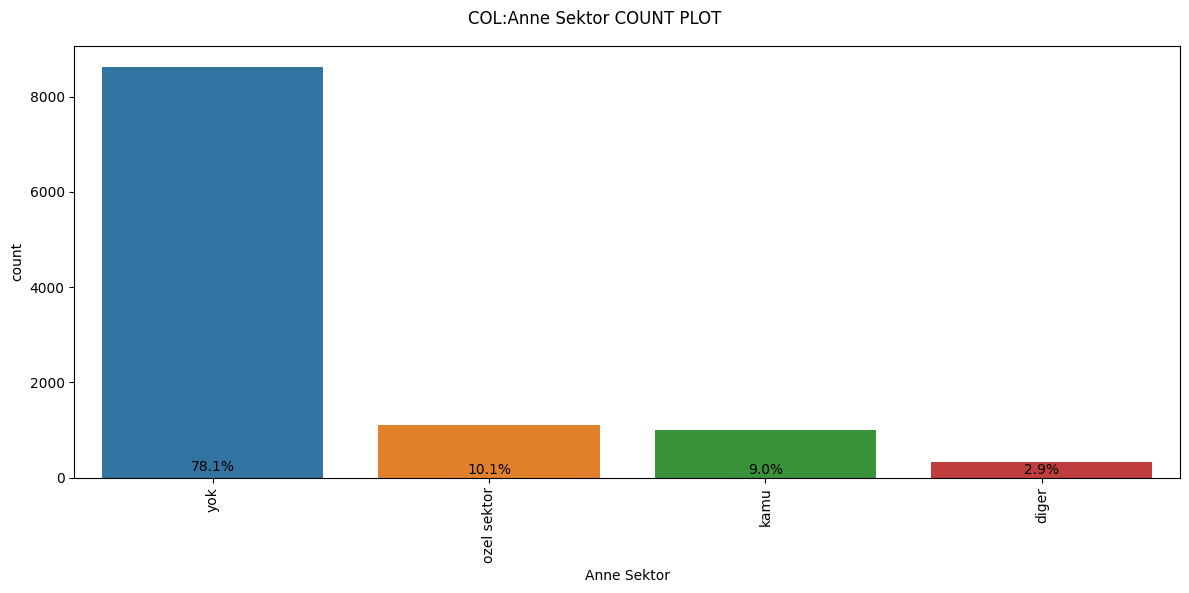

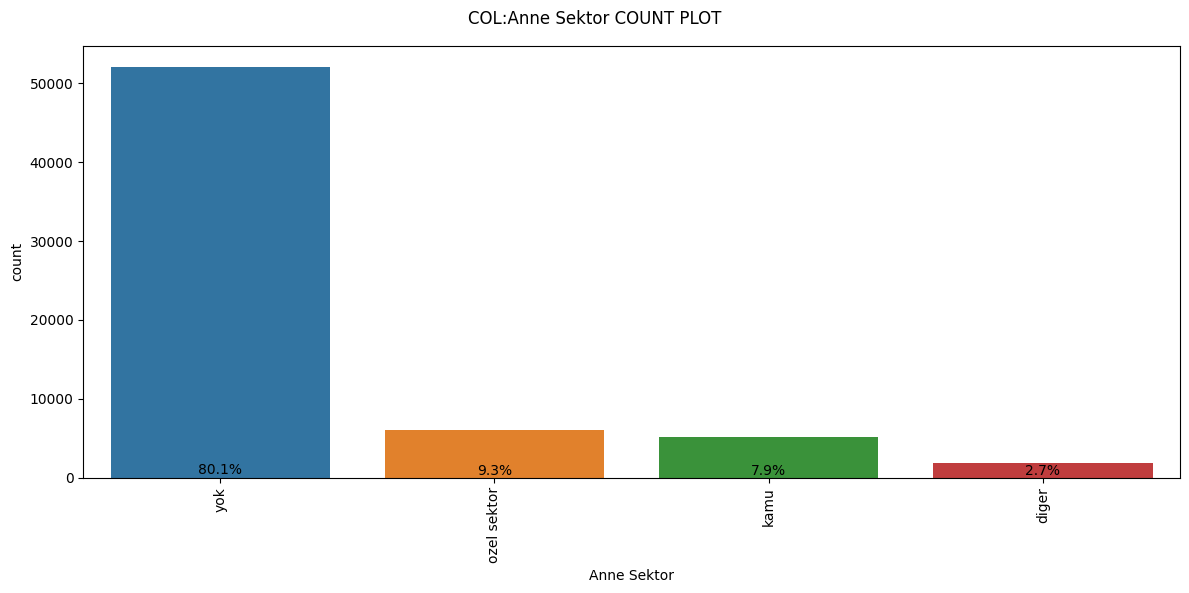

Processing for column: Baba Egitim Durumu in training and test sets


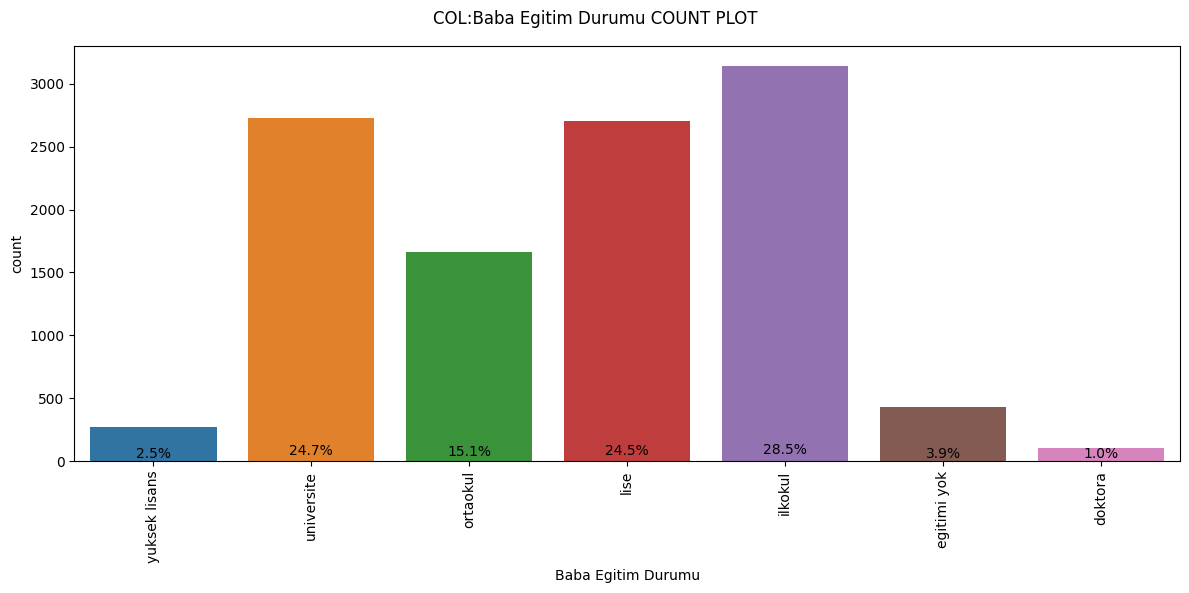

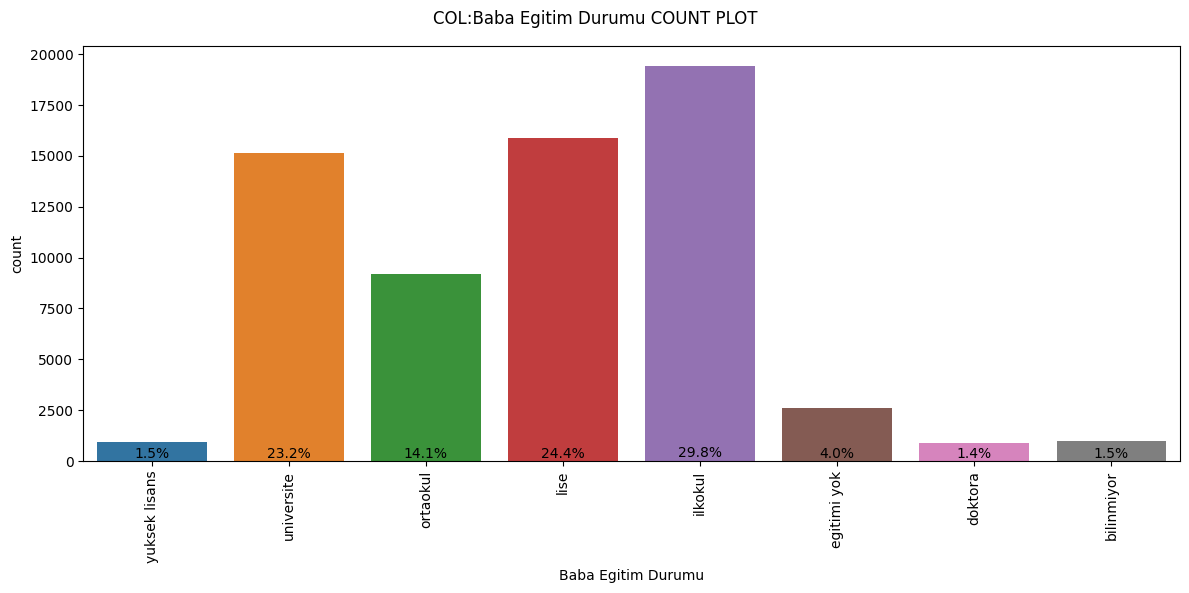

Processing for column: Baba Calisma Durumu in training and test sets


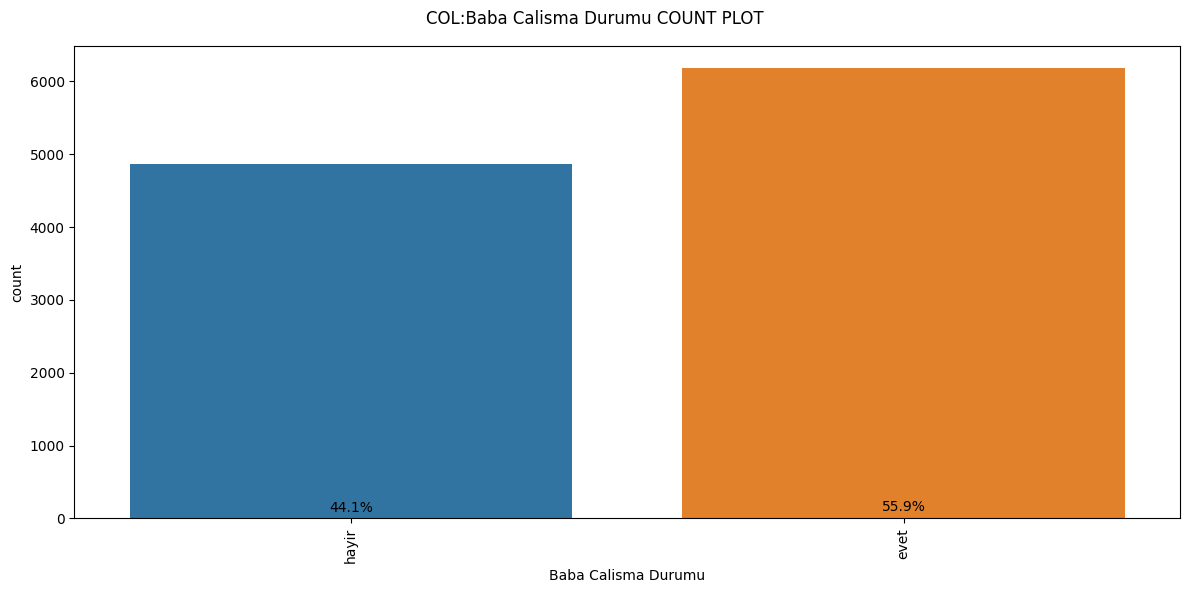

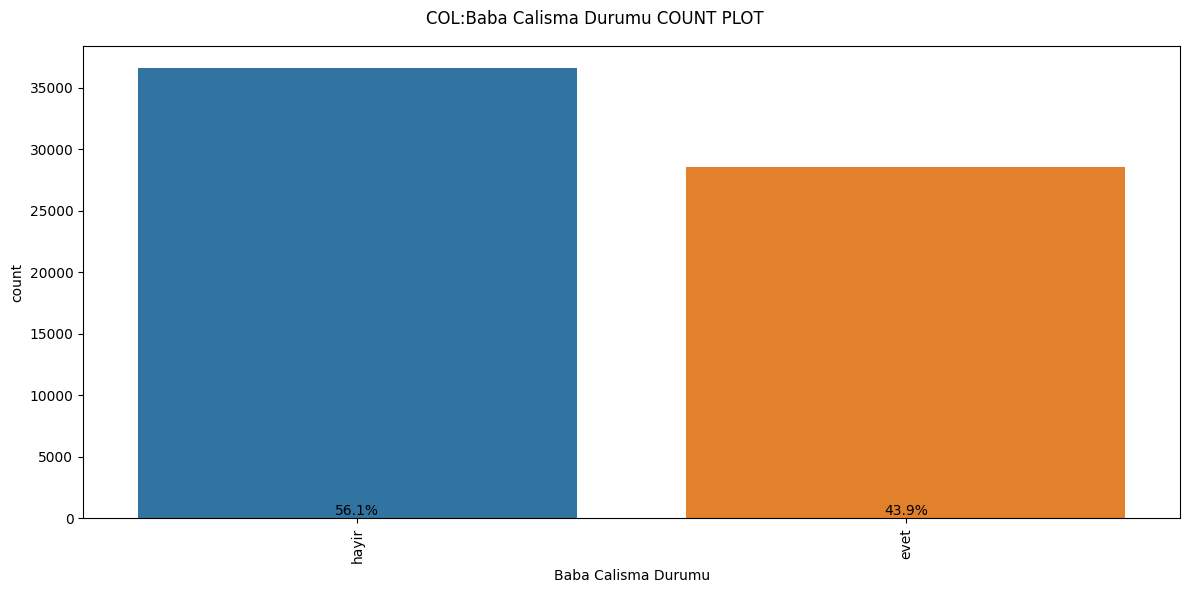

Processing for column: Baba Sektor in training and test sets


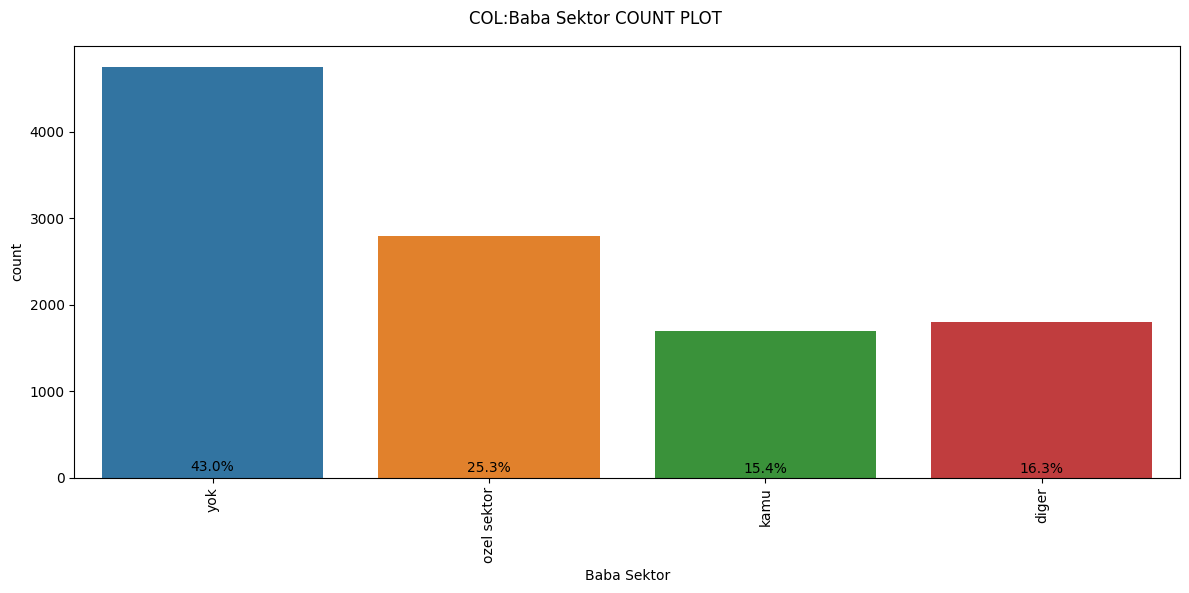

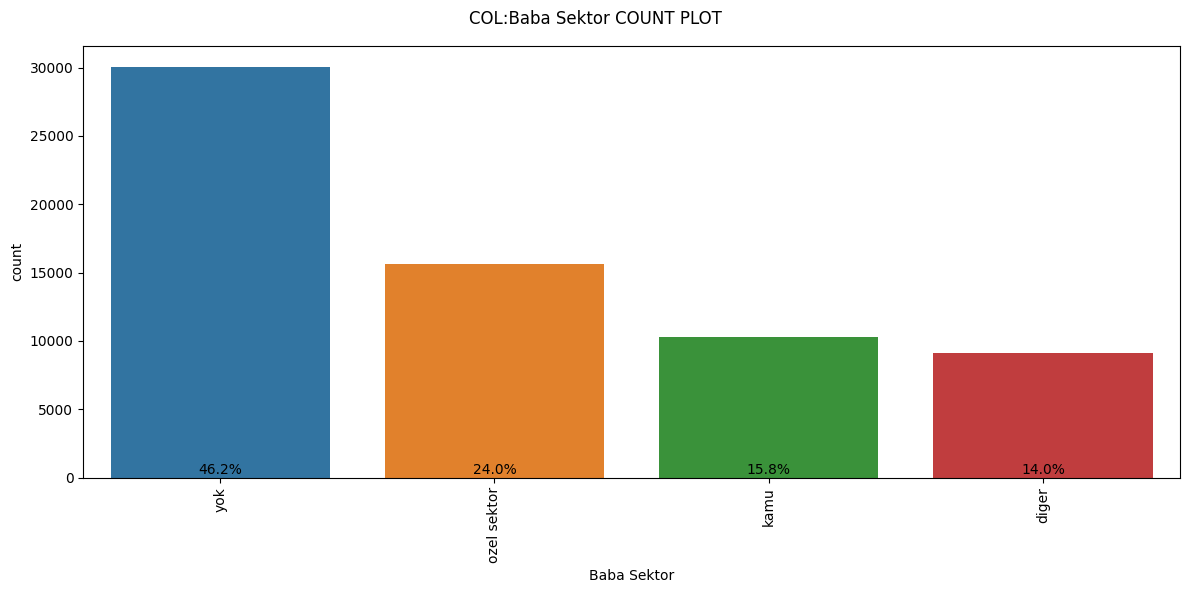

Processing for column: Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz? in training and test sets


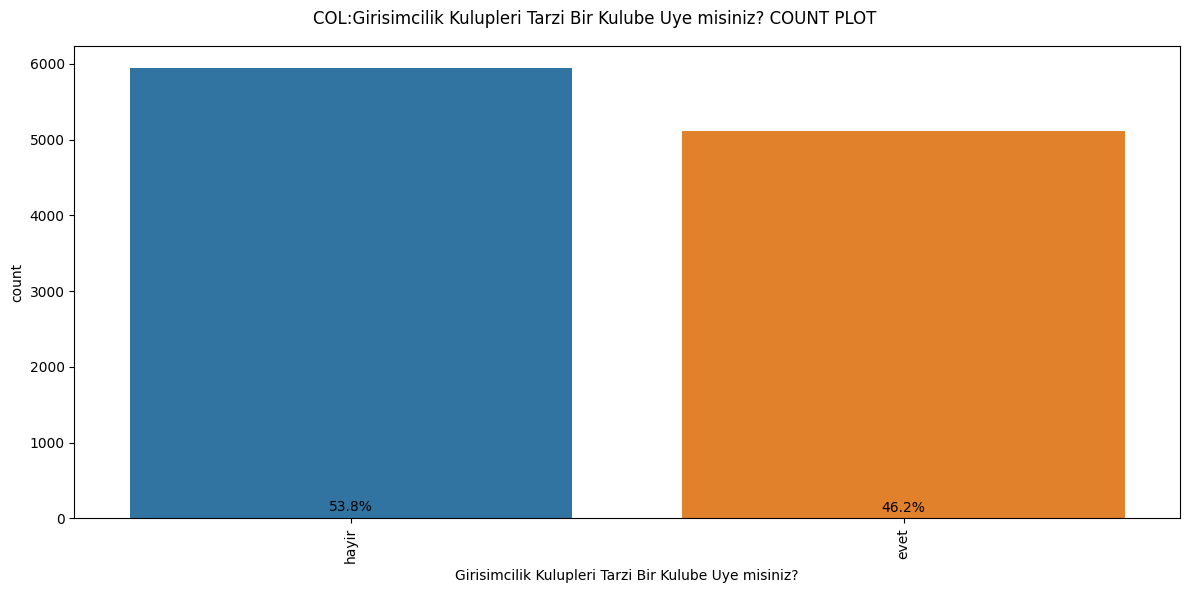

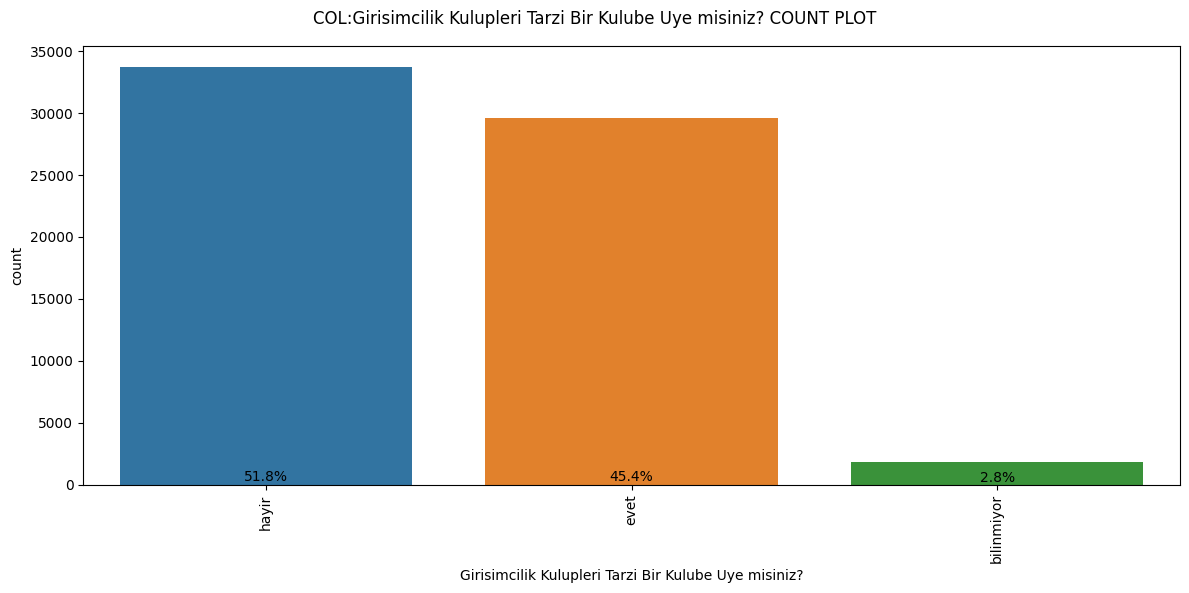

Processing for column: Profesyonel Bir Spor Daliyla Mesgul musunuz? in training and test sets


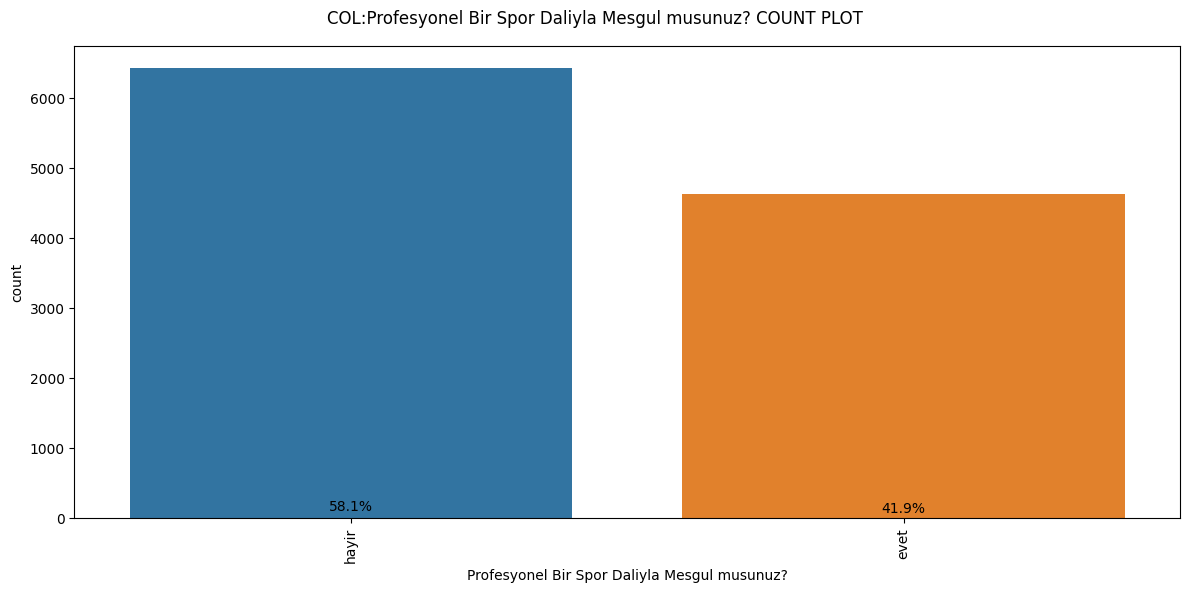

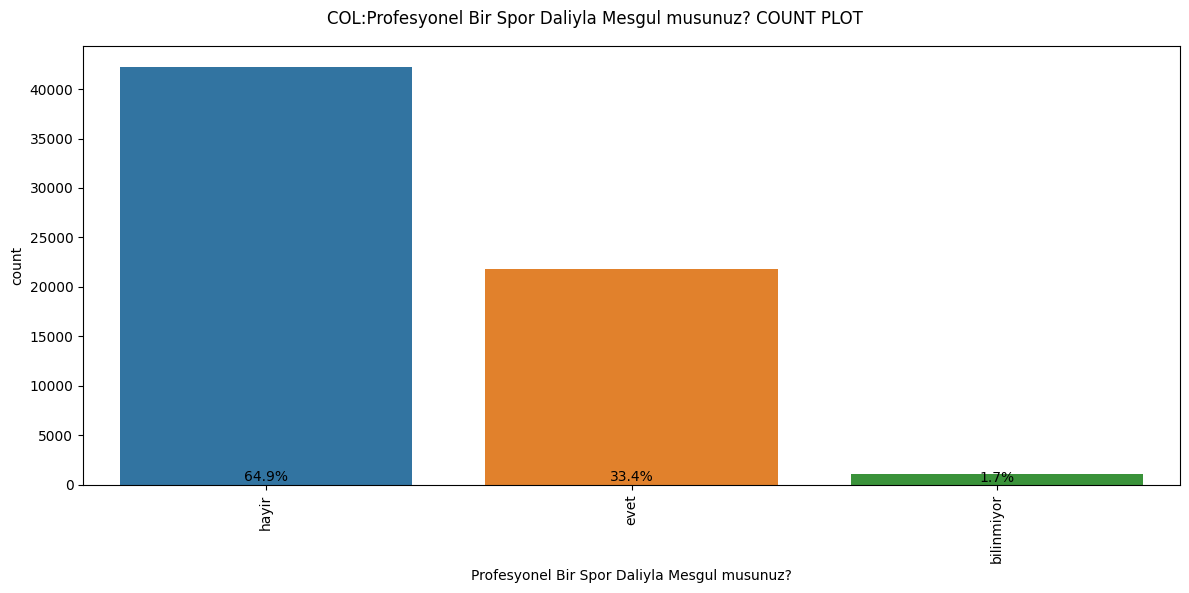

Processing for column: Spor Dalindaki Rolunuz Nedir? in training and test sets


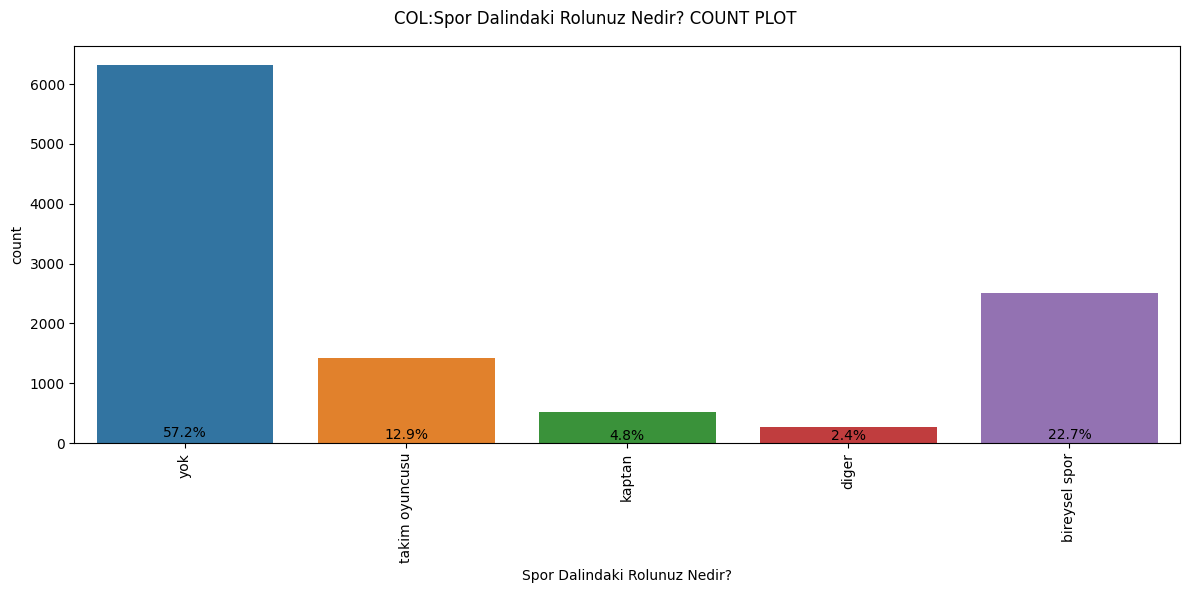

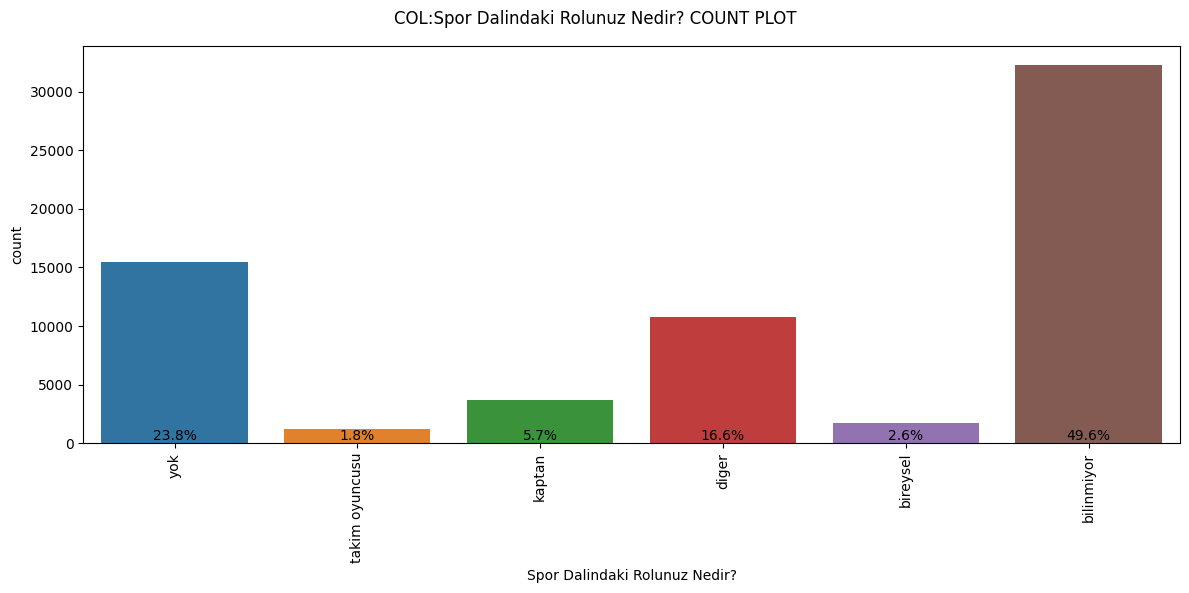

Processing for column: Aktif olarak bir STK üyesi misiniz? in training and test sets


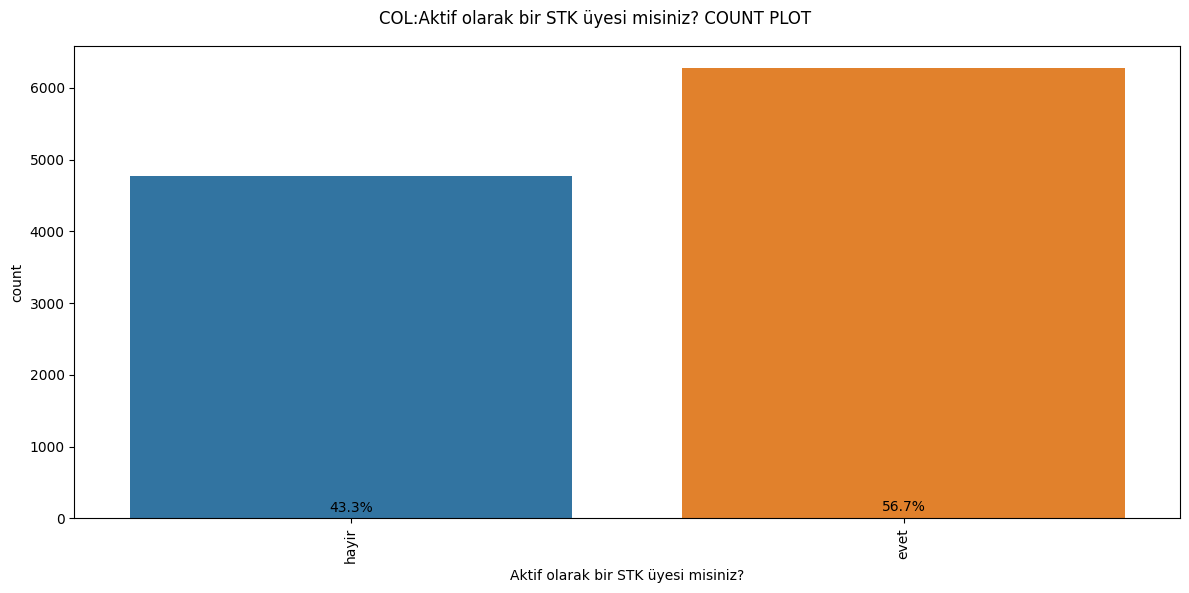

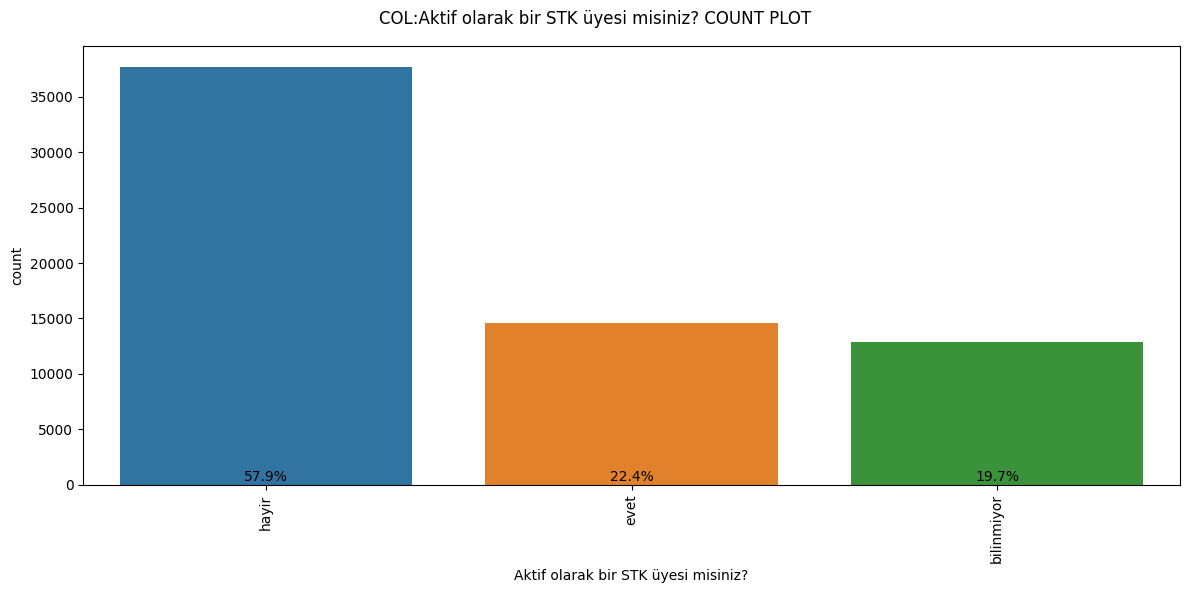

Processing for column: Hangi STK'nin Uyesisiniz? in training and test sets


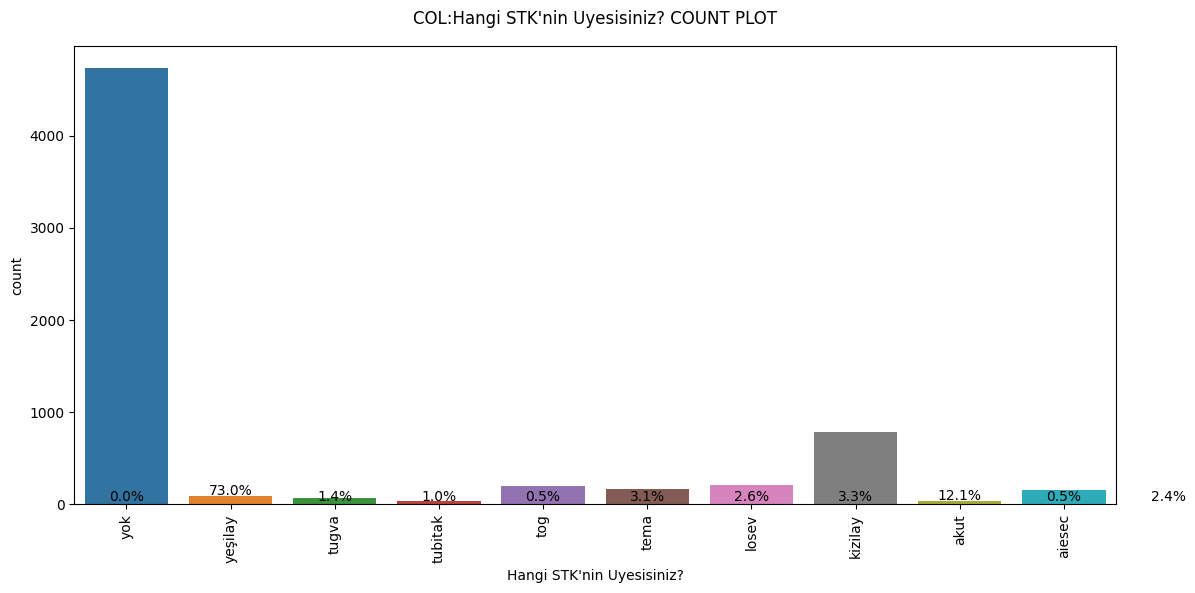

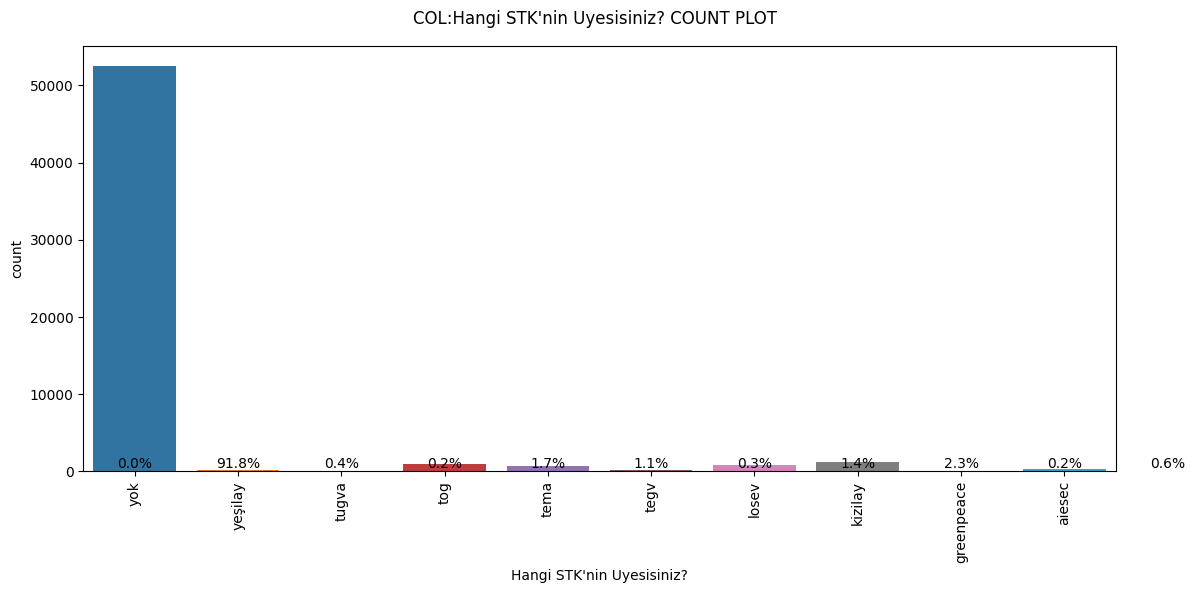

Processing for column: Stk Projesine Katildiniz Mi? in training and test sets


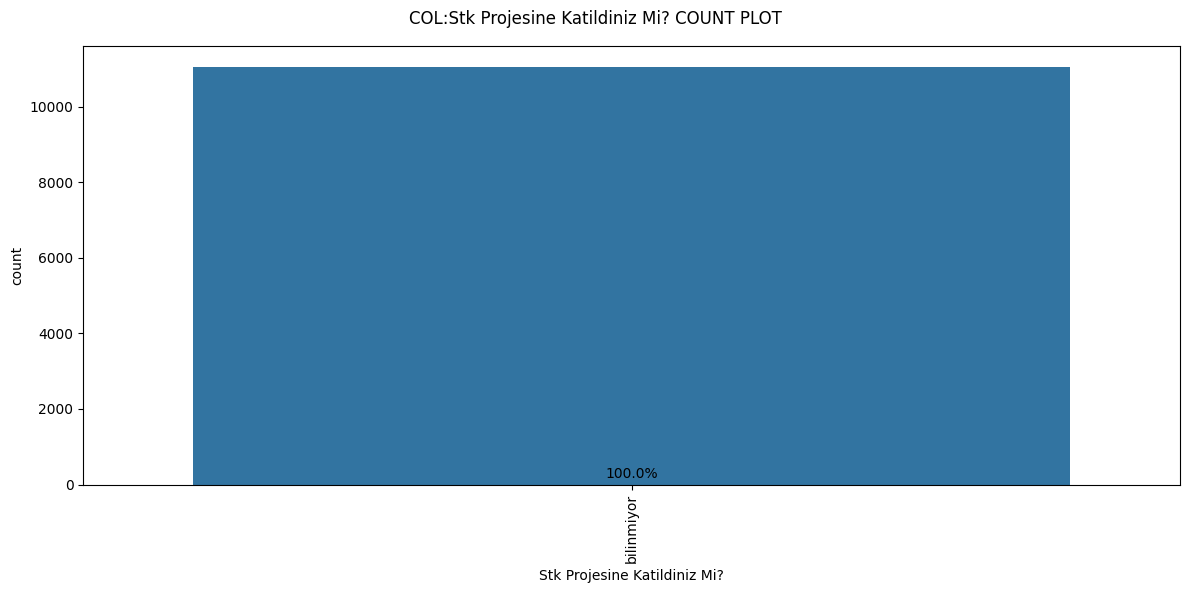

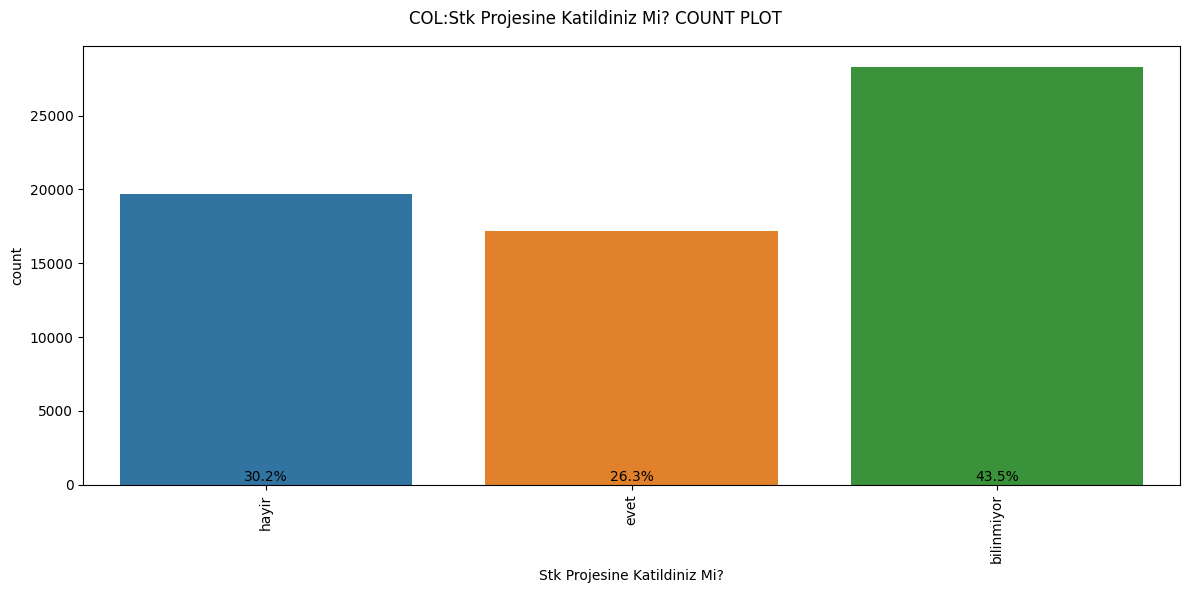

Processing for column: Girisimcilikle Ilgili Deneyiminiz Var Mi? in training and test sets


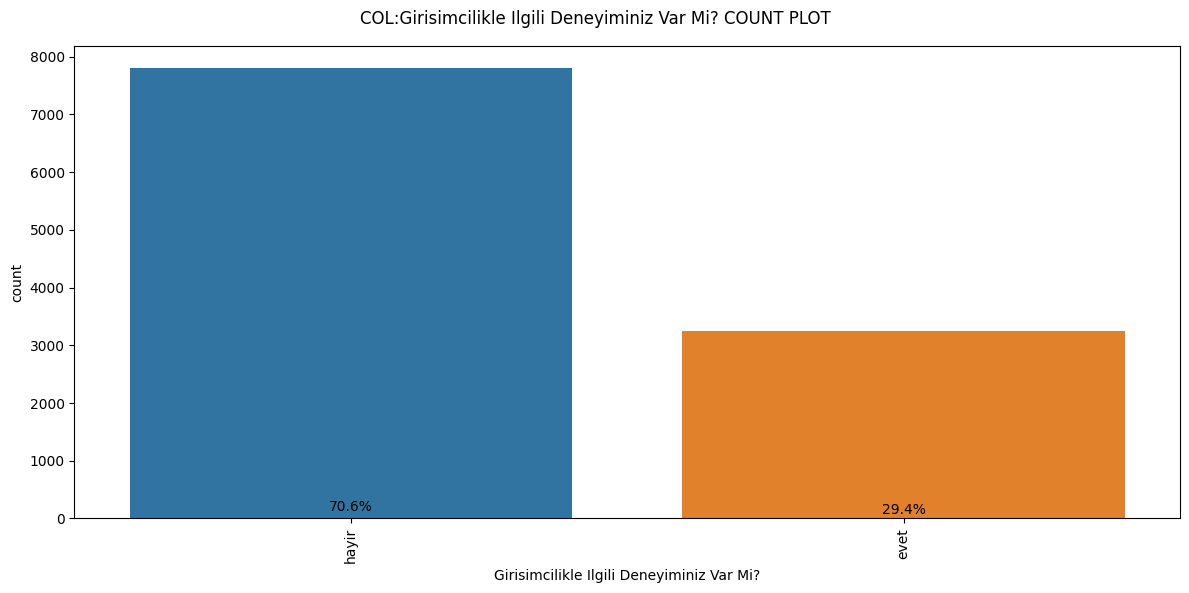

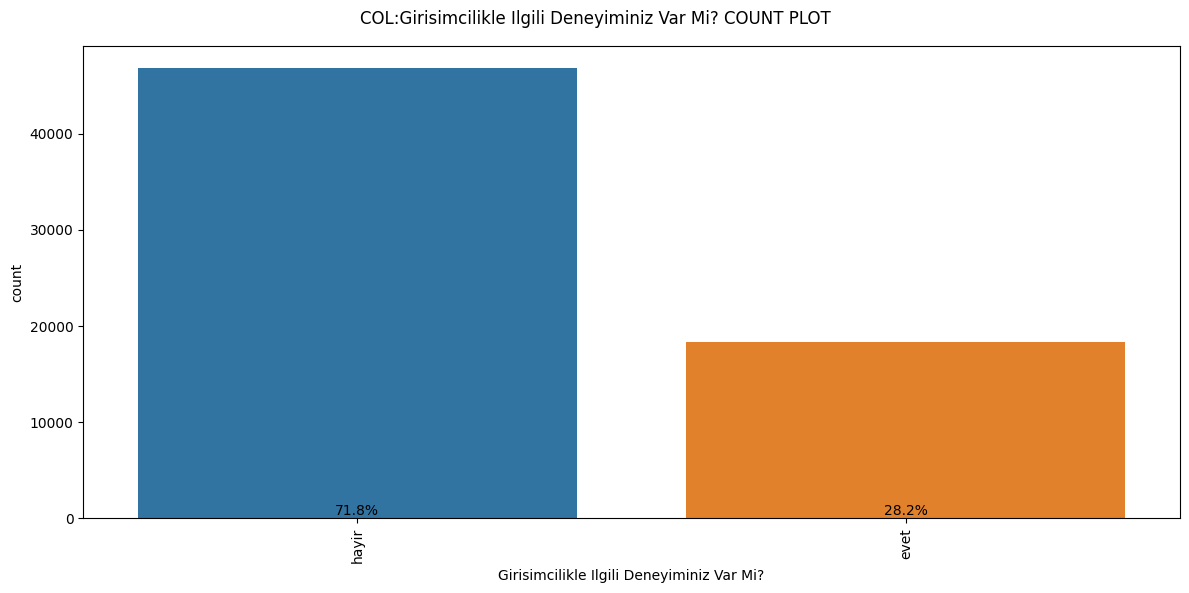

Processing for column: Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz? in training and test sets


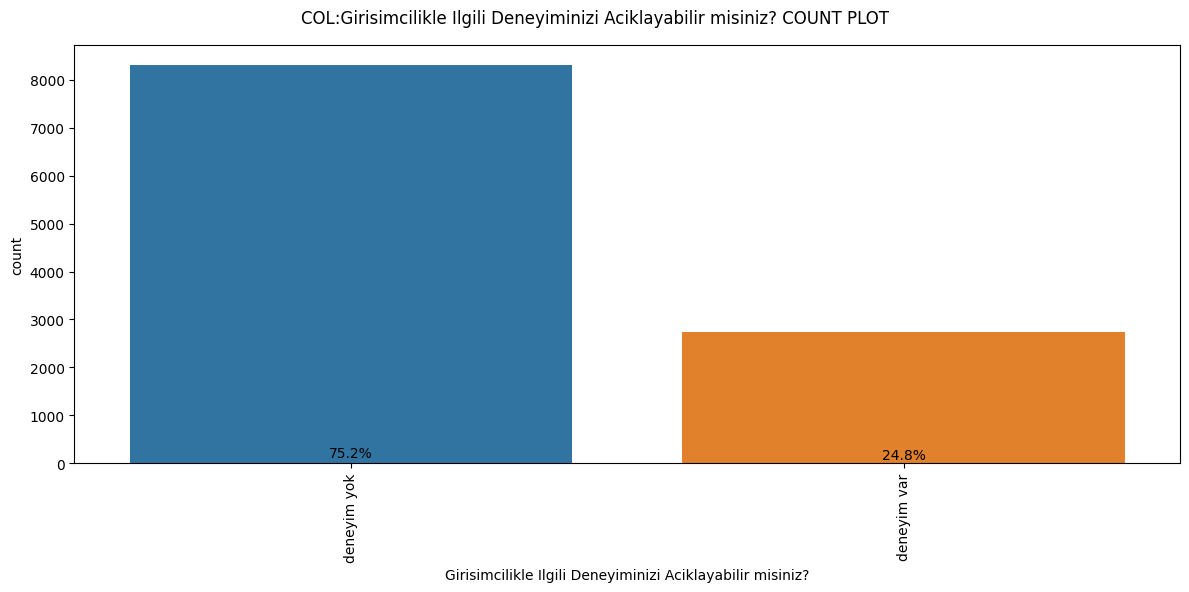

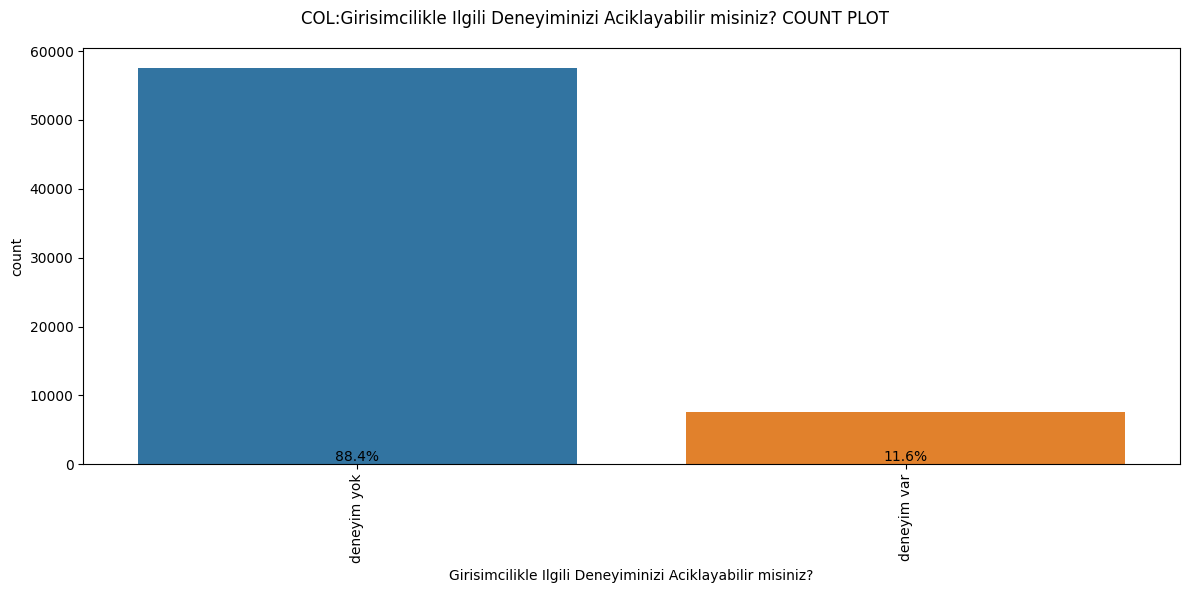

Processing for column: Ingilizce Biliyor musunuz? in training and test sets


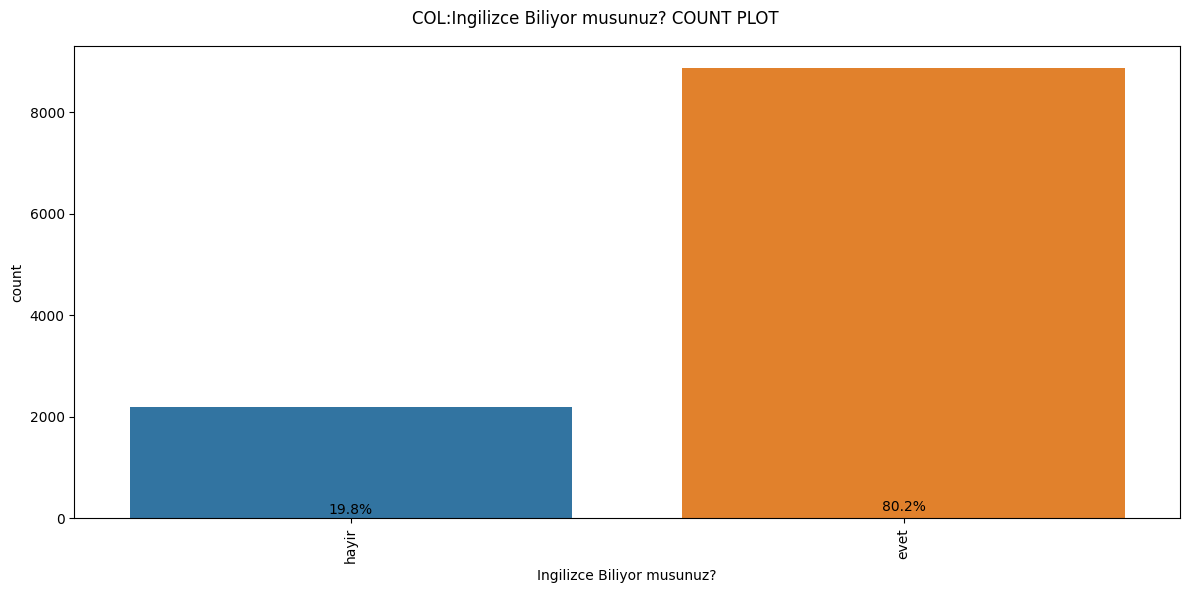

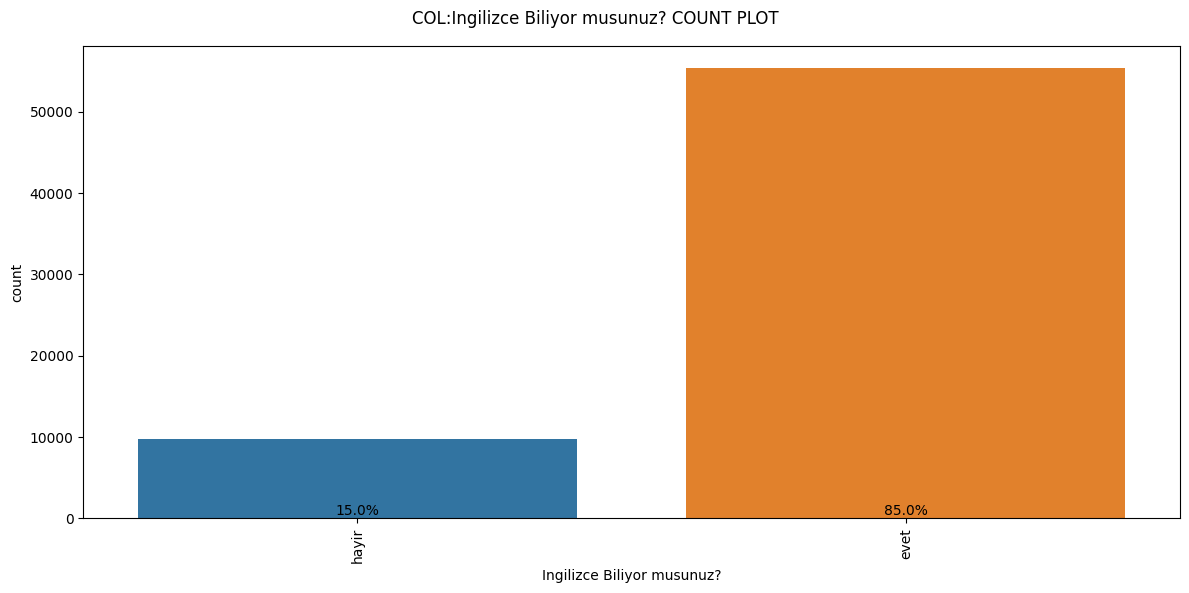

Processing for column: Ingilizce Seviyeniz? in training and test sets


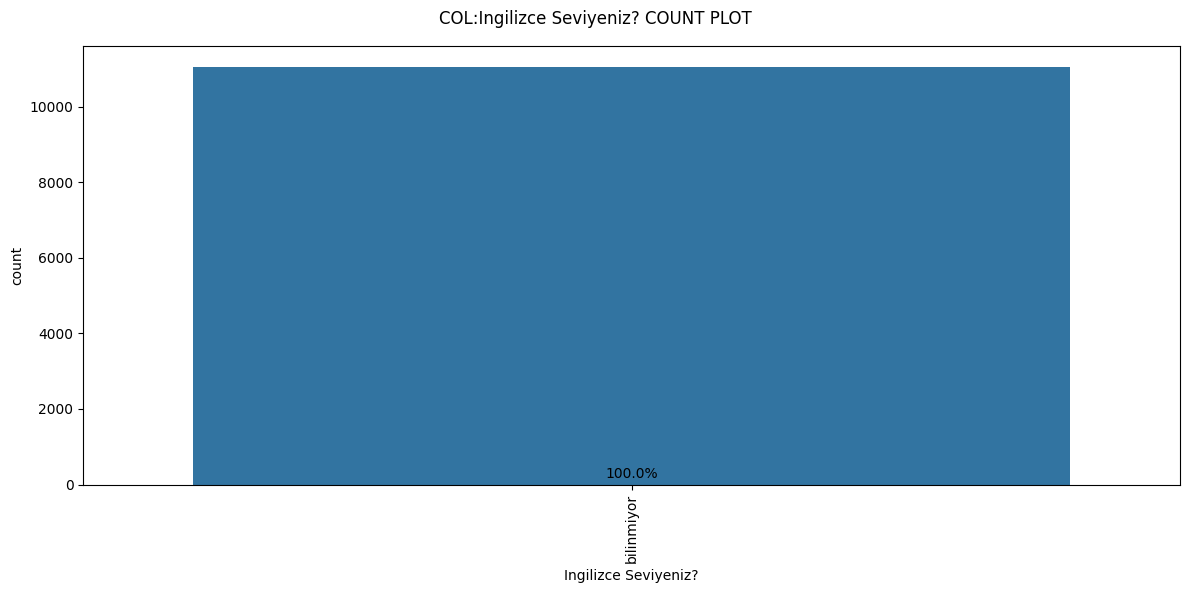

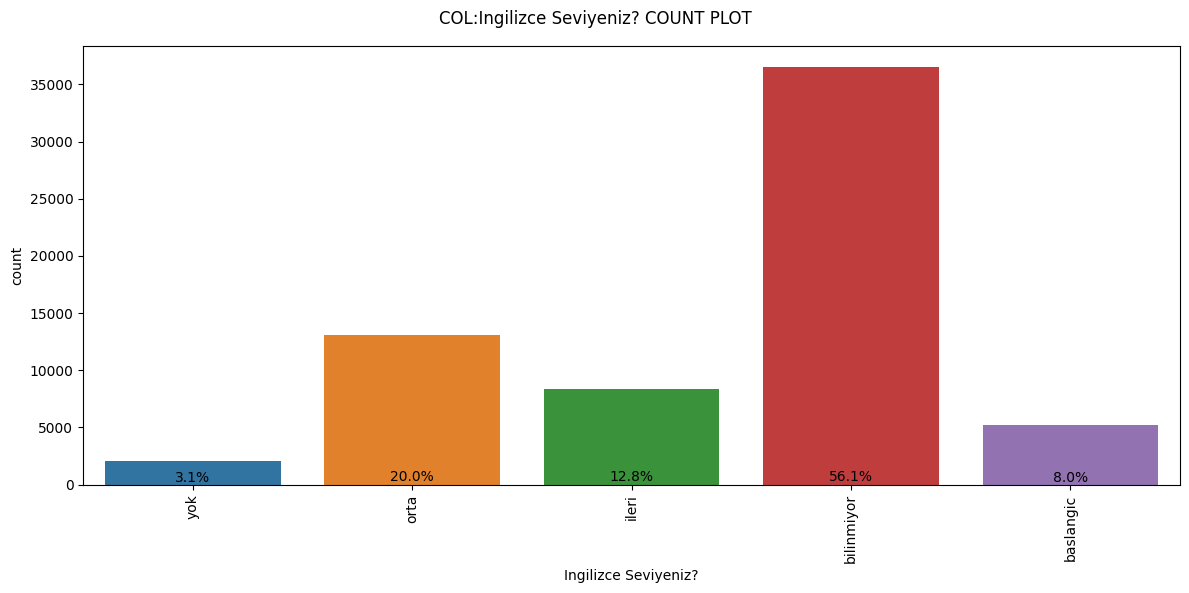

Processing for column: yaş_grubu in training and test sets


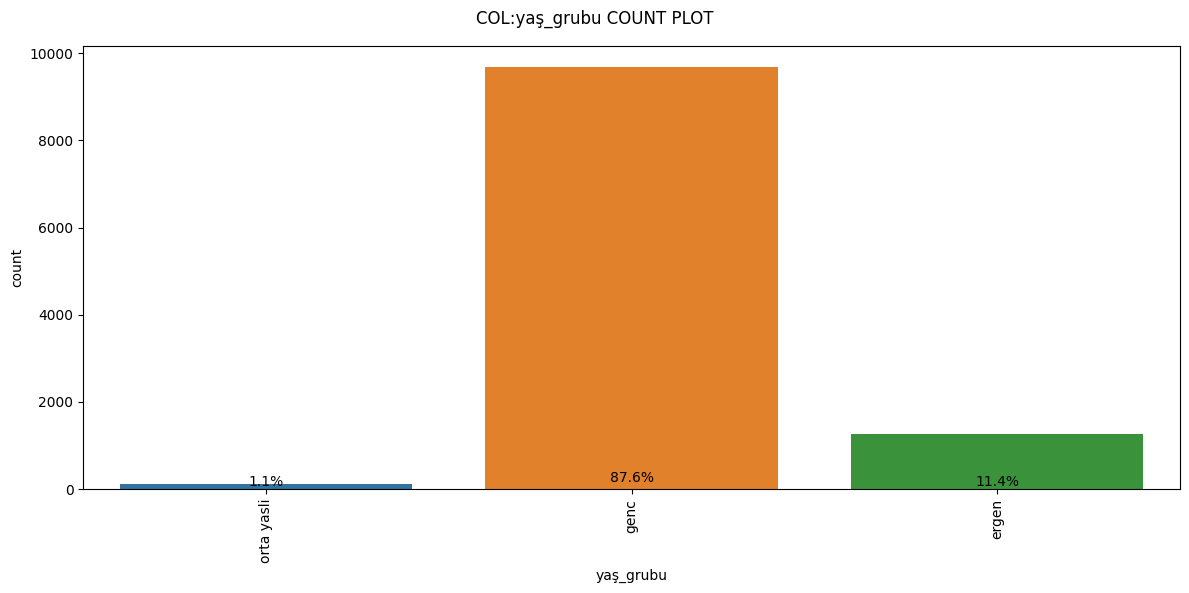

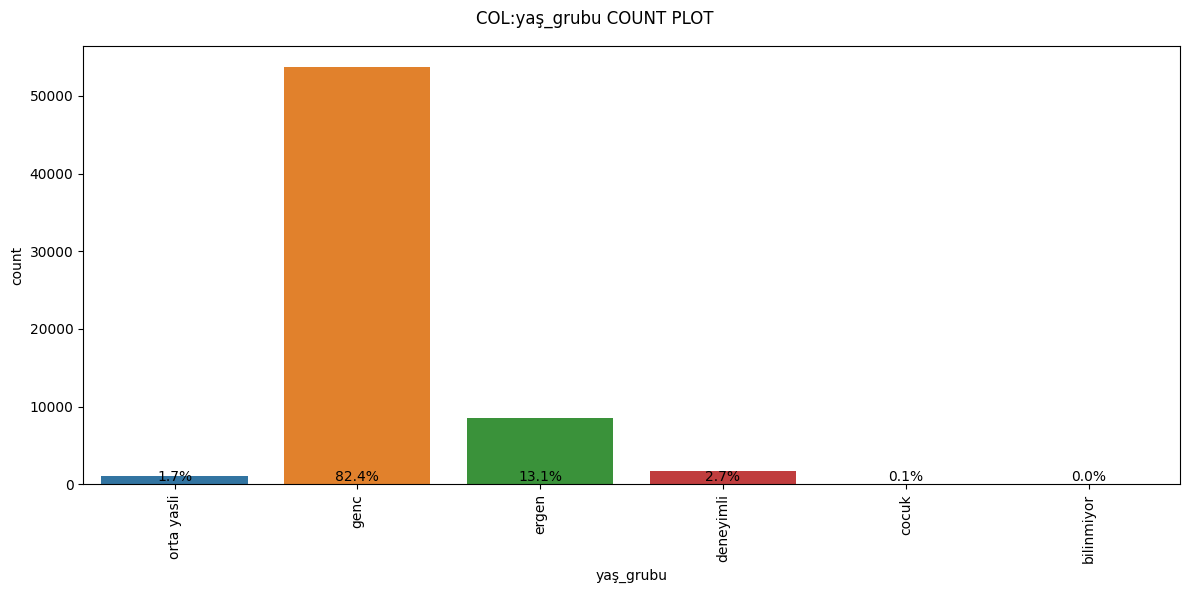

Processing for column: girisimci_stk_etiket in training and test sets


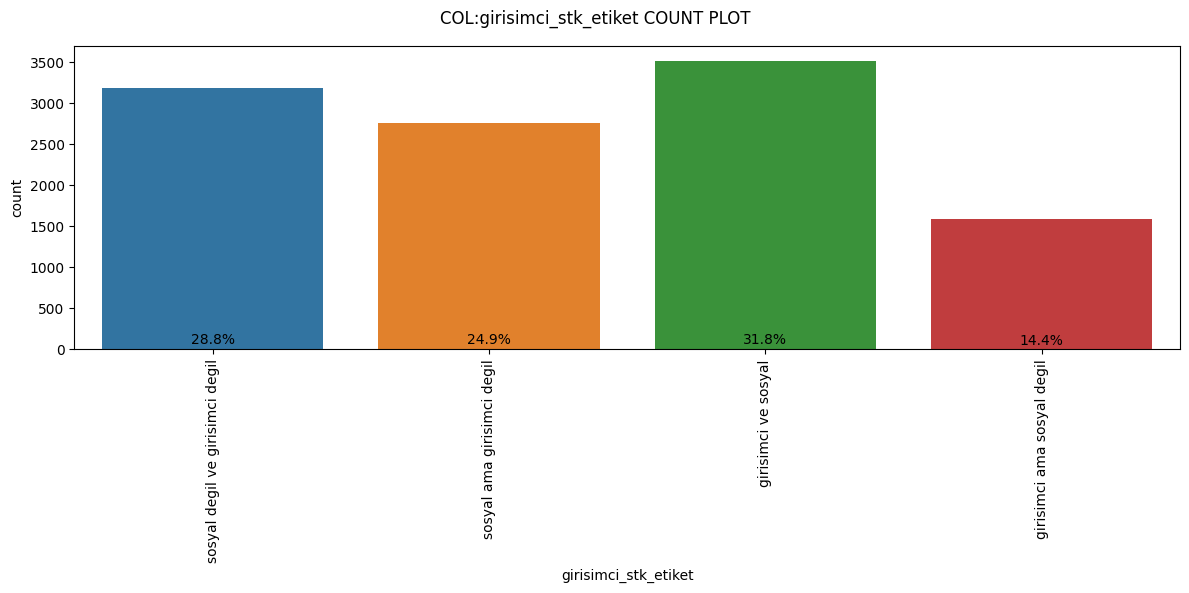

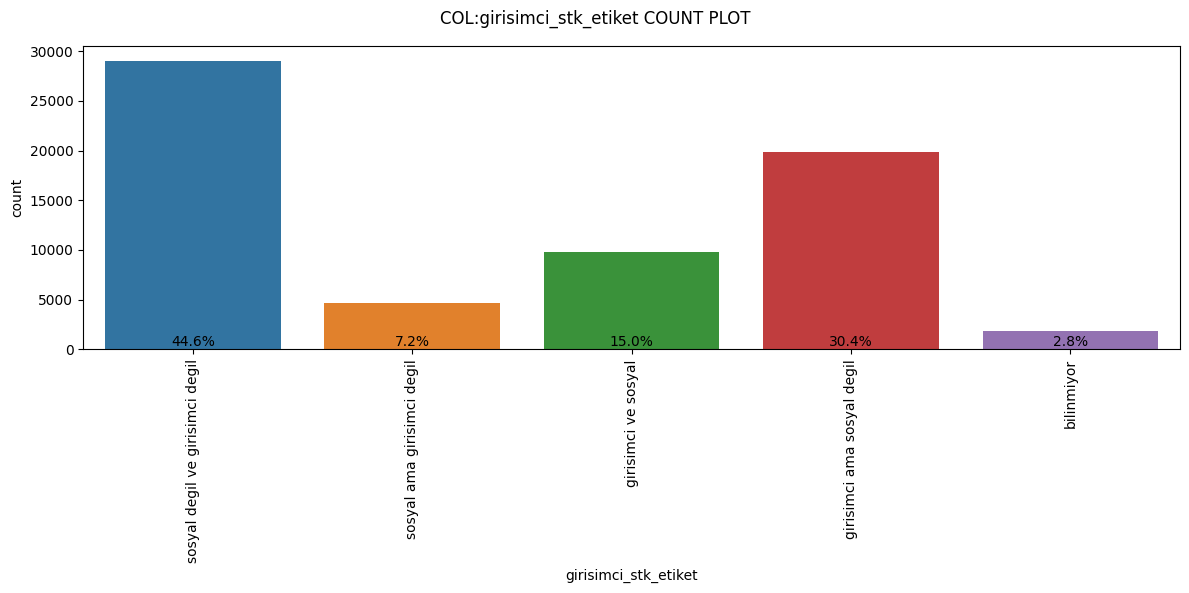

Processing for column: uni_burs in training and test sets


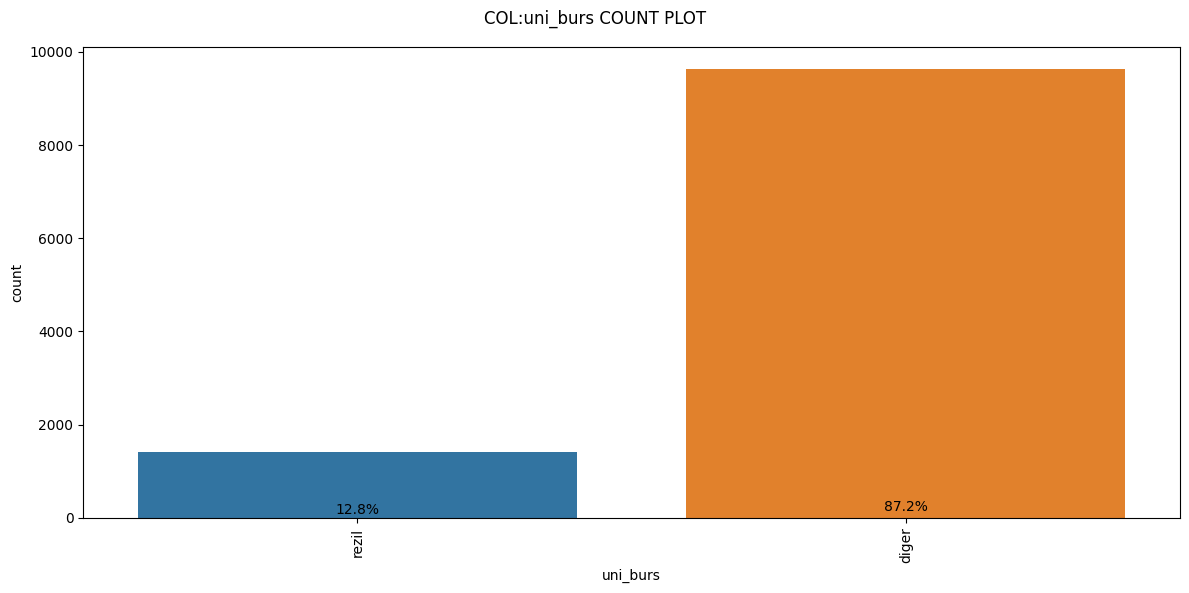

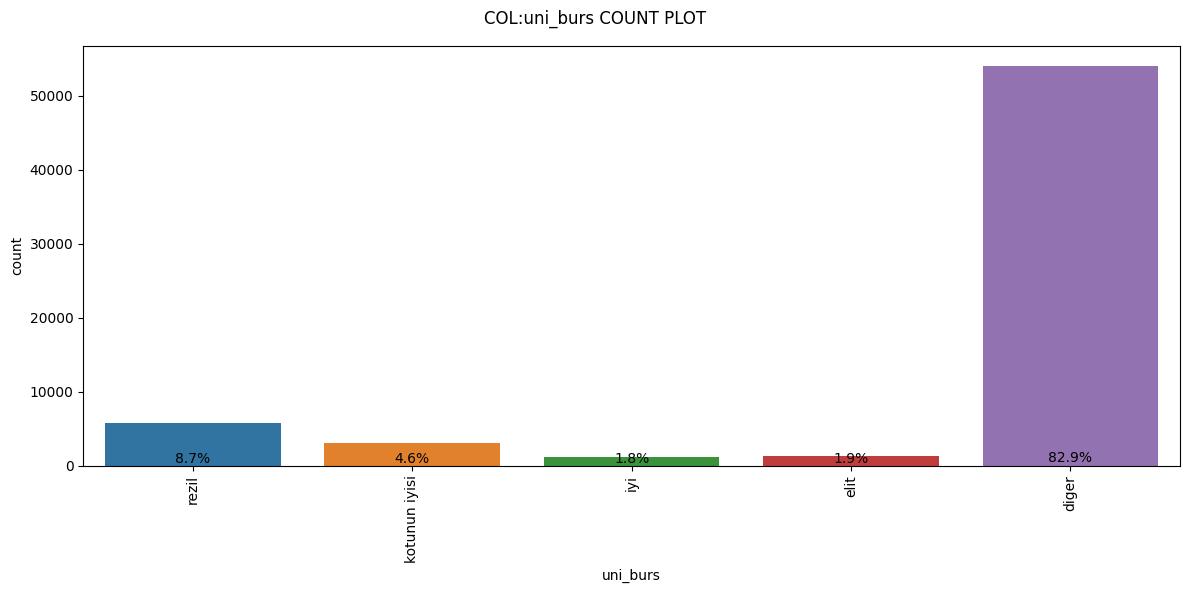

Processing for column: Universite Rank in training and test sets


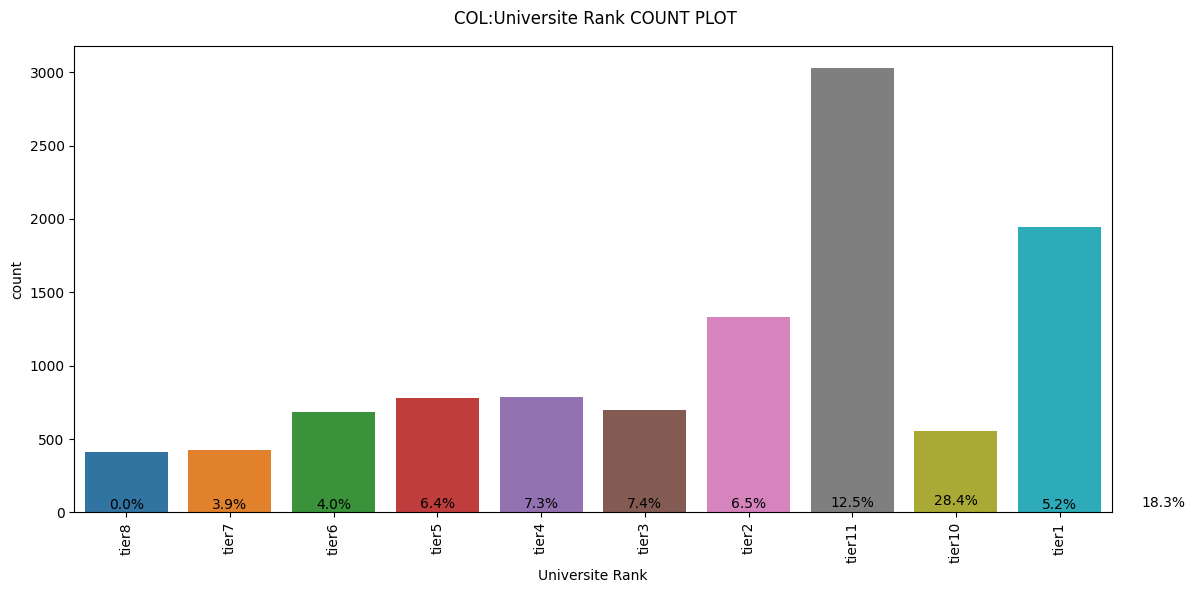

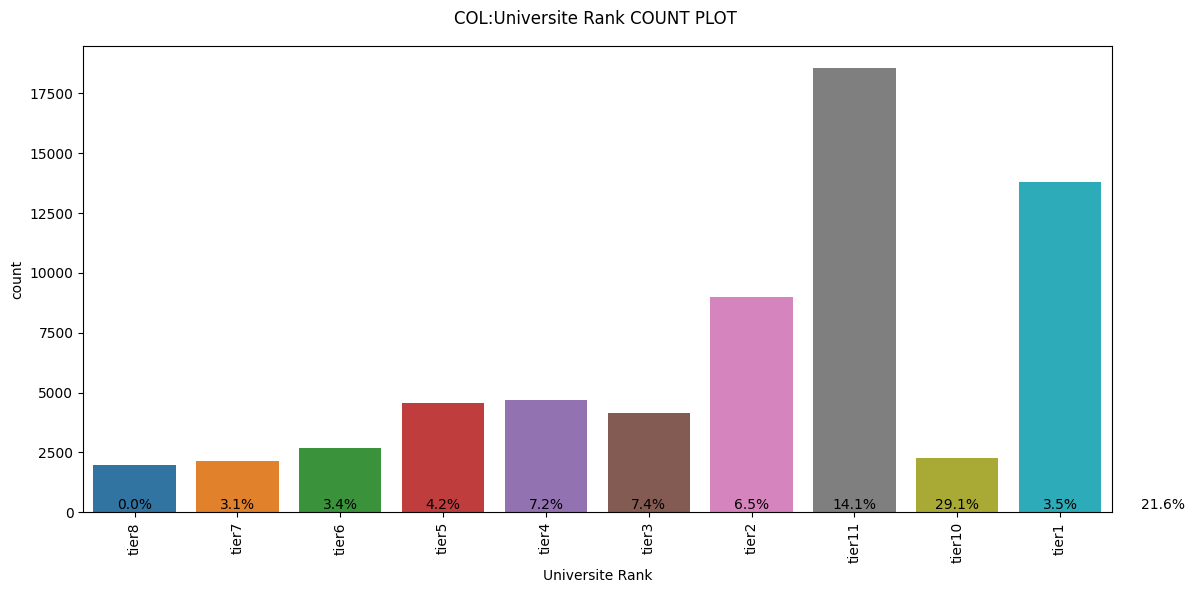

Processing for column: yaş in training and test sets


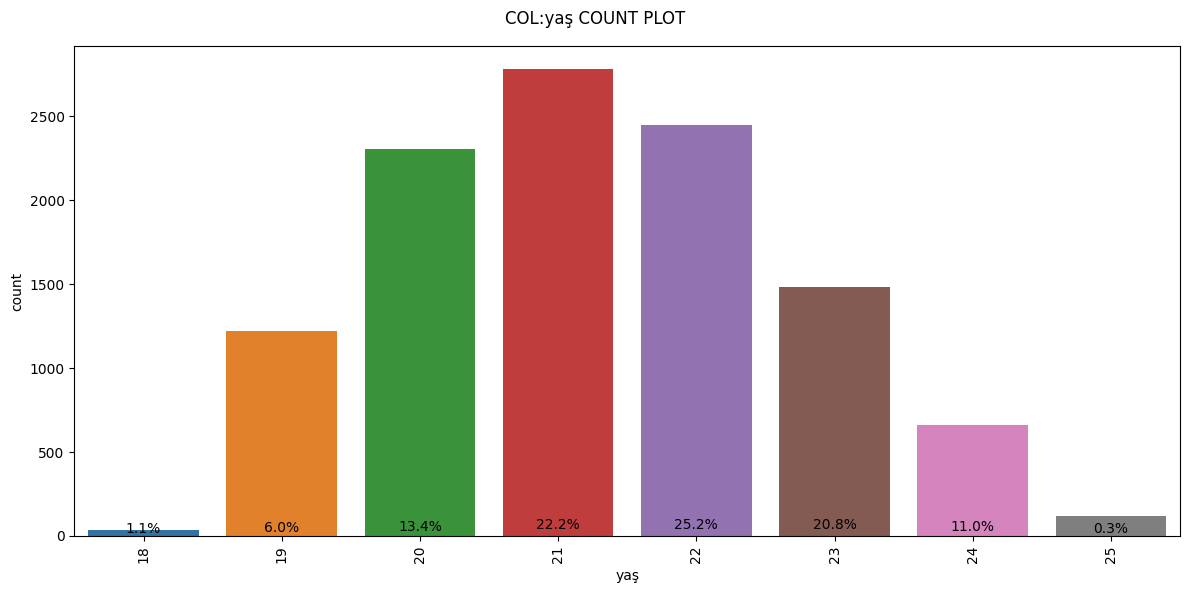

ValueError: nan is not in list

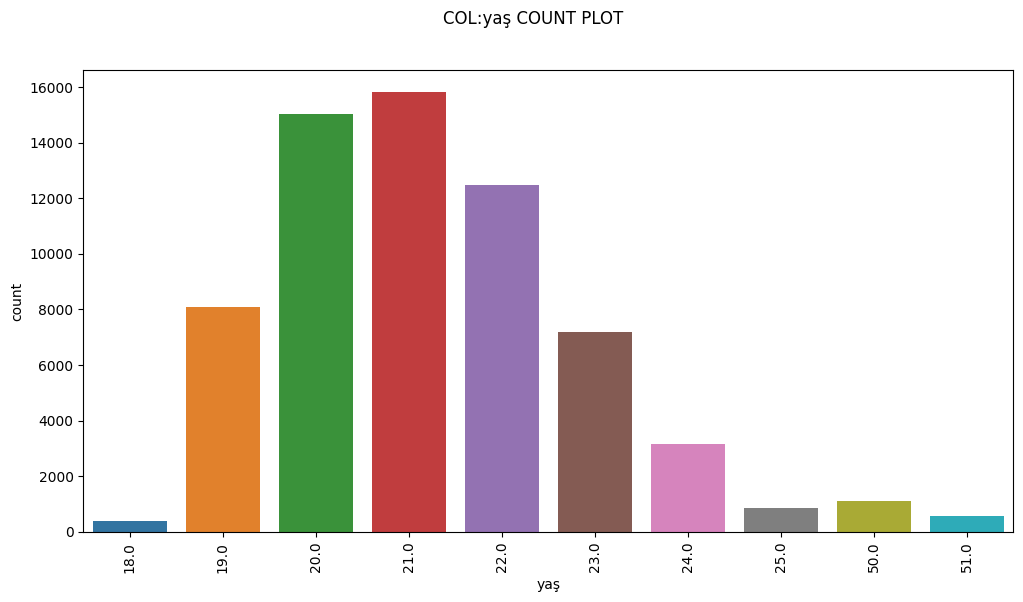

In [297]:
for column in training_columns:
    print(f"Processing for column: {column} in training and test sets")
    
    # Train setine uygulama
    categorical_examiner(test, column, percentage=True)
    
    # Test setine uygulama
    categorical_examiner(train, column, percentage=True)

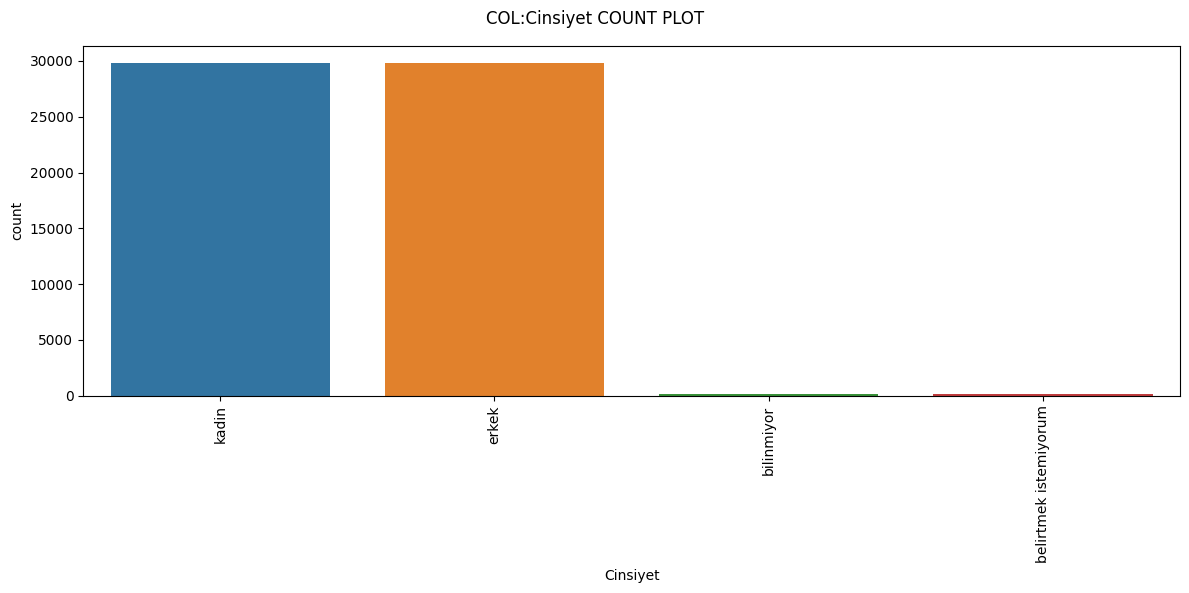

In [223]:
categorical_examiner(train, 'Cinsiyet')

In [299]:
X_test = test[training_columns]
    
X_train = train[training_columns]
y_train = train['Degerlendirme Puani']
    
train_pool = Pool(X_train, y_train, cat_features=categorical_columns)

model = CatBoostRegressor(**params, task_type='GPU', loss_function='RMSE', cat_features=categorical_columns, verbose=100, random_state=42, early_stopping_rounds=10)

model.fit(train_pool)
    
X_test['y_pred'] = model.predict(X_test[training_columns])
    
print("")  # 4.9387570  #5.10 filan gelmis en son 6.22

0:	learn: 17.2876400	total: 113ms	remaining: 2m 30s
100:	learn: 6.3364785	total: 7.08s	remaining: 1m 26s
200:	learn: 5.9882040	total: 14.3s	remaining: 1m 20s
300:	learn: 5.7966659	total: 21.5s	remaining: 1m 13s
400:	learn: 5.7002435	total: 28.1s	remaining: 1m 5s
500:	learn: 5.6200554	total: 35.6s	remaining: 59.3s
600:	learn: 5.5612375	total: 42.3s	remaining: 51.7s
700:	learn: 5.4925507	total: 48.8s	remaining: 44.2s
800:	learn: 5.4390332	total: 55.7s	remaining: 37.2s
900:	learn: 5.3881038	total: 1m 2s	remaining: 30.2s
1000:	learn: 5.3365793	total: 1m 9s	remaining: 23.2s
1100:	learn: 5.2897981	total: 1m 16s	remaining: 16.3s
1200:	learn: 5.2450201	total: 1m 23s	remaining: 9.41s
1300:	learn: 5.1993420	total: 1m 31s	remaining: 2.45s
1335:	learn: 5.1839048	total: 1m 33s	remaining: 0us



In [300]:
X_test['id'] = range(0, len(X_test))

X_test = X_test.rename(columns={'y_pred' : 'Degerlendirme Puani'})

X_test[['id','Degerlendirme Puani']].to_csv('pesediyorum.csv', index = False)

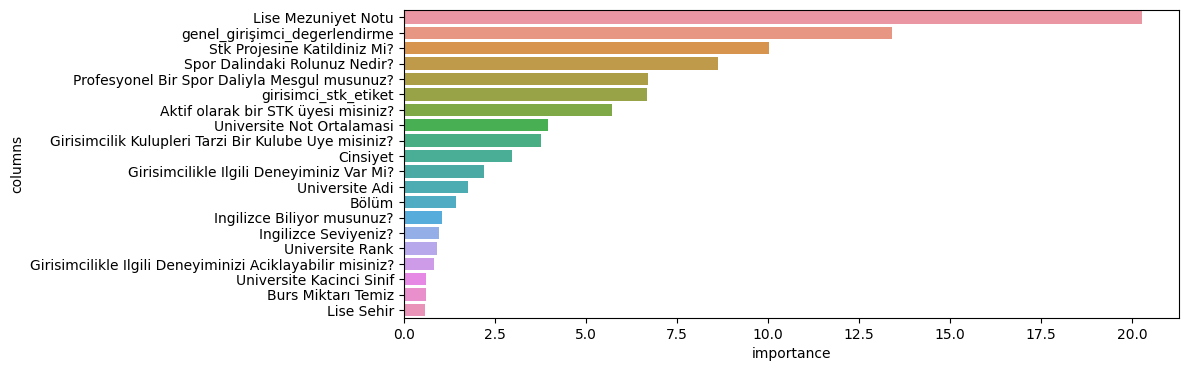

In [301]:
imp_df = pd.DataFrame()
imp_df["importance"] = model.feature_importances_
imp_df["columns"] = training_columns
imp_df.sort_values(by="importance", inplace=True, ascending=False)
plt.figure(figsize=(10,4))
sns.barplot(data=imp_df.head(20), y="columns", x="importance")
plt.show()

In [147]:
a['Ingilizce Biliyor musunuz?'].value_counts()

Ingilizce Biliyor musunuz?
Evet     8863
Hayır    2186
Name: count, dtype: int64

In [142]:
a

,Basvuru Yili,Cinsiyet,Dogum Tarihi,Dogum Yeri,Ikametgah Sehri,Universite Adi,Universite Turu,Burslu ise Burs Yuzdesi,Burs Aliyor mu?,Bölüm,Universite Kacinci Sinif,Universite Not Ortalamasi,Daha Once Baska Bir Universiteden Mezun Olmus,Lise Adi,Lise Adi Diger,Lise Sehir,Lise Turu,Lise Bolumu,Lise Bolum Diger,Lise Mezuniyet Notu,Baska Bir Kurumdan Burs Aliyor mu?,Burs Aldigi Baska Kurum,Baska Kurumdan Aldigi Burs Miktari,Anne Egitim Durumu,Anne Calisma Durumu,Anne Sektor,Baba Egitim Durumu,Baba Calisma Durumu,Baba Sektor,Kardes Sayisi,Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?,Uye Oldugunuz Kulubun Ismi,Profesyonel Bir Spor Daliyla Mesgul musunuz?,Spor Dalindaki Rolunuz Nedir?,Aktif olarak bir STK üyesi misiniz?,Hangi STK'nin Uyesisiniz?,Stk Projesine Katildiniz Mi?,Girisimcilikle Ilgili Deneyiminiz Var Mi?,Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?,Ingilizce Biliyor musunuz?,Ingilizce Seviyeniz?,"Daha Önceden Mezun Olunduysa, Mezun Olunan Üniversite",id
0,2023,Kadın,21.06.2002 00:00,Amasya,Amasya,Munzur Üniversitesi,Devlet,NaN,Hayır,Sosyal Hizmet,1,2.50 - 2.99,NaN,Amasya Suluova Şehit Muharrem Saygun Anadolu L...,NaN,Amasya,Devlet,Eşit Ağırlık,NaN,50 - 74,Hayır,-,-,İlkokul,Evet,Özel Sektör,Ortaokul,Evet,Diğer,2.0,Hayır,NaN,Evet,Takım Oyuncusu,Evet,Kızılay da gönüllü dağıtım,NaN,Hayır,-,Evet,NaN,NaN,0
1,2023,Kadın,11.05.2004 00:00,Konya,Konya,Hacettepe Üniversitesi,Devlet,NaN,Hayır,Uluslararası İlişkiler,1,Hazırlığım,NaN,Açık Öğretim Lisesi,NaN,Konya,Devlet,Eşit Ağırlık,NaN,75 - 100,Hayır,-,-,İlkokul,Hayır,-,İlkokul,Evet,Özel Sektör,3.0,Hayır,NaN,Evet,Bireysel Spor,Hayır,-,NaN,Hayır,-,Evet,NaN,NaN,1
2,2023,Erkek,24.04.2002 00:00,İstanbul,İstanbul,Kapadokya Üniversitesi,Özel,NaN,Evet,Diğer,1,Hazırlığım,NaN,Özel Aşama anadolu lisesi,NaN,İstanbul,Özel,Eşit Ağırlık,NaN,50 - 74,Evet,KYK,1000₺ ve üstü,Yüksek Lisans,Hayır,-,Üniversite,Hayır,-,0.0,Hayır,NaN,Hayır,Bireysel Spor,Hayır,-,NaN,Hayır,-,Evet,NaN,NaN,2
3,2023,Erkek,11.03.2003 00:00,Mardin,Mardin,Mardin Artuklu Üniversitesi,Devlet,NaN,Hayır,İslami İlimler,1,Hazırlığım,NaN,Özcan yıldız AİHL,NaN,Mardin,Devlet,Sözel,NaN,75 - 100,Hayır,-,-,İlkokul,Hayır,-,Lise,Evet,Özel Sektör,4.0,Hayır,NaN,Hayır,-,Evet,Lise gezilerde liderlik yapıyordum,NaN,Hayır,-,Hayır,NaN,NaN,3
4,2023,Erkek,26.01.2002 00:00,Samsun,İstanbul,Boğaziçi Üniversitesi,Devlet,NaN,Hayır,İşletme,3,3.00 - 3.49,NaN,Özel Bafra Açı Fen Lisesi,NaN,Samsun,Özel,Eşit Ağırlık,NaN,75 - 100,Evet,Toplum Gönüllüleri Vakfı,500₺ - 999₺,Üniversite,Evet,Kamu,Üniversite,Evet,Kamu,1.0,Hayır,NaN,Hayır,-,Evet,"Toplum Gönüllüleri Vakfı'nda ""Yol Arkadaşım"" P...",NaN,Evet,"12 aydır, yolculuğuna bir yıl önce başlamış ol...",Evet,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11044,2023,Kadın,3.01.2002 00:00,Yozgat,Ankara,Gazi Üniversitesi,Devlet,NaN,Hayır,Endüstri Mühendisliği,2,1.80 - 2.49,NaN,Yozgat Şehitler Fen Lisesi,NaN,Yozgat,Devlet,Sayısal,NaN,75 - 100,Evet,KYK,1000₺ ve üstü,İlkokul,Hayır,-,Ortaokul,Hayır,-,0.0,Evet,NaN,Hayır,-,Evet,TOG Vakfı'nda yaklaşık bir yıldır hem aktif gö...,NaN,Hayır,-,Evet,NaN,NaN,11044
11045,2023,Kadın,9.09.2001 00:00,Konya,Konya,Niğde Ömer Halisdemir Üniversitesi,Devlet,NaN,Hayır,Gıda Mühendisliği,3,3.00 - 3.49,NaN,Prof. Dr. Ömer Dinçer Kız Anadolu İmam Hatip L...,NaN,Konya,Devlet,Sayısal,NaN,75 - 100,Hayır,-,-,İlkokul,Hayır,-,İlkokul,Evet,Kamu,3.0,Evet,NaN,Hayır,-,Evet,Konyada düzenlenen 5. İslami dayanışma oyunlar...,NaN,Hayır,-,Hayır,NaN,NaN,11045
11046,2023,Erkek,8.06.2004 00:00,Ankara,Ankara,Karabük Üniversitesi,Devlet,NaN,Hayır,Elektrik-Elektronik Mühendisliği,1,Hazırlığım,NaN,Nokta tek koleji,NaN,Ankara,Özel,Sayısal,NaN,75 - 100,Hayır,-,-,İlkokul,Hayır,-,Üniversite,Evet,Diğer,2.0,Evet,NaN,Evet,Takım Oyuncusu,Evet,Hayvanlara yardım adı altında hayvanlara yardı...,NaN,Hayır,-,Evet,NaN,NaN,11046
11047,2023,Kadın,16.10.2001 00:00,Adıyaman,İstan

In [46]:
X_test['Degerlendirme Puani'].mean()

30.245316446901256

In [47]:
X_test['Degerlendirme Puani'].max()

65.01242264322718

In [48]:
X_test['Degerlendirme Puani'].min()

1.9098841906979942

In [34]:
sdsd = pd.read_csv(r'C:\Users\Pc\Desktop\btk\bu daha iyi olcek.csv')

In [35]:
sdsd['Degerlendirme Puani'].mean()

31.921726747167515